# Classification
### Step 1: resize/crop images
Requires having run: `beescrape.py`
Depends on yolov5 and `shutil`

In [1]:
# init
import os
from os import listdir
from shutil import copyfile
import shutil
from PIL import Image
import skimage
import random
import numpy as np

# Directories
DATA_DIR = '/home/wilber/Documents/RESEARCH/research/beespotter'
OUT_DIR = '/m2docs/res/data'
CROPPED_PATH = '/m2docs/res/cropped_imgs'
cropped_files = listdir(CROPPED_PATH)

# Args:
VAL_SIZE = 256
TEST_SIZE = 128
preprocess = True
resize = True
length = 256
size = (length, length) # (512, 512)

# Uncropped args: (use the same images except without passing through yolo bee finder for comparison)
OUT_DIR_RAW = '/m2docs/res/data_raw'
UNCROPPED_PATH = '/m2docs/res/uncropped_imgs'
COPY_UNCROPPED = True

# Species with >= 1000 images:
classes = ['Apis_mellifera','Bombus_impatiens','Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']


In [1]:
%rm -R /m2docs/res/data/*

# from https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a
noise_modes = [None,'salt','pepper','s&p']
NOISE_AMOUNT = .01 # default amount
def add_noise(img, mode, noise_amount = .03):
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode = mode, amount = random.uniform(0,noise_amount))
        return gimg
    else:
        print("oops, you shouldn't see this")

total_skipped = 0
for label in classes:  # for each type of bee
    skipnum = 0
    classID = classes.index(label)
    
    input_path = os.path.join(DATA_DIR, label)
    im_list = os.listdir(input_path)
    random.shuffle(im_list)
    
    # Attempt to create directories:
    if not os.path.exists(OUT_DIR + '/train/' + label):
        os.makedirs(OUT_DIR + '/train/' + label)
    if not os.path.exists(OUT_DIR + '/test/' + label):
        os.makedirs(OUT_DIR + '/test/' + label)
    if not os.path.exists(OUT_DIR + '/valid/' + label):
        os.makedirs(OUT_DIR + '/valid/' + label)
    if not os.path.exists(OUT_DIR_RAW + '/train/' + label):
        os.makedirs(OUT_DIR_RAW + '/train/' + label)
    if not os.path.exists(OUT_DIR_RAW + '/test/' + label):
        os.makedirs(OUT_DIR_RAW + '/test/' + label)
    if not os.path.exists(OUT_DIR_RAW + '/valid/' + label):
        os.makedirs(OUT_DIR_RAW + '/valid/' + label)
        
    train_path = os.path.join(OUT_DIR,'train/'+ label + '/')
    test_path  = os.path.join(OUT_DIR,'test/' + label + '/')
    valid_path = os.path.join(OUT_DIR,'valid/' + label + '/')
    train_path_raw = os.path.join(OUT_DIR_RAW,'train/'+ label + '/')
    test_path_raw  = os.path.join(OUT_DIR_RAW,'test/' + label + '/')
    valid_path_raw = os.path.join(OUT_DIR_RAW,'valid/' + label + '/')
    
    index = 0
    for img in im_list:
        if img in cropped_files:
            pic = Image.open(os.path.join(CROPPED_PATH,img))
            
            if (COPY_UNCROPPED):
                    pic2 = Image.open(os.path.join(UNCROPPED_PATH,img))
            
            if resize: #resize image
                out = pic.resize(size)
                if (COPY_UNCROPPED):
                    out2 = pic2.resize(size)
            else:
                out = pic
                if (COPY_UNCROPPED):
                    out2 = pic2
            
            if index < VAL_SIZE:
                out.save(os.path.join(valid_path,img))
            elif index < VAL_SIZE + TEST_SIZE:
                out.save(os.path.join(test_path,img))
            if index < VAL_SIZE and COPY_UNCROPPED:
                out2.save(os.path.join(valid_path_raw,img))
            elif index < VAL_SIZE + TEST_SIZE and COPY_UNCROPPED:
                out2.save(os.path.join(test_path_raw,img))    
            else:    #training set, rotate
                out.save(os.path.join(train_path,img.replace('.jpg','-0.jpg')))
                if COPY_UNCROPPED:
                    out2.save(os.path.join(train_path_raw,img.replace('.jpg','-0.jpg')))
                if preprocess:
                    for rot,mode,ext in zip([random.randint(0,359),random.randint(0,359),random.randint(0,359)],[random.choice(noise_modes),random.choice(noise_modes),random.choice(noise_modes)],[1,2,3]):
                        print(' ',img,rot,mode,ext,pic.mode)
                        if mode is not None:
                            Image.fromarray((add_noise(np.array(out.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic.mode).save(os.path.join(train_path,img.replace('.jpg','-'+str(ext)+'.jpg')))
                            if COPY_UNCROPPED:
                                Image.fromarray((add_noise(np.array(out2.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic2.mode).save(os.path.join(train_path_raw,img.replace('.jpg','-'+str(ext)+'.jpg')))
                        else:
                            out.rotate(rot).save(os.path.join(train_path,img.replace('.jpg','-'+str(ext)+'.jpg')))
                            if COPY_UNCROPPED:
                                out2.rotate(rot).save(os.path.join(train_path_raw,img.replace('.jpg','-'+str(ext)+'.jpg')))
                
        else:
            skipnum += 1
            index -= 1
            pass
        index += 1
    print(label, "skipped", skipnum)
    print(label, "total", index)
    
    total_skipped += skipnum
    
print("Images moved and rotated. Skipped ", total_skipped)

  8079-1.jpg 291 s&p 1 RGB
  8079-1.jpg 39 salt 2 RGB
  8079-1.jpg 33 pepper 3 RGB
  7101-3.jpg 54 None 1 RGB
  7101-3.jpg 308 s&p 2 RGB
  7101-3.jpg 236 salt 3 RGB
  2643-4.jpg 334 None 1 RGB
  2643-4.jpg 281 pepper 2 RGB
  2643-4.jpg 206 None 3 RGB
  8078-2.jpg 325 s&p 1 RGB
  8078-2.jpg 290 None 2 RGB
  8078-2.jpg 191 salt 3 RGB
  2934-1.jpg 291 s&p 1 RGB
  2934-1.jpg 150 salt 2 RGB
  2934-1.jpg 110 s&p 3 RGB
  3603-3.jpg 183 None 1 RGB
  3603-3.jpg 73 salt 2 RGB
  3603-3.jpg 259 None 3 RGB
  8082-1.jpg 281 salt 1 RGB
  8082-1.jpg 288 pepper 2 RGB
  8082-1.jpg 142 salt 3 RGB
  3545-3.jpg 193 salt 1 RGB
  3545-3.jpg 188 pepper 2 RGB
  3545-3.jpg 164 None 3 RGB
  6523-15.jpg 95 None 1 RGB
  6523-15.jpg 26 s&p 2 RGB
  6523-15.jpg 339 s&p 3 RGB
  8132-1.jpg 157 pepper 1 RGB
  8132-1.jpg 76 None 2 RGB
  8132-1.jpg 199 salt 3 RGB
  6156-1.jpg 346 pepper 1 RGB
  6156-1.jpg 106 None 2 RGB
  6156-1.jpg 275 None 3 RGB
  4623-1.jpg 33 None 1 RGB
  4623-1.jpg 87 None 2 RGB
  4623-1.jpg 205 None

  7896-1.jpg 164 None 1 RGB
  7896-1.jpg 350 s&p 2 RGB
  7896-1.jpg 156 pepper 3 RGB
  5648-1.jpg 316 salt 1 RGB
  5648-1.jpg 60 s&p 2 RGB
  5648-1.jpg 176 pepper 3 RGB
  7870-3.jpg 245 None 1 RGB
  7870-3.jpg 325 None 2 RGB
  7870-3.jpg 325 salt 3 RGB
  5821-2.jpg 338 pepper 1 RGB
  5821-2.jpg 155 None 2 RGB
  5821-2.jpg 181 s&p 3 RGB
  1606-1.jpg 163 pepper 1 RGB
  1606-1.jpg 253 salt 2 RGB
  1606-1.jpg 105 pepper 3 RGB
  4187-1.jpg 343 pepper 1 RGB
  4187-1.jpg 92 None 2 RGB
  4187-1.jpg 26 None 3 RGB
  1820-4.jpg 326 salt 1 RGB
  1820-4.jpg 35 salt 2 RGB
  1820-4.jpg 244 None 3 RGB
  7903-1.jpg 133 salt 1 RGB
  7903-1.jpg 100 s&p 2 RGB
  7903-1.jpg 1 None 3 RGB
  6392-3.jpg 88 s&p 1 RGB
  6392-3.jpg 87 salt 2 RGB
  6392-3.jpg 205 s&p 3 RGB
  271-2.jpg 136 s&p 1 RGB
  271-2.jpg 302 pepper 2 RGB
  271-2.jpg 270 salt 3 RGB
  7867-2.jpg 311 s&p 1 RGB
  7867-2.jpg 125 pepper 2 RGB
  7867-2.jpg 333 salt 3 RGB
  5140-5.jpg 76 None 1 RGB
  5140-5.jpg 81 salt 2 RGB
  5140-5.jpg 182 pepper 3

  6102-1.jpg 345 pepper 3 RGB
  6519-1.jpg 54 salt 1 RGB
  6519-1.jpg 28 s&p 2 RGB
  6519-1.jpg 304 salt 3 RGB
  1997-1.jpg 169 None 1 RGB
  1997-1.jpg 24 salt 2 RGB
  1997-1.jpg 205 s&p 3 RGB
  5704-16.jpg 68 None 1 RGB
  5704-16.jpg 169 pepper 2 RGB
  5704-16.jpg 106 pepper 3 RGB
  6520-11.jpg 119 None 1 RGB
  6520-11.jpg 296 salt 2 RGB
  6520-11.jpg 57 salt 3 RGB
  9304-1.jpg 90 pepper 1 RGB
  9304-1.jpg 74 salt 2 RGB
  9304-1.jpg 48 pepper 3 RGB
  5715-1.jpg 315 pepper 1 RGB
  5715-1.jpg 175 salt 2 RGB
  5715-1.jpg 285 salt 3 RGB
  3172-1.jpg 51 salt 1 RGB
  3172-1.jpg 270 s&p 2 RGB
  3172-1.jpg 95 pepper 3 RGB
  8466-1.jpg 48 salt 1 RGB
  8466-1.jpg 320 s&p 2 RGB
  8466-1.jpg 322 None 3 RGB
  1316-1.jpg 202 None 1 RGB
  1316-1.jpg 340 pepper 2 RGB
  1316-1.jpg 212 None 3 RGB
  1131-1.jpg 0 salt 1 RGB
  1131-1.jpg 25 s&p 2 RGB
  1131-1.jpg 213 s&p 3 RGB
  6330-1.jpg 45 pepper 1 RGB
  6330-1.jpg 271 None 2 RGB
  6330-1.jpg 35 None 3 RGB
  4293-1.jpg 258 salt 1 RGB
  4293-1.jpg 263 s

  5839-2.jpg 320 s&p 1 RGB
  5839-2.jpg 219 pepper 2 RGB
  5839-2.jpg 261 pepper 3 RGB
  560-1.jpg 48 None 1 RGB
  560-1.jpg 144 salt 2 RGB
  560-1.jpg 169 None 3 RGB
  1820-2.jpg 122 pepper 1 RGB
  1820-2.jpg 0 salt 2 RGB
  1820-2.jpg 98 None 3 RGB
  3382-1.jpg 126 None 1 RGB
  3382-1.jpg 227 None 2 RGB
  3382-1.jpg 91 salt 3 RGB
  7916-1.jpg 261 pepper 1 RGB
  7916-1.jpg 123 salt 2 RGB
  7916-1.jpg 110 None 3 RGB
  3429-1.jpg 272 pepper 1 RGB
  3429-1.jpg 201 pepper 2 RGB
  3429-1.jpg 182 None 3 RGB
  6351-2.jpg 188 salt 1 RGB
  6351-2.jpg 0 None 2 RGB
  6351-2.jpg 322 None 3 RGB
  5822-2.jpg 214 salt 1 RGB
  5822-2.jpg 204 s&p 2 RGB
  5822-2.jpg 102 pepper 3 RGB
  322-3.jpg 310 s&p 1 RGB
  322-3.jpg 220 pepper 2 RGB
  322-3.jpg 67 s&p 3 RGB
  5116-4.jpg 28 s&p 1 RGB
  5116-4.jpg 95 salt 2 RGB
  5116-4.jpg 164 s&p 3 RGB
  4617-5.jpg 1 salt 1 RGB
  4617-5.jpg 219 None 2 RGB
  4617-5.jpg 12 None 3 RGB
  7877-4.jpg 101 pepper 1 RGB
  7877-4.jpg 280 None 2 RGB
  7877-4.jpg 90 salt 3 RGB


  1554-1.jpg 50 None 2 RGB
  1554-1.jpg 215 None 3 RGB
  5135-3.jpg 160 pepper 1 RGB
  5135-3.jpg 253 pepper 2 RGB
  5135-3.jpg 63 salt 3 RGB
  8304-1.jpg 123 s&p 1 RGB
  8304-1.jpg 38 salt 2 RGB
  8304-1.jpg 205 pepper 3 RGB
  8194-2.jpg 97 salt 1 RGB
  8194-2.jpg 234 pepper 2 RGB
  8194-2.jpg 303 pepper 3 RGB
  6523-4.jpg 127 pepper 1 RGB
  6523-4.jpg 276 pepper 2 RGB
  6523-4.jpg 41 salt 3 RGB
  3801-1.jpg 109 s&p 1 RGB
  3801-1.jpg 141 s&p 2 RGB
  3801-1.jpg 135 salt 3 RGB
  5156-1.jpg 125 s&p 1 RGB
  5156-1.jpg 10 salt 2 RGB
  5156-1.jpg 268 s&p 3 RGB
  146-1.jpg 286 s&p 1 RGB
  146-1.jpg 96 None 2 RGB
  146-1.jpg 8 salt 3 RGB
  7894-3.jpg 98 None 1 RGB
  7894-3.jpg 191 pepper 2 RGB
  7894-3.jpg 219 pepper 3 RGB
  7982-1.jpg 34 None 1 RGB
  7982-1.jpg 73 salt 2 RGB
  7982-1.jpg 158 s&p 3 RGB
  6360-2.jpg 223 pepper 1 RGB
  6360-2.jpg 45 None 2 RGB
  6360-2.jpg 43 s&p 3 RGB
  8392-1.jpg 315 pepper 1 RGB
  8392-1.jpg 277 salt 2 RGB
  8392-1.jpg 301 s&p 3 RGB
  2644-1.jpg 32 salt 1 R

  4297-1.jpg 33 pepper 3 RGB
  3139-3.jpg 46 pepper 1 RGB
  3139-3.jpg 300 pepper 2 RGB
  3139-3.jpg 81 s&p 3 RGB
  7965-1.jpg 150 salt 1 RGB
  7965-1.jpg 222 pepper 2 RGB
  7965-1.jpg 62 salt 3 RGB
  6316-2.jpg 180 pepper 1 RGB
  6316-2.jpg 83 pepper 2 RGB
  6316-2.jpg 247 None 3 RGB
  7862-2.jpg 276 None 1 RGB
  7862-2.jpg 143 salt 2 RGB
  7862-2.jpg 273 salt 3 RGB
  6076-2.jpg 140 s&p 1 RGB
  6076-2.jpg 200 s&p 2 RGB
  6076-2.jpg 357 salt 3 RGB
  146-5.jpg 76 s&p 1 RGB
  146-5.jpg 63 None 2 RGB
  146-5.jpg 326 s&p 3 RGB
  2171-3.jpg 20 None 1 RGB
  2171-3.jpg 125 None 2 RGB
  2171-3.jpg 189 s&p 3 RGB
  1208-2.jpg 22 pepper 1 RGB
  1208-2.jpg 38 salt 2 RGB
  1208-2.jpg 260 salt 3 RGB
  7415-1.jpg 40 s&p 1 RGB
  7415-1.jpg 232 s&p 2 RGB
  7415-1.jpg 194 None 3 RGB
  7355-3.jpg 329 s&p 1 RGB
  7355-3.jpg 192 s&p 2 RGB
  7355-3.jpg 266 None 3 RGB
  6312-3.jpg 80 salt 1 RGB
  6312-3.jpg 60 None 2 RGB
  6312-3.jpg 344 salt 3 RGB
  1556-2.jpg 347 None 1 RGB
  1556-2.jpg 87 pepper 2 RGB
  1

  1449-1.jpg 291 salt 3 RGB
  7085-3.jpg 140 salt 1 RGB
  7085-3.jpg 247 s&p 2 RGB
  7085-3.jpg 62 s&p 3 RGB
  6202-1.jpg 256 s&p 1 RGB
  6202-1.jpg 318 salt 2 RGB
  6202-1.jpg 125 salt 3 RGB
  5184-2.jpg 209 pepper 1 RGB
  5184-2.jpg 81 s&p 2 RGB
  5184-2.jpg 309 salt 3 RGB
  2480-2.jpg 326 None 1 RGB
  2480-2.jpg 79 salt 2 RGB
  2480-2.jpg 40 None 3 RGB
  5998-2.jpg 101 pepper 1 RGB
  5998-2.jpg 344 salt 2 RGB
  5998-2.jpg 26 None 3 RGB
  8305-1.jpg 46 salt 1 RGB
  8305-1.jpg 186 salt 2 RGB
  8305-1.jpg 171 pepper 3 RGB
  1961-1.jpg 104 pepper 1 RGB
  1961-1.jpg 188 pepper 2 RGB
  1961-1.jpg 184 s&p 3 RGB
  9031-1.jpg 30 pepper 1 RGB
  9031-1.jpg 67 pepper 2 RGB
  9031-1.jpg 75 None 3 RGB
  712-1.jpg 27 None 1 RGB
  712-1.jpg 234 salt 2 RGB
  712-1.jpg 15 s&p 3 RGB
  7151-1.jpg 224 salt 1 RGB
  7151-1.jpg 356 pepper 2 RGB
  7151-1.jpg 339 pepper 3 RGB
  5669-1.jpg 221 pepper 1 RGB
  5669-1.jpg 60 s&p 2 RGB
  5669-1.jpg 303 pepper 3 RGB
  7615-1.jpg 229 salt 1 RGB
  7615-1.jpg 194 s&p

  575-2.jpg 303 None 1 RGB
  575-2.jpg 189 None 2 RGB
  575-2.jpg 108 salt 3 RGB
  5091-1.jpg 167 pepper 1 RGB
  5091-1.jpg 16 s&p 2 RGB
  5091-1.jpg 84 None 3 RGB
  6351-3.jpg 212 salt 1 RGB
  6351-3.jpg 111 None 2 RGB
  6351-3.jpg 245 pepper 3 RGB
  5916-1.jpg 79 s&p 1 RGB
  5916-1.jpg 329 pepper 2 RGB
  5916-1.jpg 187 None 3 RGB
  6577-1.jpg 284 salt 1 RGB
  6577-1.jpg 139 salt 2 RGB
  6577-1.jpg 304 salt 3 RGB
  5136-15.jpg 121 None 1 RGB
  5136-15.jpg 264 salt 2 RGB
  5136-15.jpg 185 pepper 3 RGB
  6524-18.jpg 164 pepper 1 RGB
  6524-18.jpg 54 pepper 2 RGB
  6524-18.jpg 128 pepper 3 RGB
  8245-4.jpg 178 s&p 1 RGB
  8245-4.jpg 50 None 2 RGB
  8245-4.jpg 354 s&p 3 RGB
  6522-16.jpg 349 None 1 RGB
  6522-16.jpg 337 salt 2 RGB
  6522-16.jpg 115 None 3 RGB
  2073-1.jpg 219 None 1 RGB
  2073-1.jpg 172 salt 2 RGB
  2073-1.jpg 177 pepper 3 RGB
  1480-1.jpg 213 None 1 RGB
  1480-1.jpg 334 salt 2 RGB
  1480-1.jpg 194 salt 3 RGB
  6366-1.jpg 16 pepper 1 RGB
  6366-1.jpg 62 s&p 2 RGB
  6366-1

  6351-1.jpg 111 s&p 3 RGB
  8470-1.jpg 342 pepper 1 RGB
  8470-1.jpg 18 s&p 2 RGB
  8470-1.jpg 117 None 3 RGB
  8144-1.jpg 202 pepper 1 RGB
  8144-1.jpg 158 pepper 2 RGB
  8144-1.jpg 4 None 3 RGB
  6069-1.jpg 202 s&p 1 RGB
  6069-1.jpg 138 s&p 2 RGB
  6069-1.jpg 28 salt 3 RGB
  1987-1.jpg 323 None 1 RGB
  1987-1.jpg 66 pepper 2 RGB
  1987-1.jpg 89 salt 3 RGB
  7087-1.jpg 198 None 1 RGB
  7087-1.jpg 340 pepper 2 RGB
  7087-1.jpg 247 None 3 RGB
  2492-1.jpg 318 None 1 RGB
  2492-1.jpg 18 salt 2 RGB
  2492-1.jpg 130 salt 3 RGB
  8879-1.jpg 335 None 1 RGB
  8879-1.jpg 282 s&p 2 RGB
  8879-1.jpg 43 s&p 3 RGB
  8985-1.jpg 335 pepper 1 RGB
  8985-1.jpg 223 s&p 2 RGB
  8985-1.jpg 188 pepper 3 RGB
  5131-13.jpg 172 salt 1 RGB
  5131-13.jpg 354 salt 2 RGB
  5131-13.jpg 246 s&p 3 RGB
  6520-9.jpg 229 None 1 RGB
  6520-9.jpg 279 salt 2 RGB
  6520-9.jpg 287 pepper 3 RGB
  5866-4.jpg 216 pepper 1 RGB
  5866-4.jpg 21 pepper 2 RGB
  5866-4.jpg 311 s&p 3 RGB
  6599-1.jpg 162 salt 1 RGB
  6599-1.jpg 67

  2543-1.jpg 48 s&p 2 RGB
  2543-1.jpg 12 pepper 3 RGB
  4854-6.jpg 23 salt 1 RGB
  4854-6.jpg 309 None 2 RGB
  4854-6.jpg 357 salt 3 RGB
  3086-1.jpg 127 salt 1 RGB
  3086-1.jpg 351 salt 2 RGB
  3086-1.jpg 58 None 3 RGB
  8454-1.jpg 43 salt 1 RGB
  8454-1.jpg 311 salt 2 RGB
  8454-1.jpg 155 pepper 3 RGB
  5520-1.jpg 134 None 1 RGB
  5520-1.jpg 267 s&p 2 RGB
  5520-1.jpg 268 pepper 3 RGB
  5443-2.jpg 148 pepper 1 RGB
  5443-2.jpg 5 s&p 2 RGB
  5443-2.jpg 93 pepper 3 RGB
  4741-7.jpg 134 s&p 1 RGB
  4741-7.jpg 192 None 2 RGB
  4741-7.jpg 61 s&p 3 RGB
  9480-1.jpg 152 s&p 1 RGB
  9480-1.jpg 212 s&p 2 RGB
  9480-1.jpg 282 s&p 3 RGB
  1126-1.jpg 187 pepper 1 RGB
  1126-1.jpg 347 None 2 RGB
  1126-1.jpg 162 None 3 RGB
  3232-4.jpg 188 pepper 1 RGB
  3232-4.jpg 149 None 2 RGB
  3232-4.jpg 220 None 3 RGB
  9521-1.jpg 129 pepper 1 RGB
  9521-1.jpg 144 None 2 RGB
  9521-1.jpg 57 salt 3 RGB
  6676-2.jpg 9 pepper 1 RGB
  6676-2.jpg 206 salt 2 RGB
  6676-2.jpg 266 pepper 3 RGB
  7635-1.jpg 106 sal

  3415-1.jpg 317 pepper 2 RGB
  3415-1.jpg 106 s&p 3 RGB
  1631-1.jpg 233 None 1 RGB
  1631-1.jpg 78 None 2 RGB
  1631-1.jpg 241 pepper 3 RGB
  7852-4.jpg 339 pepper 1 RGB
  7852-4.jpg 229 pepper 2 RGB
  7852-4.jpg 134 salt 3 RGB
  1402-2.jpg 130 None 1 RGB
  1402-2.jpg 81 pepper 2 RGB
  1402-2.jpg 160 salt 3 RGB
  8803-6.jpg 352 None 1 RGB
  8803-6.jpg 152 pepper 2 RGB
  8803-6.jpg 188 salt 3 RGB
  6990-2.jpg 156 None 1 RGB
  6990-2.jpg 275 None 2 RGB
  6990-2.jpg 29 None 3 RGB
  4817-1.jpg 75 pepper 1 RGB
  4817-1.jpg 30 None 2 RGB
  4817-1.jpg 121 s&p 3 RGB
  3334-1.jpg 102 s&p 1 RGB
  3334-1.jpg 60 None 2 RGB
  3334-1.jpg 357 pepper 3 RGB
  9534-4.jpg 319 s&p 1 RGB
  9534-4.jpg 345 salt 2 RGB
  9534-4.jpg 105 pepper 3 RGB
  7990-4.jpg 357 None 1 RGB
  7990-4.jpg 285 None 2 RGB
  7990-4.jpg 81 salt 3 RGB
  7150-2.jpg 113 None 1 RGB
  7150-2.jpg 134 pepper 2 RGB
  7150-2.jpg 267 pepper 3 RGB
  696-1.jpg 20 pepper 1 RGB
  696-1.jpg 322 None 2 RGB
  696-1.jpg 9 salt 3 RGB
  8645-1.jpg 

  6086-1.jpg 29 salt 2 RGB
  6086-1.jpg 2 s&p 3 RGB
  9440-2.jpg 169 salt 1 RGB
  9440-2.jpg 252 pepper 2 RGB
  9440-2.jpg 187 pepper 3 RGB
  8088-3.jpg 194 None 1 RGB
  8088-3.jpg 217 None 2 RGB
  8088-3.jpg 190 salt 3 RGB
  6077-1.jpg 1 salt 1 RGB
  6077-1.jpg 302 pepper 2 RGB
  6077-1.jpg 137 s&p 3 RGB
  4896-3.jpg 4 s&p 1 RGB
  4896-3.jpg 299 salt 2 RGB
  4896-3.jpg 180 pepper 3 RGB
  9545-1.jpg 226 pepper 1 RGB
  9545-1.jpg 211 pepper 2 RGB
  9545-1.jpg 327 None 3 RGB
  3692-1.jpg 272 None 1 RGB
  3692-1.jpg 319 None 2 RGB
  3692-1.jpg 290 s&p 3 RGB
  4632-1.jpg 275 pepper 1 RGB
  4632-1.jpg 316 salt 2 RGB
  4632-1.jpg 176 None 3 RGB
  4964-4.jpg 156 s&p 1 RGB
  4964-4.jpg 346 salt 2 RGB
  4964-4.jpg 189 None 3 RGB
  9373-2.jpg 192 pepper 1 RGB
  9373-2.jpg 141 s&p 2 RGB
  9373-2.jpg 8 pepper 3 RGB
  2688-1.jpg 76 None 1 RGB
  2688-1.jpg 289 salt 2 RGB
  2688-1.jpg 34 s&p 3 RGB
  9575-3.jpg 242 s&p 1 RGB
  9575-3.jpg 319 salt 2 RGB
  9575-3.jpg 61 pepper 3 RGB
  5914-2.jpg 164 Non

  6760-1.jpg 139 salt 3 RGB
  6572-3.jpg 14 None 1 RGB
  6572-3.jpg 101 None 2 RGB
  6572-3.jpg 62 salt 3 RGB
  5894-1.jpg 105 s&p 1 RGB
  5894-1.jpg 342 salt 2 RGB
  5894-1.jpg 40 pepper 3 RGB
  9544-5.jpg 36 pepper 1 RGB
  9544-5.jpg 26 pepper 2 RGB
  9544-5.jpg 116 None 3 RGB
  7020-1.jpg 87 None 1 RGB
  7020-1.jpg 98 None 2 RGB
  7020-1.jpg 259 None 3 RGB
  899-1.jpg 155 None 1 RGB
  899-1.jpg 232 None 2 RGB
  899-1.jpg 310 salt 3 RGB
  9499-3.jpg 30 pepper 1 RGB
  9499-3.jpg 217 s&p 2 RGB
  9499-3.jpg 156 s&p 3 RGB
  6535-2.jpg 94 None 1 RGB
  6535-2.jpg 197 s&p 2 RGB
  6535-2.jpg 178 pepper 3 RGB
  9500-1.jpg 134 pepper 1 RGB
  9500-1.jpg 243 salt 2 RGB
  9500-1.jpg 197 s&p 3 RGB
  3016-2.jpg 287 pepper 1 RGB
  3016-2.jpg 224 pepper 2 RGB
  3016-2.jpg 190 None 3 RGB
  1529-3.jpg 200 salt 1 RGB
  1529-3.jpg 78 None 2 RGB
  1529-3.jpg 289 pepper 3 RGB
  9502-3.jpg 153 None 1 RGB
  9502-3.jpg 325 salt 2 RGB
  9502-3.jpg 1 pepper 3 RGB
  7414-1.jpg 32 None 1 RGB
  7414-1.jpg 328 None

  6493-2.jpg 247 salt 1 RGB
  6493-2.jpg 245 s&p 2 RGB
  6493-2.jpg 326 s&p 3 RGB
  9398-2.jpg 349 pepper 1 RGB
  9398-2.jpg 0 s&p 2 RGB
  9398-2.jpg 30 None 3 RGB
  7216-1.jpg 220 salt 1 RGB
  7216-1.jpg 72 s&p 2 RGB
  7216-1.jpg 131 s&p 3 RGB
  1506-1.jpg 78 None 1 RGB
  1506-1.jpg 230 salt 2 RGB
  1506-1.jpg 247 s&p 3 RGB
  743-1.jpg 44 salt 1 RGB
  743-1.jpg 329 pepper 2 RGB
  743-1.jpg 41 salt 3 RGB
  2458-1.jpg 180 None 1 RGB
  2458-1.jpg 65 None 2 RGB
  2458-1.jpg 285 None 3 RGB
  7939-3.jpg 305 salt 1 RGB
  7939-3.jpg 178 None 2 RGB
  7939-3.jpg 315 None 3 RGB
  3147-4.jpg 12 pepper 1 RGB
  3147-4.jpg 276 salt 2 RGB
  3147-4.jpg 75 None 3 RGB
  2734-1.jpg 124 None 1 RGB
  2734-1.jpg 12 s&p 2 RGB
  2734-1.jpg 86 pepper 3 RGB
  2800-1.jpg 352 s&p 1 RGB
  2800-1.jpg 187 pepper 2 RGB
  2800-1.jpg 86 salt 3 RGB
  6895-3.jpg 79 s&p 1 RGB
  6895-3.jpg 323 s&p 2 RGB
  6895-3.jpg 163 s&p 3 RGB
  1534-1.jpg 138 salt 1 RGB
  1534-1.jpg 302 s&p 2 RGB
  1534-1.jpg 216 s&p 3 RGB
  4743-3.jpg

  7439-2.jpg 299 pepper 1 RGB
  7439-2.jpg 354 None 2 RGB
  7439-2.jpg 357 pepper 3 RGB
  5215-4.jpg 344 salt 1 RGB
  5215-4.jpg 75 pepper 2 RGB
  5215-4.jpg 207 None 3 RGB
  4206-1.jpg 280 pepper 1 RGB
  4206-1.jpg 324 s&p 2 RGB
  4206-1.jpg 209 s&p 3 RGB
  7815-8.jpg 226 s&p 1 RGB
  7815-8.jpg 296 s&p 2 RGB
  7815-8.jpg 240 s&p 3 RGB
  2529-1.jpg 103 s&p 1 RGB
  2529-1.jpg 117 pepper 2 RGB
  2529-1.jpg 17 None 3 RGB
  592-1.jpg 33 s&p 1 RGB
  592-1.jpg 151 pepper 2 RGB
  592-1.jpg 13 pepper 3 RGB
  4743-5.jpg 354 salt 1 RGB
  4743-5.jpg 56 None 2 RGB
  4743-5.jpg 133 pepper 3 RGB
  8331-1.jpg 247 None 1 RGB
  8331-1.jpg 158 s&p 2 RGB
  8331-1.jpg 101 salt 3 RGB
  5695-2.jpg 318 pepper 1 RGB
  5695-2.jpg 16 salt 2 RGB
  5695-2.jpg 5 pepper 3 RGB
  3044-3.jpg 281 s&p 1 RGB
  3044-3.jpg 146 salt 2 RGB
  3044-3.jpg 165 salt 3 RGB
  5443-3.jpg 185 s&p 1 RGB
  5443-3.jpg 331 pepper 2 RGB
  5443-3.jpg 94 salt 3 RGB
  6975-2.jpg 180 salt 1 RGB
  6975-2.jpg 281 s&p 2 RGB
  6975-2.jpg 97 peppe

  4133-2.jpg 107 pepper 2 RGB
  4133-2.jpg 210 s&p 3 RGB
  9398-4.jpg 9 salt 1 RGB
  9398-4.jpg 342 s&p 2 RGB
  9398-4.jpg 68 s&p 3 RGB
  7378-1.jpg 86 s&p 1 RGB
  7378-1.jpg 340 salt 2 RGB
  7378-1.jpg 294 s&p 3 RGB
  8112-1.jpg 208 None 1 RGB
  8112-1.jpg 51 salt 2 RGB
  8112-1.jpg 266 s&p 3 RGB
  4742-2.jpg 351 s&p 1 RGB
  4742-2.jpg 217 s&p 2 RGB
  4742-2.jpg 223 pepper 3 RGB
  6537-2.jpg 53 pepper 1 RGB
  6537-2.jpg 40 salt 2 RGB
  6537-2.jpg 126 s&p 3 RGB
  6042-1.jpg 214 None 1 RGB
  6042-1.jpg 325 pepper 2 RGB
  6042-1.jpg 1 salt 3 RGB
  5461-2.jpg 45 salt 1 RGB
  5461-2.jpg 253 pepper 2 RGB
  5461-2.jpg 93 s&p 3 RGB
  5625-1.jpg 230 None 1 RGB
  5625-1.jpg 226 s&p 2 RGB
  5625-1.jpg 310 salt 3 RGB
  2887-1.jpg 260 pepper 1 RGB
  2887-1.jpg 288 salt 2 RGB
  2887-1.jpg 359 s&p 3 RGB
  3946-2.jpg 252 salt 1 RGB
  3946-2.jpg 121 s&p 2 RGB
  3946-2.jpg 10 salt 3 RGB
  3289-1.jpg 12 None 1 RGB
  3289-1.jpg 155 pepper 2 RGB
  3289-1.jpg 11 None 3 RGB
  5005-2.jpg 25 salt 1 RGB
  5005

  6196-2.jpg 198 None 3 RGB
  9469-3.jpg 281 None 1 RGB
  9469-3.jpg 216 s&p 2 RGB
  9469-3.jpg 146 s&p 3 RGB
  6518-4.jpg 231 s&p 1 RGB
  6518-4.jpg 213 salt 2 RGB
  6518-4.jpg 135 salt 3 RGB
  5263-1.jpg 285 None 1 RGB
  5263-1.jpg 48 salt 2 RGB
  5263-1.jpg 190 s&p 3 RGB
  3828-1.jpg 326 None 1 RGB
  3828-1.jpg 20 salt 2 RGB
  3828-1.jpg 330 salt 3 RGB
  9494-2.jpg 331 salt 1 RGB
  9494-2.jpg 349 s&p 2 RGB
  9494-2.jpg 27 pepper 3 RGB
  9453-1.jpg 332 s&p 1 RGB
  9453-1.jpg 245 salt 2 RGB
  9453-1.jpg 55 s&p 3 RGB
  824-2.jpg 339 s&p 1 RGB
  824-2.jpg 29 salt 2 RGB
  824-2.jpg 55 pepper 3 RGB
  6399-2.jpg 226 pepper 1 RGB
  6399-2.jpg 125 s&p 2 RGB
  6399-2.jpg 77 None 3 RGB
  3858-2.jpg 49 pepper 1 RGB
  3858-2.jpg 251 pepper 2 RGB
  3858-2.jpg 313 s&p 3 RGB
  9449-1.jpg 319 salt 1 RGB
  9449-1.jpg 329 None 2 RGB
  9449-1.jpg 325 None 3 RGB
  9423-1.jpg 51 salt 1 RGB
  9423-1.jpg 273 salt 2 RGB
  9423-1.jpg 231 s&p 3 RGB
  3173-4.jpg 291 None 1 RGB
  3173-4.jpg 348 None 2 RGB
  317

  7095-1.jpg 147 salt 3 RGB
  1183-1.jpg 240 salt 1 RGB
  1183-1.jpg 295 pepper 2 RGB
  1183-1.jpg 153 s&p 3 RGB
  759-2.jpg 324 s&p 1 RGB
  759-2.jpg 352 pepper 2 RGB
  759-2.jpg 196 salt 3 RGB
  4896-2.jpg 132 s&p 1 RGB
  4896-2.jpg 12 s&p 2 RGB
  4896-2.jpg 90 pepper 3 RGB
  4230-1.jpg 340 None 1 RGB
  4230-1.jpg 286 s&p 2 RGB
  4230-1.jpg 223 s&p 3 RGB
  5552-2.jpg 12 s&p 1 RGB
  5552-2.jpg 156 s&p 2 RGB
  5552-2.jpg 195 pepper 3 RGB
  9480-4.jpg 246 pepper 1 RGB
  9480-4.jpg 4 salt 2 RGB
  9480-4.jpg 211 None 3 RGB
  3171-2.jpg 185 None 1 RGB
  3171-2.jpg 241 pepper 2 RGB
  3171-2.jpg 102 s&p 3 RGB
  6277-2.jpg 324 s&p 1 RGB
  6277-2.jpg 33 pepper 2 RGB
  6277-2.jpg 308 None 3 RGB
  9452-5.jpg 15 s&p 1 RGB
  9452-5.jpg 352 s&p 2 RGB
  9452-5.jpg 174 salt 3 RGB
  6895-2.jpg 105 s&p 1 RGB
  6895-2.jpg 312 s&p 2 RGB
  6895-2.jpg 344 s&p 3 RGB
  7853-1.jpg 172 pepper 1 RGB
  7853-1.jpg 219 s&p 2 RGB
  7853-1.jpg 245 s&p 3 RGB
  6299-2.jpg 127 salt 1 RGB
  6299-2.jpg 134 None 2 RGB
  6

  7990-1.jpg 212 s&p 1 RGB
  7990-1.jpg 4 s&p 2 RGB
  7990-1.jpg 102 None 3 RGB
  7625-3.jpg 64 pepper 1 RGB
  7625-3.jpg 3 None 2 RGB
  7625-3.jpg 268 s&p 3 RGB
  8565-2.jpg 234 None 1 RGB
  8565-2.jpg 52 pepper 2 RGB
  8565-2.jpg 321 s&p 3 RGB
  777-1.jpg 271 salt 1 RGB
  777-1.jpg 160 salt 2 RGB
  777-1.jpg 246 s&p 3 RGB
  1191-1.jpg 167 salt 1 RGB
  1191-1.jpg 6 None 2 RGB
  1191-1.jpg 60 pepper 3 RGB
  9470-1.jpg 329 None 1 RGB
  9470-1.jpg 345 salt 2 RGB
  9470-1.jpg 5 s&p 3 RGB
  5695-3.jpg 230 None 1 RGB
  5695-3.jpg 103 None 2 RGB
  5695-3.jpg 123 pepper 3 RGB
  3824-2.jpg 304 s&p 1 RGB
  3824-2.jpg 136 pepper 2 RGB
  3824-2.jpg 206 None 3 RGB
  6570-1.jpg 108 None 1 RGB
  6570-1.jpg 229 None 2 RGB
  6570-1.jpg 249 s&p 3 RGB
  6276-2.jpg 284 None 1 RGB
  6276-2.jpg 338 salt 2 RGB
  6276-2.jpg 264 None 3 RGB
  5024-2.jpg 75 None 1 RGB
  5024-2.jpg 29 s&p 2 RGB
  5024-2.jpg 99 None 3 RGB
  2066-1.jpg 187 None 1 RGB
  2066-1.jpg 355 pepper 2 RGB
  2066-1.jpg 214 pepper 3 RGB
  42

  1267-1.jpg 228 salt 1 RGB
  1267-1.jpg 214 pepper 2 RGB
  1267-1.jpg 349 None 3 RGB
  3856-2.jpg 142 salt 1 RGB
  3856-2.jpg 278 None 2 RGB
  3856-2.jpg 279 salt 3 RGB
  8130-2.jpg 117 None 1 RGB
  8130-2.jpg 239 s&p 2 RGB
  8130-2.jpg 49 None 3 RGB
  3379-3.jpg 69 s&p 1 RGB
  3379-3.jpg 313 s&p 2 RGB
  3379-3.jpg 328 None 3 RGB
  8635-1.jpg 232 None 1 RGB
  8635-1.jpg 72 None 2 RGB
  8635-1.jpg 277 None 3 RGB
  5920-4.jpg 243 salt 1 RGB
  5920-4.jpg 222 pepper 2 RGB
  5920-4.jpg 13 None 3 RGB
  4677-4.jpg 323 s&p 1 RGB
  4677-4.jpg 194 salt 2 RGB
  4677-4.jpg 313 s&p 3 RGB
  7990-2.jpg 225 s&p 1 RGB
  7990-2.jpg 52 s&p 2 RGB
  7990-2.jpg 316 pepper 3 RGB
  5617-7.jpg 214 salt 1 RGB
  5617-7.jpg 41 s&p 2 RGB
  5617-7.jpg 292 None 3 RGB
  9425-1.jpg 31 s&p 1 RGB
  9425-1.jpg 263 s&p 2 RGB
  9425-1.jpg 237 salt 3 RGB
  1773-2.jpg 8 salt 1 RGB
  1773-2.jpg 251 None 2 RGB
  1773-2.jpg 84 pepper 3 RGB
  6424-2.jpg 283 s&p 1 RGB
  6424-2.jpg 329 salt 2 RGB
  6424-2.jpg 98 pepper 3 RGB
  95

  9557-2.jpg 0 s&p 1 RGB
  9557-2.jpg 144 salt 2 RGB
  9557-2.jpg 190 s&p 3 RGB
  5276-1.jpg 183 s&p 1 RGB
  5276-1.jpg 223 None 2 RGB
  5276-1.jpg 33 None 3 RGB
  599-2.jpg 311 pepper 1 RGB
  599-2.jpg 76 None 2 RGB
  599-2.jpg 199 pepper 3 RGB
  3825-2.jpg 54 None 1 RGB
  3825-2.jpg 11 salt 2 RGB
  3825-2.jpg 160 salt 3 RGB
  8000-2.jpg 35 s&p 1 RGB
  8000-2.jpg 292 None 2 RGB
  8000-2.jpg 278 s&p 3 RGB
  7606-2.jpg 60 pepper 1 RGB
  7606-2.jpg 282 s&p 2 RGB
  7606-2.jpg 173 None 3 RGB
  742-2.jpg 127 salt 1 RGB
  742-2.jpg 4 salt 2 RGB
  742-2.jpg 202 salt 3 RGB
  9315-2.jpg 196 salt 1 RGB
  9315-2.jpg 241 salt 2 RGB
  9315-2.jpg 252 None 3 RGB
  9494-1.jpg 232 salt 1 RGB
  9494-1.jpg 169 salt 2 RGB
  9494-1.jpg 75 salt 3 RGB
  6402-4.jpg 352 None 1 RGB
  6402-4.jpg 240 pepper 2 RGB
  6402-4.jpg 140 s&p 3 RGB
  9507-3.jpg 128 s&p 1 RGB
  9507-3.jpg 299 pepper 2 RGB
  9507-3.jpg 140 pepper 3 RGB
  3377-1.jpg 324 pepper 1 RGB
  3377-1.jpg 253 pepper 2 RGB
  3377-1.jpg 254 pepper 3 RGB

  8260-1.jpg 264 salt 2 RGB
  8260-1.jpg 217 salt 3 RGB
  7958-3.jpg 301 pepper 1 RGB
  7958-3.jpg 240 None 2 RGB
  7958-3.jpg 56 salt 3 RGB
  5991-3.jpg 88 pepper 1 RGB
  5991-3.jpg 161 salt 2 RGB
  5991-3.jpg 319 salt 3 RGB
  895-1.jpg 267 s&p 1 RGB
  895-1.jpg 34 pepper 2 RGB
  895-1.jpg 218 s&p 3 RGB
  9425-2.jpg 42 pepper 1 RGB
  9425-2.jpg 284 None 2 RGB
  9425-2.jpg 62 None 3 RGB
  7427-3.jpg 161 salt 1 RGB
  7427-3.jpg 261 s&p 2 RGB
  7427-3.jpg 337 pepper 3 RGB
  242-1.jpg 322 None 1 RGB
  242-1.jpg 222 pepper 2 RGB
  242-1.jpg 218 s&p 3 RGB
  7972-2.jpg 33 None 1 RGB
  7972-2.jpg 20 None 2 RGB
  7972-2.jpg 149 None 3 RGB
  6472-1.jpg 103 s&p 1 RGB
  6472-1.jpg 297 None 2 RGB
  6472-1.jpg 119 None 3 RGB
  979-1.jpg 277 None 1 RGB
  979-1.jpg 228 salt 2 RGB
  979-1.jpg 8 pepper 3 RGB
  359-1.jpg 144 s&p 1 RGB
  359-1.jpg 211 salt 2 RGB
  359-1.jpg 126 None 3 RGB
  357-2.jpg 119 pepper 1 RGB
  357-2.jpg 306 salt 2 RGB
  357-2.jpg 46 pepper 3 RGB
  9573-4.jpg 35 s&p 1 RGB
  9573-

  1461-3.jpg 113 pepper 3 RGB
  2650-2.jpg 271 salt 1 RGB
  2650-2.jpg 267 None 2 RGB
  2650-2.jpg 205 pepper 3 RGB
  3256-2.jpg 67 None 1 RGB
  3256-2.jpg 63 salt 2 RGB
  3256-2.jpg 299 s&p 3 RGB
  1373-1.jpg 255 pepper 1 RGB
  1373-1.jpg 222 s&p 2 RGB
  1373-1.jpg 261 salt 3 RGB
  9575-2.jpg 230 salt 1 RGB
  9575-2.jpg 87 pepper 2 RGB
  9575-2.jpg 145 None 3 RGB
  6975-3.jpg 7 pepper 1 RGB
  6975-3.jpg 149 pepper 2 RGB
  6975-3.jpg 185 salt 3 RGB
  4099-1.jpg 225 pepper 1 RGB
  4099-1.jpg 337 None 2 RGB
  4099-1.jpg 145 pepper 3 RGB
  2142-1.jpg 276 salt 1 RGB
  2142-1.jpg 330 s&p 2 RGB
  2142-1.jpg 172 salt 3 RGB
  9288-1.jpg 151 pepper 1 RGB
  9288-1.jpg 302 s&p 2 RGB
  9288-1.jpg 75 salt 3 RGB
  7964-2.jpg 305 s&p 1 RGB
  7964-2.jpg 248 s&p 2 RGB
  7964-2.jpg 308 salt 3 RGB
  5550-1.jpg 328 s&p 1 RGB
  5550-1.jpg 51 None 2 RGB
  5550-1.jpg 227 salt 3 RGB
  9569-4.jpg 270 s&p 1 RGB
  9569-4.jpg 241 pepper 2 RGB
  9569-4.jpg 313 s&p 3 RGB
  3969-1.jpg 66 pepper 1 RGB
  3969-1.jpg 99

  2458-2.jpg 79 salt 2 RGB
  2458-2.jpg 171 None 3 RGB
  9053-3.jpg 188 pepper 1 RGB
  9053-3.jpg 83 s&p 2 RGB
  9053-3.jpg 145 s&p 3 RGB
  6301-2.jpg 215 s&p 1 RGB
  6301-2.jpg 265 s&p 2 RGB
  6301-2.jpg 224 None 3 RGB
  727-1.jpg 223 pepper 1 RGB
  727-1.jpg 120 s&p 2 RGB
  727-1.jpg 224 s&p 3 RGB
  1022-4.jpg 259 s&p 1 RGB
  1022-4.jpg 269 salt 2 RGB
  1022-4.jpg 181 pepper 3 RGB
  8375-3.jpg 221 pepper 1 RGB
  8375-3.jpg 101 pepper 2 RGB
  8375-3.jpg 75 pepper 3 RGB
  3245-2.jpg 55 s&p 1 RGB
  3245-2.jpg 264 pepper 2 RGB
  3245-2.jpg 233 salt 3 RGB
  8691-1.jpg 65 pepper 1 RGB
  8691-1.jpg 314 pepper 2 RGB
  8691-1.jpg 181 salt 3 RGB
  9137-3.jpg 309 None 1 RGB
  9137-3.jpg 320 None 2 RGB
  9137-3.jpg 299 pepper 3 RGB
  1389-1.jpg 9 pepper 1 RGB
  1389-1.jpg 282 s&p 2 RGB
  1389-1.jpg 78 s&p 3 RGB
  6407-3.jpg 133 salt 1 RGB
  6407-3.jpg 336 pepper 2 RGB
  6407-3.jpg 94 salt 3 RGB
  9050-1.jpg 21 s&p 1 RGB
  9050-1.jpg 37 salt 2 RGB
  9050-1.jpg 310 None 3 RGB
  7861-3.jpg 277 pepp

  9529-3.jpg 123 None 1 RGB
  9529-3.jpg 56 salt 2 RGB
  9529-3.jpg 330 pepper 3 RGB
  761-2.jpg 304 pepper 1 RGB
  761-2.jpg 53 None 2 RGB
  761-2.jpg 309 salt 3 RGB
  4921-4.jpg 196 s&p 1 RGB
  4921-4.jpg 201 s&p 2 RGB
  4921-4.jpg 179 s&p 3 RGB
  3692-2.jpg 346 salt 1 RGB
  3692-2.jpg 46 salt 2 RGB
  3692-2.jpg 40 salt 3 RGB
  6099-1.jpg 243 pepper 1 RGB
  6099-1.jpg 22 pepper 2 RGB
  6099-1.jpg 347 s&p 3 RGB
  9571-4.jpg 32 salt 1 RGB
  9571-4.jpg 300 pepper 2 RGB
  9571-4.jpg 236 None 3 RGB
  580-1.jpg 155 None 1 RGB
  580-1.jpg 132 salt 2 RGB
  580-1.jpg 307 None 3 RGB
  7129-4.jpg 169 salt 1 RGB
  7129-4.jpg 0 s&p 2 RGB
  7129-4.jpg 338 salt 3 RGB
  4916-3.jpg 302 salt 1 RGB
  4916-3.jpg 28 pepper 2 RGB
  4916-3.jpg 28 pepper 3 RGB
  5501-2.jpg 327 pepper 1 RGB
  5501-2.jpg 5 pepper 2 RGB
  5501-2.jpg 127 pepper 3 RGB
  3242-1.jpg 341 None 1 RGB
  3242-1.jpg 57 None 2 RGB
  3242-1.jpg 92 pepper 3 RGB
  3173-2.jpg 275 salt 1 RGB
  3173-2.jpg 67 pepper 2 RGB
  3173-2.jpg 213 peppe

  2203-2.jpg 234 salt 1 RGB
  2203-2.jpg 64 salt 2 RGB
  2203-2.jpg 295 None 3 RGB
  6336-3.jpg 73 salt 1 RGB
  6336-3.jpg 13 salt 2 RGB
  6336-3.jpg 43 None 3 RGB
  3586-1.jpg 201 None 1 RGB
  3586-1.jpg 232 s&p 2 RGB
  3586-1.jpg 322 s&p 3 RGB
  7976-6.jpg 334 salt 1 RGB
  7976-6.jpg 307 s&p 2 RGB
  7976-6.jpg 344 s&p 3 RGB
  9193-2.jpg 168 salt 1 RGB
  9193-2.jpg 169 None 2 RGB
  9193-2.jpg 262 None 3 RGB
  2995-1.jpg 276 salt 1 RGB
  2995-1.jpg 269 s&p 2 RGB
  2995-1.jpg 210 pepper 3 RGB
  3425-2.jpg 332 s&p 1 RGB
  3425-2.jpg 194 salt 2 RGB
  3425-2.jpg 100 None 3 RGB
  6901-1.jpg 49 s&p 1 RGB
  6901-1.jpg 291 None 2 RGB
  6901-1.jpg 203 None 3 RGB
  5147-1.jpg 163 salt 1 RGB
  5147-1.jpg 44 None 2 RGB
  5147-1.jpg 183 s&p 3 RGB
  6757-1.jpg 14 s&p 1 RGB
  6757-1.jpg 270 None 2 RGB
  6757-1.jpg 253 None 3 RGB
  4121-6.jpg 269 s&p 1 RGB
  4121-6.jpg 313 s&p 2 RGB
  4121-6.jpg 105 pepper 3 RGB
  9607-2.jpg 68 None 1 RGB
  9607-2.jpg 147 None 2 RGB
  9607-2.jpg 319 pepper 3 RGB
  853

  7695-1.jpg 245 None 2 RGB
  7695-1.jpg 130 None 3 RGB
  757-2.jpg 222 pepper 1 RGB
  757-2.jpg 92 s&p 2 RGB
  757-2.jpg 72 pepper 3 RGB
  9476-5.jpg 17 None 1 RGB
  9476-5.jpg 171 None 2 RGB
  9476-5.jpg 186 salt 3 RGB
  6350-6.jpg 121 s&p 1 RGB
  6350-6.jpg 305 pepper 2 RGB
  6350-6.jpg 45 pepper 3 RGB
  4176-3.jpg 267 None 1 RGB
  4176-3.jpg 31 pepper 2 RGB
  4176-3.jpg 4 pepper 3 RGB
  6965-1.jpg 89 pepper 1 RGB
  6965-1.jpg 296 s&p 2 RGB
  6965-1.jpg 294 salt 3 RGB
  3024-3.jpg 6 s&p 1 RGB
  3024-3.jpg 155 None 2 RGB
  3024-3.jpg 104 pepper 3 RGB
  3087-2.jpg 125 pepper 1 RGB
  3087-2.jpg 174 None 2 RGB
  3087-2.jpg 348 salt 3 RGB
  6873-2.jpg 311 s&p 1 RGB
  6873-2.jpg 319 pepper 2 RGB
  6873-2.jpg 111 pepper 3 RGB
  4930-1.jpg 57 salt 1 RGB
  4930-1.jpg 347 None 2 RGB
  4930-1.jpg 128 s&p 3 RGB
  670-1.jpg 182 s&p 1 RGB
  670-1.jpg 12 salt 2 RGB
  670-1.jpg 121 s&p 3 RGB
  1840-1.jpg 159 salt 1 RGB
  1840-1.jpg 253 salt 2 RGB
  1840-1.jpg 199 pepper 3 RGB
  8047-3.jpg 187 salt 

  9013-1.jpg 58 salt 3 RGB
  7695-2.jpg 96 None 1 RGB
  7695-2.jpg 43 pepper 2 RGB
  7695-2.jpg 189 salt 3 RGB
  6350-7.jpg 292 s&p 1 RGB
  6350-7.jpg 312 s&p 2 RGB
  6350-7.jpg 97 s&p 3 RGB
  2957-2.jpg 248 pepper 1 RGB
  2957-2.jpg 146 s&p 2 RGB
  2957-2.jpg 314 s&p 3 RGB
  4572-2.jpg 261 None 1 RGB
  4572-2.jpg 4 salt 2 RGB
  4572-2.jpg 227 None 3 RGB
  7585-1.jpg 80 salt 1 RGB
  7585-1.jpg 338 salt 2 RGB
  7585-1.jpg 9 s&p 3 RGB
  6348-1.jpg 66 salt 1 RGB
  6348-1.jpg 307 salt 2 RGB
  6348-1.jpg 134 pepper 3 RGB
  1306-4.jpg 145 salt 1 RGB
  1306-4.jpg 143 s&p 2 RGB
  1306-4.jpg 118 s&p 3 RGB
  6336-6.jpg 31 salt 1 RGB
  6336-6.jpg 174 s&p 2 RGB
  6336-6.jpg 134 salt 3 RGB
  1848-2.jpg 153 pepper 1 RGB
  1848-2.jpg 63 None 2 RGB
  1848-2.jpg 185 s&p 3 RGB
  7976-2.jpg 165 s&p 1 RGB
  7976-2.jpg 303 pepper 2 RGB
  7976-2.jpg 160 s&p 3 RGB
  7077-1.jpg 304 pepper 1 RGB
  7077-1.jpg 105 salt 2 RGB
  7077-1.jpg 34 pepper 3 RGB
  1216-2.jpg 113 salt 1 RGB
  1216-2.jpg 159 None 2 RGB
  1

  9595-3.jpg 299 s&p 1 RGB
  9595-3.jpg 300 salt 2 RGB
  9595-3.jpg 205 salt 3 RGB
  1342-1.jpg 131 salt 1 RGB
  1342-1.jpg 182 None 2 RGB
  1342-1.jpg 104 pepper 3 RGB
  6812-1.jpg 60 None 1 RGB
  6812-1.jpg 105 s&p 2 RGB
  6812-1.jpg 230 salt 3 RGB
  1875-1.jpg 162 None 1 RGB
  1875-1.jpg 154 None 2 RGB
  1875-1.jpg 81 s&p 3 RGB
  4514-1.jpg 182 s&p 1 RGB
  4514-1.jpg 75 s&p 2 RGB
  4514-1.jpg 40 salt 3 RGB
  3299-1.jpg 233 s&p 1 RGB
  3299-1.jpg 228 pepper 2 RGB
  3299-1.jpg 79 s&p 3 RGB
  8960-1.jpg 349 pepper 1 RGB
  8960-1.jpg 311 pepper 2 RGB
  8960-1.jpg 137 None 3 RGB
  7443-1.jpg 68 salt 1 RGB
  7443-1.jpg 321 pepper 2 RGB
  7443-1.jpg 116 salt 3 RGB
  4283-3.jpg 110 None 1 RGB
  4283-3.jpg 344 salt 2 RGB
  4283-3.jpg 212 None 3 RGB
  5910-2.jpg 117 pepper 1 RGB
  5910-2.jpg 210 pepper 2 RGB
  5910-2.jpg 314 None 3 RGB
  7502-1.jpg 114 s&p 1 RGB
  7502-1.jpg 201 None 2 RGB
  7502-1.jpg 276 pepper 3 RGB
  2422-1.jpg 237 s&p 1 RGB
  2422-1.jpg 165 None 2 RGB
  2422-1.jpg 273 s&

  8802-5.jpg 231 pepper 1 RGB
  8802-5.jpg 76 pepper 2 RGB
  8802-5.jpg 247 salt 3 RGB
  3053-1.jpg 167 salt 1 RGB
  3053-1.jpg 201 salt 2 RGB
  3053-1.jpg 162 None 3 RGB
  3705-1.jpg 64 pepper 1 RGB
  3705-1.jpg 161 None 2 RGB
  3705-1.jpg 220 salt 3 RGB
  565-1.jpg 24 None 1 RGB
  565-1.jpg 344 salt 2 RGB
  565-1.jpg 221 None 3 RGB
  2373-7.jpg 329 s&p 1 RGB
  2373-7.jpg 313 s&p 2 RGB
  2373-7.jpg 33 s&p 3 RGB
  1791-1.jpg 321 salt 1 RGB
  1791-1.jpg 14 s&p 2 RGB
  1791-1.jpg 261 pepper 3 RGB
  5795-3.jpg 42 pepper 1 RGB
  5795-3.jpg 211 s&p 2 RGB
  5795-3.jpg 102 salt 3 RGB
  1692-9.jpg 217 salt 1 RGB
  1692-9.jpg 347 salt 2 RGB
  1692-9.jpg 115 pepper 3 RGB
  1691-4.jpg 18 pepper 1 RGB
  1691-4.jpg 288 pepper 2 RGB
  1691-4.jpg 195 pepper 3 RGB
  439-1.jpg 156 pepper 1 RGB
  439-1.jpg 255 salt 2 RGB
  439-1.jpg 214 pepper 3 RGB
  291-2.jpg 245 None 1 RGB
  291-2.jpg 66 pepper 2 RGB
  291-2.jpg 240 pepper 3 RGB
  8709-2.jpg 42 pepper 1 RGB
  8709-2.jpg 41 pepper 2 RGB
  8709-2.jpg 3

  352-2.jpg 15 s&p 3 RGB
  4412-1.jpg 10 salt 1 RGB
  4412-1.jpg 152 pepper 2 RGB
  4412-1.jpg 231 s&p 3 RGB
  7574-1.jpg 318 pepper 1 RGB
  7574-1.jpg 268 None 2 RGB
  7574-1.jpg 84 None 3 RGB
  202-1.jpg 349 salt 1 RGB
  202-1.jpg 326 None 2 RGB
  202-1.jpg 201 salt 3 RGB
  8634-4.jpg 18 salt 1 RGB
  8634-4.jpg 154 None 2 RGB
  8634-4.jpg 244 pepper 3 RGB
  8423-2.jpg 94 pepper 1 RGB
  8423-2.jpg 247 s&p 2 RGB
  8423-2.jpg 265 salt 3 RGB
  8380-1.jpg 14 pepper 1 RGB
  8380-1.jpg 159 s&p 2 RGB
  8380-1.jpg 32 salt 3 RGB
  151-3.jpg 172 s&p 1 RGB
  151-3.jpg 26 s&p 2 RGB
  151-3.jpg 268 salt 3 RGB
  3112-3.jpg 51 pepper 1 RGB
  3112-3.jpg 267 s&p 2 RGB
  3112-3.jpg 295 s&p 3 RGB
  813-3.jpg 271 salt 1 RGB
  813-3.jpg 56 s&p 2 RGB
  813-3.jpg 97 None 3 RGB
  5531-1.jpg 38 salt 1 RGB
  5531-1.jpg 221 s&p 2 RGB
  5531-1.jpg 347 None 3 RGB
  2561-1.jpg 59 s&p 1 RGB
  2561-1.jpg 223 salt 2 RGB
  2561-1.jpg 79 pepper 3 RGB
  852-1.jpg 106 s&p 1 RGB
  852-1.jpg 355 salt 2 RGB
  852-1.jpg 164 

  8922-2.jpg 283 pepper 1 RGB
  8922-2.jpg 353 s&p 2 RGB
  8922-2.jpg 85 pepper 3 RGB
  850-2.jpg 96 pepper 1 RGB
  850-2.jpg 55 s&p 2 RGB
  850-2.jpg 140 pepper 3 RGB
  7186-1.jpg 33 None 1 RGB
  7186-1.jpg 14 None 2 RGB
  7186-1.jpg 132 salt 3 RGB
  5817-1.jpg 337 pepper 1 RGB
  5817-1.jpg 252 pepper 2 RGB
  5817-1.jpg 124 None 3 RGB
  5006-1.jpg 95 salt 1 RGB
  5006-1.jpg 321 salt 2 RGB
  5006-1.jpg 357 salt 3 RGB
  2373-6.jpg 150 salt 1 RGB
  2373-6.jpg 162 pepper 2 RGB
  2373-6.jpg 185 s&p 3 RGB
  8417-2.jpg 338 None 1 RGB
  8417-2.jpg 324 None 2 RGB
  8417-2.jpg 245 pepper 3 RGB
  8959-2.jpg 187 None 1 RGB
  8959-2.jpg 145 salt 2 RGB
  8959-2.jpg 254 salt 3 RGB
  7731-1.jpg 236 salt 1 RGB
  7731-1.jpg 11 salt 2 RGB
  7731-1.jpg 52 None 3 RGB
  6233-5.jpg 120 pepper 1 RGB
  6233-5.jpg 226 pepper 2 RGB
  6233-5.jpg 121 salt 3 RGB
  1673-1.jpg 32 None 1 RGB
  1673-1.jpg 139 None 2 RGB
  1673-1.jpg 251 salt 3 RGB
  606-1.jpg 266 salt 1 RGB
  606-1.jpg 9 pepper 2 RGB
  606-1.jpg 250 N

  1275-1.jpg 278 s&p 1 RGB
  1275-1.jpg 177 salt 2 RGB
  1275-1.jpg 1 pepper 3 RGB
  5900-3.jpg 274 s&p 1 RGB
  5900-3.jpg 75 salt 2 RGB
  5900-3.jpg 305 pepper 3 RGB
  5034-1.jpg 39 None 1 RGB
  5034-1.jpg 256 s&p 2 RGB
  5034-1.jpg 107 salt 3 RGB
  930-1.jpg 54 pepper 1 RGB
  930-1.jpg 21 salt 2 RGB
  930-1.jpg 182 pepper 3 RGB
  4918-2.jpg 279 None 1 RGB
  4918-2.jpg 107 pepper 2 RGB
  4918-2.jpg 296 salt 3 RGB
  8773-1.jpg 217 pepper 1 RGB
  8773-1.jpg 188 None 2 RGB
  8773-1.jpg 280 None 3 RGB
  3006-4.jpg 38 salt 1 RGB
  3006-4.jpg 20 s&p 2 RGB
  3006-4.jpg 174 pepper 3 RGB
  290-1.jpg 147 s&p 1 RGB
  290-1.jpg 96 salt 2 RGB
  290-1.jpg 167 None 3 RGB
  8357-2.jpg 142 salt 1 RGB
  8357-2.jpg 347 salt 2 RGB
  8357-2.jpg 266 None 3 RGB
  6930-7.jpg 170 s&p 1 RGB
  6930-7.jpg 77 s&p 2 RGB
  6930-7.jpg 10 pepper 3 RGB
  3149-2.jpg 207 salt 1 RGB
  3149-2.jpg 142 salt 2 RGB
  3149-2.jpg 195 s&p 3 RGB
  6231-3.jpg 73 pepper 1 RGB
  6231-3.jpg 71 None 2 RGB
  6231-3.jpg 265 pepper 3 RGB

  6235-6.jpg 329 None 2 RGB
  6235-6.jpg 232 None 3 RGB
  6969-2.jpg 155 None 1 RGB
  6969-2.jpg 120 None 2 RGB
  6969-2.jpg 122 salt 3 RGB
  1247-2.jpg 110 s&p 1 RGB
  1247-2.jpg 180 salt 2 RGB
  1247-2.jpg 311 s&p 3 RGB
  7226-2.jpg 215 None 1 RGB
  7226-2.jpg 178 s&p 2 RGB
  7226-2.jpg 270 pepper 3 RGB
  693-1.jpg 326 s&p 1 RGB
  693-1.jpg 197 pepper 2 RGB
  693-1.jpg 177 pepper 3 RGB
  607-2.jpg 131 s&p 1 RGB
  607-2.jpg 321 None 2 RGB
  607-2.jpg 136 s&p 3 RGB
  6015-1.jpg 41 s&p 1 RGB
  6015-1.jpg 206 s&p 2 RGB
  6015-1.jpg 161 None 3 RGB
  8681-1.jpg 3 s&p 1 RGB
  8681-1.jpg 241 None 2 RGB
  8681-1.jpg 97 s&p 3 RGB
  8883-2.jpg 301 s&p 1 RGB
  8883-2.jpg 121 salt 2 RGB
  8883-2.jpg 102 s&p 3 RGB
  3753-6.jpg 17 salt 1 RGB
  3753-6.jpg 230 pepper 2 RGB
  3753-6.jpg 352 pepper 3 RGB
  319-3.jpg 124 s&p 1 RGB
  319-3.jpg 20 salt 2 RGB
  319-3.jpg 317 s&p 3 RGB
  5200-1.jpg 4 salt 1 RGB
  5200-1.jpg 138 salt 2 RGB
  5200-1.jpg 56 s&p 3 RGB
  8990-3.jpg 356 salt 1 RGB
  8990-3.jpg 15

  8910-3.jpg 236 salt 1 RGB
  8910-3.jpg 29 None 2 RGB
  8910-3.jpg 265 s&p 3 RGB
  265-4.jpg 6 salt 1 RGB
  265-4.jpg 32 salt 2 RGB
  265-4.jpg 289 pepper 3 RGB
  4156-1.jpg 83 s&p 1 RGB
  4156-1.jpg 161 pepper 2 RGB
  4156-1.jpg 10 pepper 3 RGB
  1430-1.jpg 185 None 1 RGB
  1430-1.jpg 253 None 2 RGB
  1430-1.jpg 209 salt 3 RGB
  3753-1.jpg 284 salt 1 RGB
  3753-1.jpg 61 salt 2 RGB
  3753-1.jpg 30 salt 3 RGB
  3058-1.jpg 34 None 1 RGB
  3058-1.jpg 63 salt 2 RGB
  3058-1.jpg 83 None 3 RGB
  9605-1.jpg 336 s&p 1 RGB
  9605-1.jpg 172 s&p 2 RGB
  9605-1.jpg 14 pepper 3 RGB
  5814-2.jpg 241 salt 1 RGB
  5814-2.jpg 8 s&p 2 RGB
  5814-2.jpg 56 salt 3 RGB
  1798-5.jpg 23 s&p 1 RGB
  1798-5.jpg 287 s&p 2 RGB
  1798-5.jpg 66 pepper 3 RGB
  3198-2.jpg 65 s&p 1 RGB
  3198-2.jpg 41 pepper 2 RGB
  3198-2.jpg 5 salt 3 RGB
  8551-5.jpg 190 salt 1 RGB
  8551-5.jpg 182 s&p 2 RGB
  8551-5.jpg 296 s&p 3 RGB
  5060-2.jpg 310 salt 1 RGB
  5060-2.jpg 318 None 2 RGB
  5060-2.jpg 104 pepper 3 RGB
  3652-1.jpg

  2950-1.jpg 199 pepper 2 RGB
  2950-1.jpg 90 None 3 RGB
  1708-2.jpg 44 pepper 1 RGB
  1708-2.jpg 324 None 2 RGB
  1708-2.jpg 271 s&p 3 RGB
  3143-3.jpg 159 None 1 RGB
  3143-3.jpg 298 salt 2 RGB
  3143-3.jpg 260 s&p 3 RGB
  1673-2.jpg 310 s&p 1 RGB
  1673-2.jpg 229 None 2 RGB
  1673-2.jpg 99 salt 3 RGB
  6210-7.jpg 128 salt 1 RGB
  6210-7.jpg 184 pepper 2 RGB
  6210-7.jpg 111 pepper 3 RGB
  8551-1.jpg 214 salt 1 RGB
  8551-1.jpg 260 None 2 RGB
  8551-1.jpg 315 None 3 RGB
  821-1.jpg 88 None 1 RGB
  821-1.jpg 331 salt 2 RGB
  821-1.jpg 348 pepper 3 RGB
  5846-1.jpg 61 salt 1 RGB
  5846-1.jpg 50 s&p 2 RGB
  5846-1.jpg 27 None 3 RGB
  5876-14.jpg 25 s&p 1 RGB
  5876-14.jpg 332 salt 2 RGB
  5876-14.jpg 215 pepper 3 RGB
  752-1.jpg 170 s&p 1 RGB
  752-1.jpg 352 salt 2 RGB
  752-1.jpg 245 salt 3 RGB
  7230-1.jpg 347 s&p 1 RGB
  7230-1.jpg 350 salt 2 RGB
  7230-1.jpg 334 s&p 3 RGB
  5846-3.jpg 106 None 1 RGB
  5846-3.jpg 135 pepper 2 RGB
  5846-3.jpg 267 pepper 3 RGB
  4852-2.jpg 329 None 1

  8832-2.jpg 7 s&p 3 RGB
  7726-2.jpg 339 salt 1 RGB
  7726-2.jpg 52 s&p 2 RGB
  7726-2.jpg 21 None 3 RGB
  8583-2.jpg 98 None 1 RGB
  8583-2.jpg 7 s&p 2 RGB
  8583-2.jpg 301 None 3 RGB
  5862-1.jpg 62 s&p 1 RGB
  5862-1.jpg 348 None 2 RGB
  5862-1.jpg 9 None 3 RGB
  6203-5.jpg 76 salt 1 RGB
  6203-5.jpg 212 salt 2 RGB
  6203-5.jpg 327 s&p 3 RGB
  8538-1.jpg 231 s&p 1 RGB
  8538-1.jpg 343 None 2 RGB
  8538-1.jpg 48 salt 3 RGB
  5269-2.jpg 125 salt 1 RGB
  5269-2.jpg 162 salt 2 RGB
  5269-2.jpg 178 salt 3 RGB
  4797-1.jpg 215 salt 1 RGB
  4797-1.jpg 35 s&p 2 RGB
  4797-1.jpg 129 s&p 3 RGB
  7430-5.jpg 102 pepper 1 RGB
  7430-5.jpg 211 salt 2 RGB
  7430-5.jpg 17 s&p 3 RGB
  5922-1.jpg 210 salt 1 RGB
  5922-1.jpg 187 pepper 2 RGB
  5922-1.jpg 230 s&p 3 RGB
  7798-2.jpg 125 salt 1 RGB
  7798-2.jpg 43 None 2 RGB
  7798-2.jpg 343 None 3 RGB
  1209-2.jpg 5 s&p 1 RGB
  1209-2.jpg 314 s&p 2 RGB
  1209-2.jpg 171 pepper 3 RGB
  6349-1.jpg 190 s&p 1 RGB
  6349-1.jpg 51 pepper 2 RGB
  6349-1.jpg 42

  3288-1.jpg 239 salt 1 RGB
  3288-1.jpg 98 None 2 RGB
  3288-1.jpg 30 s&p 3 RGB
  5618-3.jpg 328 None 1 RGB
  5618-3.jpg 243 s&p 2 RGB
  5618-3.jpg 276 pepper 3 RGB
  8480-1.jpg 226 s&p 1 RGB
  8480-1.jpg 6 None 2 RGB
  8480-1.jpg 234 pepper 3 RGB
  8223-5.jpg 240 s&p 1 RGB
  8223-5.jpg 104 None 2 RGB
  8223-5.jpg 265 None 3 RGB
  7163-1.jpg 344 pepper 1 RGB
  7163-1.jpg 338 s&p 2 RGB
  7163-1.jpg 342 salt 3 RGB
  7066-2.jpg 151 s&p 1 RGB
  7066-2.jpg 20 None 2 RGB
  7066-2.jpg 311 salt 3 RGB
  279-2.jpg 76 s&p 1 RGB
  279-2.jpg 109 salt 2 RGB
  279-2.jpg 35 pepper 3 RGB
  2606-1.jpg 293 None 1 RGB
  2606-1.jpg 194 None 2 RGB
  2606-1.jpg 7 pepper 3 RGB
  8228-1.jpg 5 pepper 1 RGB
  8228-1.jpg 129 pepper 2 RGB
  8228-1.jpg 313 salt 3 RGB
  4263-2.jpg 17 salt 1 RGB
  4263-2.jpg 188 s&p 2 RGB
  4263-2.jpg 25 pepper 3 RGB
  5172-1.jpg 57 s&p 1 RGB
  5172-1.jpg 136 s&p 2 RGB
  5172-1.jpg 166 salt 3 RGB
  7601-2.jpg 60 None 1 RGB
  7601-2.jpg 19 pepper 2 RGB
  7601-2.jpg 3 s&p 3 RGB
  7352

  8583-7.jpg 92 s&p 2 RGB
  8583-7.jpg 218 salt 3 RGB
  7751-8.jpg 163 salt 1 RGB
  7751-8.jpg 344 s&p 2 RGB
  7751-8.jpg 223 s&p 3 RGB
  5492-2.jpg 352 None 1 RGB
  5492-2.jpg 101 pepper 2 RGB
  5492-2.jpg 33 None 3 RGB
  8899-6.jpg 52 s&p 1 RGB
  8899-6.jpg 6 None 2 RGB
  8899-6.jpg 244 pepper 3 RGB
  4925-2.jpg 138 salt 1 RGB
  4925-2.jpg 244 salt 2 RGB
  4925-2.jpg 294 s&p 3 RGB
  7376-3.jpg 41 pepper 1 RGB
  7376-3.jpg 114 salt 2 RGB
  7376-3.jpg 238 s&p 3 RGB
  6560-1.jpg 100 s&p 1 RGB
  6560-1.jpg 81 None 2 RGB
  6560-1.jpg 337 None 3 RGB
  8294-2.jpg 166 None 1 RGB
  8294-2.jpg 42 None 2 RGB
  8294-2.jpg 296 pepper 3 RGB
  8864-1.jpg 354 s&p 1 RGB
  8864-1.jpg 328 pepper 2 RGB
  8864-1.jpg 30 None 3 RGB
  6008-6.jpg 4 s&p 1 RGB
  6008-6.jpg 183 s&p 2 RGB
  6008-6.jpg 179 pepper 3 RGB
  4390-1.jpg 300 None 1 RGB
  4390-1.jpg 164 s&p 2 RGB
  4390-1.jpg 114 s&p 3 RGB
  9465-1.jpg 293 salt 1 RGB
  9465-1.jpg 214 pepper 2 RGB
  9465-1.jpg 20 None 3 RGB
  2488-1.jpg 268 pepper 1 RGB


  8749-2.jpg 241 salt 2 RGB
  8749-2.jpg 23 pepper 3 RGB
  9424-3.jpg 309 None 1 RGB
  9424-3.jpg 352 s&p 2 RGB
  9424-3.jpg 263 pepper 3 RGB
  8931-3.jpg 192 s&p 1 RGB
  8931-3.jpg 118 s&p 2 RGB
  8931-3.jpg 206 s&p 3 RGB
  8501-8.jpg 8 None 1 RGB
  8501-8.jpg 117 None 2 RGB
  8501-8.jpg 140 None 3 RGB
  5113-1.jpg 240 s&p 1 RGB
  5113-1.jpg 32 s&p 2 RGB
  5113-1.jpg 121 s&p 3 RGB
  6377-1.jpg 186 s&p 1 RGB
  6377-1.jpg 242 s&p 2 RGB
  6377-1.jpg 27 pepper 3 RGB
  6712-3.jpg 62 None 1 RGB
  6712-3.jpg 48 None 2 RGB
  6712-3.jpg 205 salt 3 RGB
  5521-7.jpg 119 None 1 RGB
  5521-7.jpg 152 salt 2 RGB
  5521-7.jpg 59 s&p 3 RGB
  6008-1.jpg 45 None 1 RGB
  6008-1.jpg 334 salt 2 RGB
  6008-1.jpg 104 None 3 RGB
  4476-4.jpg 74 pepper 1 RGB
  4476-4.jpg 208 s&p 2 RGB
  4476-4.jpg 53 None 3 RGB
  5521-4.jpg 32 salt 1 RGB
  5521-4.jpg 283 salt 2 RGB
  5521-4.jpg 240 salt 3 RGB
  5124-3.jpg 72 None 1 RGB
  5124-3.jpg 302 s&p 2 RGB
  5124-3.jpg 175 s&p 3 RGB
  3740-1.jpg 63 pepper 1 RGB
  3740-1.

  4407-4.jpg 165 salt 2 RGB
  4407-4.jpg 57 salt 3 RGB
  4911-3.jpg 249 pepper 1 RGB
  4911-3.jpg 330 s&p 2 RGB
  4911-3.jpg 107 pepper 3 RGB
  8501-2.jpg 3 s&p 1 RGB
  8501-2.jpg 124 salt 2 RGB
  8501-2.jpg 220 pepper 3 RGB
  7786-1.jpg 196 None 1 RGB
  7786-1.jpg 169 pepper 2 RGB
  7786-1.jpg 158 None 3 RGB
  5657-3.jpg 149 salt 1 RGB
  5657-3.jpg 259 pepper 2 RGB
  5657-3.jpg 266 salt 3 RGB
  6155-1.jpg 181 None 1 RGB
  6155-1.jpg 104 s&p 2 RGB
  6155-1.jpg 15 salt 3 RGB
  8724-2.jpg 268 s&p 1 RGB
  8724-2.jpg 99 salt 2 RGB
  8724-2.jpg 113 pepper 3 RGB
  7165-3.jpg 131 pepper 1 RGB
  7165-3.jpg 253 pepper 2 RGB
  7165-3.jpg 103 s&p 3 RGB
  6345-2.jpg 50 salt 1 RGB
  6345-2.jpg 48 pepper 2 RGB
  6345-2.jpg 298 salt 3 RGB
  6933-5.jpg 133 pepper 1 RGB
  6933-5.jpg 338 s&p 2 RGB
  6933-5.jpg 206 None 3 RGB
  6889-4.jpg 265 None 1 RGB
  6889-4.jpg 99 s&p 2 RGB
  6889-4.jpg 255 None 3 RGB
  5722-2.jpg 354 salt 1 RGB
  5722-2.jpg 215 s&p 2 RGB
  5722-2.jpg 148 pepper 3 RGB
  5182-3.jpg 1

  5697-5.jpg 17 pepper 1 RGB
  5697-5.jpg 251 pepper 2 RGB
  5697-5.jpg 183 s&p 3 RGB
  4198-5.jpg 359 pepper 1 RGB
  4198-5.jpg 232 salt 2 RGB
  4198-5.jpg 193 None 3 RGB
  2953-2.jpg 202 s&p 1 RGB
  2953-2.jpg 113 pepper 2 RGB
  2953-2.jpg 302 salt 3 RGB
  6063-2.jpg 209 pepper 1 RGB
  6063-2.jpg 235 salt 2 RGB
  6063-2.jpg 230 salt 3 RGB
  6820-5.jpg 77 s&p 1 RGB
  6820-5.jpg 230 s&p 2 RGB
  6820-5.jpg 50 s&p 3 RGB
  5943-3.jpg 200 pepper 1 RGB
  5943-3.jpg 175 s&p 2 RGB
  5943-3.jpg 359 s&p 3 RGB
  8616-4.jpg 265 s&p 1 RGB
  8616-4.jpg 341 salt 2 RGB
  8616-4.jpg 326 None 3 RGB
  4748-3.jpg 194 salt 1 RGB
  4748-3.jpg 40 salt 2 RGB
  4748-3.jpg 93 pepper 3 RGB
  6155-4.jpg 311 salt 1 RGB
  6155-4.jpg 55 pepper 2 RGB
  6155-4.jpg 49 None 3 RGB
  7210-3.jpg 331 s&p 1 RGB
  7210-3.jpg 188 pepper 2 RGB
  7210-3.jpg 79 s&p 3 RGB
  8405-9.jpg 279 None 1 RGB
  8405-9.jpg 309 salt 2 RGB
  8405-9.jpg 180 None 3 RGB
  7627-3.jpg 2 pepper 1 RGB
  7627-3.jpg 65 s&p 2 RGB
  7627-3.jpg 118 peppe

  5697-17.jpg 224 pepper 1 RGB
  5697-17.jpg 172 None 2 RGB
  5697-17.jpg 146 None 3 RGB
  5124-1.jpg 66 pepper 1 RGB
  5124-1.jpg 306 salt 2 RGB
  5124-1.jpg 6 None 3 RGB
  7086-3.jpg 29 None 1 RGB
  7086-3.jpg 107 None 2 RGB
  7086-3.jpg 140 salt 3 RGB
  8957-5.jpg 58 pepper 1 RGB
  8957-5.jpg 308 s&p 2 RGB
  8957-5.jpg 72 s&p 3 RGB
  2966-1.jpg 233 pepper 1 RGB
  2966-1.jpg 15 pepper 2 RGB
  2966-1.jpg 50 salt 3 RGB
  8378-1.jpg 88 salt 1 RGB
  8378-1.jpg 50 pepper 2 RGB
  8378-1.jpg 200 s&p 3 RGB
  8899-5.jpg 250 None 1 RGB
  8899-5.jpg 210 salt 2 RGB
  8899-5.jpg 176 None 3 RGB
  4914-2.jpg 217 salt 1 RGB
  4914-2.jpg 276 pepper 2 RGB
  4914-2.jpg 207 salt 3 RGB
  5871-1.jpg 311 None 1 RGB
  5871-1.jpg 60 s&p 2 RGB
  5871-1.jpg 208 s&p 3 RGB
  7277-1.jpg 268 s&p 1 RGB
  7277-1.jpg 306 salt 2 RGB
  7277-1.jpg 169 salt 3 RGB
  7368-3.jpg 318 None 1 RGB
  7368-3.jpg 241 pepper 2 RGB
  7368-3.jpg 332 None 3 RGB
  8953-3.jpg 145 None 1 RGB
  8953-3.jpg 269 None 2 RGB
  8953-3.jpg 350 s

  4082-1.jpg 174 None 3 RGB
  5915-3.jpg 3 None 1 RGB
  5915-3.jpg 166 None 2 RGB
  5915-3.jpg 320 pepper 3 RGB
  6747-4.jpg 345 salt 1 RGB
  6747-4.jpg 122 pepper 2 RGB
  6747-4.jpg 300 s&p 3 RGB
  1555-2.jpg 343 pepper 1 RGB
  1555-2.jpg 186 None 2 RGB
  1555-2.jpg 192 salt 3 RGB
  8715-1.jpg 109 pepper 1 RGB
  8715-1.jpg 40 None 2 RGB
  8715-1.jpg 295 None 3 RGB
  5521-5.jpg 216 s&p 1 RGB
  5521-5.jpg 124 pepper 2 RGB
  5521-5.jpg 121 s&p 3 RGB
  8529-2.jpg 291 s&p 1 RGB
  8529-2.jpg 256 None 2 RGB
  8529-2.jpg 115 s&p 3 RGB
  7643-5.jpg 149 salt 1 RGB
  7643-5.jpg 97 salt 2 RGB
  7643-5.jpg 151 None 3 RGB
  9251-1.jpg 225 s&p 1 RGB
  9251-1.jpg 266 salt 2 RGB
  9251-1.jpg 18 s&p 3 RGB
  7079-1.jpg 336 salt 1 RGB
  7079-1.jpg 215 None 2 RGB
  7079-1.jpg 208 s&p 3 RGB
  8957-3.jpg 160 salt 1 RGB
  8957-3.jpg 112 salt 2 RGB
  8957-3.jpg 281 pepper 3 RGB
  3752-3.jpg 229 salt 1 RGB
  3752-3.jpg 103 salt 2 RGB
  3752-3.jpg 92 None 3 RGB
  6365-1.jpg 171 s&p 1 RGB
  6365-1.jpg 229 s&p 2 

  5000-1.jpg 182 salt 1 RGB
  5000-1.jpg 204 pepper 2 RGB
  5000-1.jpg 112 None 3 RGB
  2481-2.jpg 154 None 1 RGB
  2481-2.jpg 273 None 2 RGB
  2481-2.jpg 255 pepper 3 RGB
  376-1.jpg 75 s&p 1 RGB
  376-1.jpg 134 pepper 2 RGB
  376-1.jpg 351 pepper 3 RGB
  5560-1.jpg 142 None 1 RGB
  5560-1.jpg 54 pepper 2 RGB
  5560-1.jpg 83 pepper 3 RGB
  7392-3.jpg 297 s&p 1 RGB
  7392-3.jpg 321 pepper 2 RGB
  7392-3.jpg 353 salt 3 RGB
  4491-1.jpg 244 salt 1 RGB
  4491-1.jpg 198 None 2 RGB
  4491-1.jpg 77 pepper 3 RGB
  6155-2.jpg 132 s&p 1 RGB
  6155-2.jpg 97 s&p 2 RGB
  6155-2.jpg 318 None 3 RGB
  1049-3.jpg 279 None 1 RGB
  1049-3.jpg 209 salt 2 RGB
  1049-3.jpg 169 None 3 RGB
  275-1.jpg 348 s&p 1 RGB
  275-1.jpg 248 pepper 2 RGB
  275-1.jpg 68 None 3 RGB
  279-3.jpg 262 s&p 1 RGB
  279-3.jpg 87 None 2 RGB
  279-3.jpg 119 None 3 RGB
  7487-4.jpg 120 s&p 1 RGB
  7487-4.jpg 256 pepper 2 RGB
  7487-4.jpg 53 None 3 RGB
  5148-2.jpg 299 pepper 1 RGB
  5148-2.jpg 243 pepper 2 RGB
  5148-2.jpg 11 pepp

  7430-2.jpg 171 None 2 RGB
  7430-2.jpg 308 salt 3 RGB
  6650-2.jpg 75 None 1 RGB
  6650-2.jpg 318 pepper 2 RGB
  6650-2.jpg 306 pepper 3 RGB
  8539-1.jpg 57 s&p 1 RGB
  8539-1.jpg 225 salt 2 RGB
  8539-1.jpg 1 salt 3 RGB
  5943-1.jpg 323 salt 1 RGB
  5943-1.jpg 174 s&p 2 RGB
  5943-1.jpg 153 None 3 RGB
  7451-3.jpg 177 salt 1 RGB
  7451-3.jpg 290 None 2 RGB
  7451-3.jpg 316 s&p 3 RGB
  8339-2.jpg 17 salt 1 RGB
  8339-2.jpg 300 pepper 2 RGB
  8339-2.jpg 110 s&p 3 RGB
  4273-3.jpg 252 salt 1 RGB
  4273-3.jpg 151 pepper 2 RGB
  4273-3.jpg 134 s&p 3 RGB
  8529-1.jpg 111 pepper 1 RGB
  8529-1.jpg 330 salt 2 RGB
  8529-1.jpg 57 s&p 3 RGB
  8790-5.jpg 222 s&p 1 RGB
  8790-5.jpg 23 pepper 2 RGB
  8790-5.jpg 344 s&p 3 RGB
  7434-2.jpg 148 salt 1 RGB
  7434-2.jpg 293 pepper 2 RGB
  7434-2.jpg 335 pepper 3 RGB
  6620-5.jpg 291 salt 1 RGB
  6620-5.jpg 110 pepper 2 RGB
  6620-5.jpg 7 s&p 3 RGB
  6120-1.jpg 328 None 1 RGB
  6120-1.jpg 33 pepper 2 RGB
  6120-1.jpg 241 s&p 3 RGB
  7925-1.jpg 356 sal

  6818-2.jpg 141 salt 1 RGB
  6818-2.jpg 39 s&p 2 RGB
  6818-2.jpg 85 pepper 3 RGB
  8788-1.jpg 27 pepper 1 RGB
  8788-1.jpg 335 s&p 2 RGB
  8788-1.jpg 204 salt 3 RGB
  1748-1.jpg 240 salt 1 RGB
  1748-1.jpg 229 None 2 RGB
  1748-1.jpg 345 s&p 3 RGB
  5023-3.jpg 170 salt 1 RGB
  5023-3.jpg 218 None 2 RGB
  5023-3.jpg 155 None 3 RGB
  552-1.jpg 46 s&p 1 RGB
  552-1.jpg 73 s&p 2 RGB
  552-1.jpg 310 s&p 3 RGB
  3666-1.jpg 90 pepper 1 RGB
  3666-1.jpg 96 pepper 2 RGB
  3666-1.jpg 38 salt 3 RGB
  8548-2.jpg 153 s&p 1 RGB
  8548-2.jpg 195 s&p 2 RGB
  8548-2.jpg 111 pepper 3 RGB
  8636-2.jpg 11 None 1 RGB
  8636-2.jpg 87 salt 2 RGB
  8636-2.jpg 80 salt 3 RGB
  8801-1.jpg 216 pepper 1 RGB
  8801-1.jpg 73 None 2 RGB
  8801-1.jpg 180 s&p 3 RGB
  9149-2.jpg 5 None 1 RGB
  9149-2.jpg 9 salt 2 RGB
  9149-2.jpg 109 s&p 3 RGB
  8543-3.jpg 225 s&p 1 RGB
  8543-3.jpg 165 s&p 2 RGB
  8543-3.jpg 350 pepper 3 RGB
  393-1.jpg 323 pepper 1 RGB
  393-1.jpg 6 None 2 RGB
  393-1.jpg 104 s&p 3 RGB
  6361-6.jpg 

  6363-3.jpg 272 s&p 3 RGB
  5161-5.jpg 231 None 1 RGB
  5161-5.jpg 124 pepper 2 RGB
  5161-5.jpg 117 salt 3 RGB
  6841-1.jpg 290 s&p 1 RGB
  6841-1.jpg 301 salt 2 RGB
  6841-1.jpg 247 None 3 RGB
  6065-2.jpg 161 pepper 1 RGB
  6065-2.jpg 305 None 2 RGB
  6065-2.jpg 186 None 3 RGB
  3939-3.jpg 108 pepper 1 RGB
  3939-3.jpg 171 salt 2 RGB
  3939-3.jpg 272 pepper 3 RGB
  8219-1.jpg 118 salt 1 RGB
  8219-1.jpg 182 s&p 2 RGB
  8219-1.jpg 98 None 3 RGB
  513-1.jpg 314 pepper 1 RGB
  513-1.jpg 212 None 2 RGB
  513-1.jpg 359 None 3 RGB
  8219-4.jpg 38 salt 1 RGB
  8219-4.jpg 230 s&p 2 RGB
  8219-4.jpg 280 salt 3 RGB
  8616-3.jpg 135 s&p 1 RGB
  8616-3.jpg 105 s&p 2 RGB
  8616-3.jpg 224 None 3 RGB
  6727-2.jpg 180 None 1 RGB
  6727-2.jpg 266 None 2 RGB
  6727-2.jpg 197 None 3 RGB
  1214-2.jpg 143 None 1 RGB
  1214-2.jpg 132 salt 2 RGB
  1214-2.jpg 78 None 3 RGB
  5687-1.jpg 310 salt 1 RGB
  5687-1.jpg 237 None 2 RGB
  5687-1.jpg 171 salt 3 RGB
  5546-1.jpg 1 salt 1 RGB
  5546-1.jpg 236 pepper 

  3752-2.jpg 113 None 1 RGB
  3752-2.jpg 26 salt 2 RGB
  3752-2.jpg 281 pepper 3 RGB
  7953-1.jpg 36 salt 1 RGB
  7953-1.jpg 244 None 2 RGB
  7953-1.jpg 187 s&p 3 RGB
  7302-1.jpg 331 pepper 1 RGB
  7302-1.jpg 84 s&p 2 RGB
  7302-1.jpg 75 pepper 3 RGB
  5728-2.jpg 164 salt 1 RGB
  5728-2.jpg 108 pepper 2 RGB
  5728-2.jpg 44 s&p 3 RGB
  4287-4.jpg 327 None 1 RGB
  4287-4.jpg 153 None 2 RGB
  4287-4.jpg 166 pepper 3 RGB
  4748-1.jpg 22 salt 1 RGB
  4748-1.jpg 187 pepper 2 RGB
  4748-1.jpg 237 s&p 3 RGB
  4976-3.jpg 151 None 1 RGB
  4976-3.jpg 183 None 2 RGB
  4976-3.jpg 349 salt 3 RGB
  8354-2.jpg 144 None 1 RGB
  8354-2.jpg 284 None 2 RGB
  8354-2.jpg 31 salt 3 RGB
  2745-1.jpg 32 pepper 1 RGB
  2745-1.jpg 240 pepper 2 RGB
  2745-1.jpg 341 s&p 3 RGB
  6953-1.jpg 260 salt 1 RGB
  6953-1.jpg 63 pepper 2 RGB
  6953-1.jpg 205 salt 3 RGB
  6203-1.jpg 274 None 1 RGB
  6203-1.jpg 173 salt 2 RGB
  6203-1.jpg 281 s&p 3 RGB
  2627-1.jpg 184 None 1 RGB
  2627-1.jpg 160 None 2 RGB
  2627-1.jpg 153 

  4052-6.jpg 261 None 1 RGB
  4052-6.jpg 284 salt 2 RGB
  4052-6.jpg 134 salt 3 RGB
  9056-2.jpg 82 pepper 1 RGB
  9056-2.jpg 136 salt 2 RGB
  9056-2.jpg 235 None 3 RGB
  6050-4.jpg 197 s&p 1 RGB
  6050-4.jpg 231 s&p 2 RGB
  6050-4.jpg 224 pepper 3 RGB
  7033-1.jpg 139 pepper 1 RGB
  7033-1.jpg 305 s&p 2 RGB
  7033-1.jpg 151 None 3 RGB
  9136-2.jpg 183 salt 1 RGB
  9136-2.jpg 24 pepper 2 RGB
  9136-2.jpg 153 salt 3 RGB
  5137-5.jpg 188 None 1 RGB
  5137-5.jpg 110 salt 2 RGB
  5137-5.jpg 299 pepper 3 RGB
  9377-3.jpg 38 s&p 1 RGB
  9377-3.jpg 41 salt 2 RGB
  9377-3.jpg 218 salt 3 RGB
  4378-1.jpg 31 s&p 1 RGB
  4378-1.jpg 200 None 2 RGB
  4378-1.jpg 355 s&p 3 RGB
  8424-2.jpg 281 pepper 1 RGB
  8424-2.jpg 356 salt 2 RGB
  8424-2.jpg 355 None 3 RGB
  6016-1.jpg 236 pepper 1 RGB
  6016-1.jpg 157 salt 2 RGB
  6016-1.jpg 326 salt 3 RGB
  4952-1.jpg 54 s&p 1 RGB
  4952-1.jpg 251 salt 2 RGB
  4952-1.jpg 132 None 3 RGB
  9295-3.jpg 97 pepper 1 RGB
  9295-3.jpg 125 s&p 2 RGB
  9295-3.jpg 119 s&

  5615-6.jpg 279 pepper 1 RGB
  5615-6.jpg 277 s&p 2 RGB
  5615-6.jpg 209 s&p 3 RGB
  5915-1.jpg 279 s&p 1 RGB
  5915-1.jpg 75 s&p 2 RGB
  5915-1.jpg 246 None 3 RGB
  3693-2.jpg 147 None 1 RGB
  3693-2.jpg 65 salt 2 RGB
  3693-2.jpg 311 pepper 3 RGB
  4873-1.jpg 212 s&p 1 RGB
  4873-1.jpg 51 None 2 RGB
  4873-1.jpg 205 None 3 RGB
  2084-2.jpg 127 s&p 1 RGB
  2084-2.jpg 247 pepper 2 RGB
  2084-2.jpg 264 None 3 RGB
  3059-1.jpg 136 None 1 RGB
  3059-1.jpg 171 s&p 2 RGB
  3059-1.jpg 32 None 3 RGB
  3625-2.jpg 236 salt 1 RGB
  3625-2.jpg 197 s&p 2 RGB
  3625-2.jpg 318 None 3 RGB
  5666-3.jpg 17 pepper 1 RGB
  5666-3.jpg 331 salt 2 RGB
  5666-3.jpg 20 pepper 3 RGB
  8549-3.jpg 299 s&p 1 RGB
  8549-3.jpg 19 s&p 2 RGB
  8549-3.jpg 193 pepper 3 RGB
  6871-3.jpg 315 salt 1 RGB
  6871-3.jpg 213 None 2 RGB
  6871-3.jpg 301 pepper 3 RGB
  2454-2.jpg 44 None 1 RGB
  2454-2.jpg 116 salt 2 RGB
  2454-2.jpg 161 pepper 3 RGB
  8275-1.jpg 351 pepper 1 RGB
  8275-1.jpg 285 salt 2 RGB
  8275-1.jpg 97 None

In [2]:
# Flip images over axes to even out training sets:
import fnmatch
import os
from PIL import Image
import random
import skimage

classes = ['Apis_mellifera','Bombus_impatiens','Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']
ABS_PATH_TRAIN = '/m2docs/res/data/train'
MULTIPLIER = 1.2 # how many times more images need to be created: mult * len(largest class)

c_count = [len(fnmatch.filter(os.listdir(os.path.join(ABS_PATH_TRAIN,c_name)), '*')) for c_name in classes]
print(classes)
print(c_count)

# add 25% more images to largest class,
# and bring the others to the same count
target = max(c_count) * 1.2
print("Target count: n =",target)

noise_modes = [None,'salt','pepper','s&p']
NOISE_AMOUNT = .01 # default amount
def add_noise(img, mode, noise_amount = .03):
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode = mode, amount = random.uniform(0, noise_amount))
        return gimg
    else:
        print("oops, you shouldn't see this")

for c_name in classes:
    current = c_count[classes.index(c_name)]
    print(c_name, current, "->", target)
    im_list = os.listdir(os.path.join(ABS_PATH_TRAIN, c_name))
    while current < target:
        filename = random.choice(im_list)
        print(filename)
        out = Image.open(os.path.join(ABS_PATH_TRAIN, c_name, filename))
        
        rot = random.randint(0,359)
        mode = random.choice(noise_modes)
        print(filename,rot,mode,out.mode)
        print(filename.replace('.jpg','-x'+str(current)+'.jpg'))
        if mode is not None:
            Image.fromarray((add_noise(np.array(out.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic.mode).save(os.path.join(ABS_PATH_TRAIN, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
        else:
            out.rotate(rot).save(os.path.join(ABS_PATH_TRAIN, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
        current += 1

c_count = [len(fnmatch.filter(os.listdir(os.path.join(ABS_PATH_TRAIN,c_name)), '*')) for c_name in classes]
print(c_count)

if COPY_UNCROPPED:
    ABS_PATH_TRAIN_RAW = '/m2docs/res/data_raw/train'
    c_count = [len(fnmatch.filter(os.listdir(os.path.join(ABS_PATH_TRAIN_RAW,c_name)), '*')) for c_name in classes]
    print(classes)
    print(c_count)

    # add 25% more images to largest class,
    # and bring the others to the same count
    target = max(c_count) * 1.2
    print("Target count: n =",target)

    noise_modes = [None,'salt','pepper','s&p']
    NOISE_AMOUNT = .01 # default amount
    def add_noise(img, mode, noise_amount = .03):
        if mode is not None:
            gimg = skimage.util.random_noise(img, mode = mode, amount = random.uniform(0, noise_amount))
            return gimg
        else:
            print("oops, you shouldn't see this")

    for c_name in classes:
        current = c_count[classes.index(c_name)]
        print(c_name, current, "->", target)
        im_list = os.listdir(os.path.join(ABS_PATH_TRAIN_RAW, c_name))
        while current < target:
            filename = random.choice(im_list)
            print(filename)
            out = Image.open(os.path.join(ABS_PATH_TRAIN_RAW, c_name, filename))

            rot = random.randint(0,359)
            mode = random.choice(noise_modes)
            print(filename,rot,mode,out.mode)
            print(filename.replace('.jpg','-x'+str(current)+'.jpg'))
            if mode is not None:
                Image.fromarray((add_noise(np.array(out.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic.mode).save(os.path.join(ABS_PATH_TRAIN_RAW, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
            else:
                out.rotate(rot).save(os.path.join(ABS_PATH_TRAIN_RAW, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
            current += 1

    c_count = [len(fnmatch.filter(os.listdir(os.path.join(ABS_PATH_TRAIN_RAW,c_name)), '*')) for c_name in classes]
    print(c_count)




['Apis_mellifera', 'Bombus_impatiens', 'Bombus_auricomus', 'Bombus_bimaculatus', 'Bombus_griseocollis']
[3332, 6532, 1360, 2908, 5788]
Target count: n = 7838.4
Apis_mellifera 3332 -> 7838.4
1473-1-2.jpg
1473-1-2.jpg 47 None RGB
1473-1-2-x3332.jpg
271-1-0.jpg
271-1-0.jpg 251 salt RGB
271-1-0-x3333.jpg
664-1-2.jpg
664-1-2.jpg 17 s&p RGB
664-1-2-x3334.jpg
6740-1-1.jpg
6740-1-1.jpg 60 s&p RGB
6740-1-1-x3335.jpg
2983-3-2.jpg
2983-3-2.jpg 88 s&p RGB
2983-3-2-x3336.jpg
6501-3-1.jpg
6501-3-1.jpg 270 s&p RGB
6501-3-1-x3337.jpg
3140-1-1.jpg
3140-1-1.jpg 94 s&p RGB
3140-1-1-x3338.jpg
5091-1-0.jpg
5091-1-0.jpg 100 salt RGB
5091-1-0-x3339.jpg
5656-1-0.jpg
5656-1-0.jpg 55 pepper RGB
5656-1-0-x3340.jpg
2211-1-2.jpg
2211-1-2.jpg 355 s&p RGB
2211-1-2-x3341.jpg
5796-2-3.jpg
5796-2-3.jpg 4 pepper RGB
5796-2-3-x3342.jpg
6404-2-3.jpg
6404-2-3.jpg 204 s&p RGB
6404-2-3-x3343.jpg
9597-1-2.jpg
9597-1-2.jpg 104 salt RGB
9597-1-2-x3344.jpg
5135-3-0.jpg
5135-3-0.jpg 79 None RGB
5135-3-0-x3345.jpg
1141-1-3.jpg
114

4519-2-3.jpg
4519-2-3.jpg 67 None RGB
4519-2-3-x3471.jpg
5996-3-2.jpg
5996-3-2.jpg 249 None RGB
5996-3-2-x3472.jpg
925-1-0.jpg
925-1-0.jpg 197 None RGB
925-1-0-x3473.jpg
3852-1-1.jpg
3852-1-1.jpg 282 pepper RGB
3852-1-1-x3474.jpg
2126-3-3.jpg
2126-3-3.jpg 282 None RGB
2126-3-3-x3475.jpg
6523-8-3.jpg
6523-8-3.jpg 118 s&p RGB
6523-8-3-x3476.jpg
2358-1-0.jpg
2358-1-0.jpg 342 s&p RGB
2358-1-0-x3477.jpg
3953-1-0.jpg
3953-1-0.jpg 141 s&p RGB
3953-1-0-x3478.jpg
6525-5-2.jpg
6525-5-2.jpg 31 pepper RGB
6525-5-2-x3479.jpg
4623-2-2.jpg
4623-2-2.jpg 339 salt RGB
4623-2-2-x3480.jpg
7151-1-3.jpg
7151-1-3.jpg 7 s&p RGB
7151-1-3-x3481.jpg
4985-1-3.jpg
4985-1-3.jpg 95 pepper RGB
4985-1-3-x3482.jpg
6280-8-2.jpg
6280-8-2.jpg 208 salt RGB
6280-8-2-x3483.jpg
6327-1-1.jpg
6327-1-1.jpg 261 pepper RGB
6327-1-1-x3484.jpg
1815-1-0.jpg
1815-1-0.jpg 18 s&p RGB
1815-1-0-x3485.jpg
7982-1-1.jpg
7982-1-1.jpg 215 salt RGB
7982-1-1-x3486.jpg
5140-5-3.jpg
5140-5-3.jpg 71 pepper RGB
5140-5-3-x3487.jpg
1966-1-3.jpg
1966-1

4642-1-3.jpg
4642-1-3.jpg 123 None RGB
4642-1-3-x3614.jpg
5994-1-1.jpg
5994-1-1.jpg 192 s&p RGB
5994-1-1-x3615.jpg
8545-1-2.jpg
8545-1-2.jpg 91 s&p RGB
8545-1-2-x3616.jpg
3603-3-2.jpg
3603-3-2.jpg 119 None RGB
3603-3-2-x3617.jpg
6404-1-0.jpg
6404-1-0.jpg 23 None RGB
6404-1-0-x3618.jpg
271-2-3.jpg
271-2-3.jpg 97 None RGB
271-2-3-x3619.jpg
1826-1-3.jpg
1826-1-3.jpg 333 salt RGB
1826-1-3-x3620.jpg
1062-1-1.jpg
1062-1-1.jpg 300 pepper RGB
1062-1-1-x3621.jpg
8128-1-1.jpg
8128-1-1.jpg 151 pepper RGB
8128-1-1-x3622.jpg
5135-2-2.jpg
5135-2-2.jpg 48 salt RGB
5135-2-2-x3623.jpg
6502-5-3.jpg
6502-5-3.jpg 29 pepper RGB
6502-5-3-x3624.jpg
6310-4-2.jpg
6310-4-2.jpg 117 None RGB
6310-4-2-x3625.jpg
3968-1-3.jpg
3968-1-3.jpg 302 pepper RGB
3968-1-3-x3626.jpg
4558-1-1.jpg
4558-1-1.jpg 155 s&p RGB
4558-1-1-x3627.jpg
3074-1-3.jpg
3074-1-3.jpg 311 salt RGB
3074-1-3-x3628.jpg
1966-1-1.jpg
1966-1-1.jpg 143 salt RGB
1966-1-1-x3629.jpg
7105-1-2.jpg
7105-1-2.jpg 221 s&p RGB
7105-1-2-x3630.jpg
5136-22-2.jpg
5136

5569-1-2.jpg
5569-1-2.jpg 335 None RGB
5569-1-2-x3759.jpg
5998-4-0.jpg
5998-4-0.jpg 289 s&p RGB
5998-4-0-x3760.jpg
1291-1-0.jpg
1291-1-0.jpg 187 s&p RGB
1291-1-0-x3761.jpg
5753-1-3.jpg
5753-1-3.jpg 210 salt RGB
5753-1-3-x3762.jpg
5140-3-1.jpg
5140-3-1.jpg 289 None RGB
5140-3-1-x3763.jpg
5136-22-0.jpg
5136-22-0.jpg 230 s&p RGB
5136-22-0-x3764.jpg
8077-4-3.jpg
8077-4-3.jpg 174 salt RGB
8077-4-3-x3765.jpg
3915-1-0.jpg
3915-1-0.jpg 313 s&p RGB
3915-1-0-x3766.jpg
5667-2-0.jpg
5667-2-0.jpg 95 None RGB
5667-2-0-x3767.jpg
9272-4-2.jpg
9272-4-2.jpg 63 salt RGB
9272-4-2-x3768.jpg
7917-1-3.jpg
7917-1-3.jpg 265 salt RGB
7917-1-3-x3769.jpg
4293-1-0.jpg
4293-1-0.jpg 93 None RGB
4293-1-0-x3770.jpg
5184-2-3.jpg
5184-2-3.jpg 98 None RGB
5184-2-3-x3771.jpg
7868-1-3.jpg
7868-1-3.jpg 75 s&p RGB
7868-1-3-x3772.jpg
5952-1-0.jpg
5952-1-0.jpg 129 s&p RGB
5952-1-0-x3773.jpg
111-2-3.jpg
111-2-3.jpg 37 pepper RGB
111-2-3-x3774.jpg
8245-4-1.jpg
8245-4-1.jpg 114 None RGB
8245-4-1-x3775.jpg
6606-1-0.jpg
6606-1-0.jp

6053-1-2.jpg
6053-1-2.jpg 290 salt RGB
6053-1-2-x3905.jpg
6005-2-1.jpg
6005-2-1.jpg 163 s&p RGB
6005-2-1-x3906.jpg
6516-1-1.jpg
6516-1-1.jpg 191 pepper RGB
6516-1-1-x3907.jpg
6521-2-2.jpg
6521-2-2.jpg 299 pepper RGB
6521-2-2-x3908.jpg
2105-2-0.jpg
2105-2-0.jpg 183 s&p RGB
2105-2-0-x3909.jpg
4031-1-3.jpg
4031-1-3.jpg 32 salt RGB
4031-1-3-x3910.jpg
2379-2-2.jpg
2379-2-2.jpg 49 s&p RGB
2379-2-2-x3911.jpg
977-1-0.jpg
977-1-0.jpg 44 s&p RGB
977-1-0-x3912.jpg
6197-1-3.jpg
6197-1-3.jpg 112 pepper RGB
6197-1-3-x3913.jpg
8194-2-3.jpg
8194-2-3.jpg 250 pepper RGB
8194-2-3-x3914.jpg
8105-1-1.jpg
8105-1-1.jpg 351 salt RGB
8105-1-1-x3915.jpg
6360-2-3.jpg
6360-2-3.jpg 274 salt RGB
6360-2-3-x3916.jpg
8362-1-2.jpg
8362-1-2.jpg 302 s&p RGB
8362-1-2-x3917.jpg
4815-1-1.jpg
4815-1-1.jpg 313 s&p RGB
4815-1-1-x3918.jpg
9597-1-1.jpg
9597-1-1.jpg 162 s&p RGB
9597-1-1-x3919.jpg
5678-3-1.jpg
5678-3-1.jpg 5 pepper RGB
5678-3-1-x3920.jpg
7868-2-0.jpg
7868-2-0.jpg 334 None RGB
7868-2-0-x3921.jpg
7218-1-3.jpg
7218-1

8500-2-3.jpg
8500-2-3.jpg 192 s&p RGB
8500-2-3-x4048.jpg
6582-1-2.jpg
6582-1-2.jpg 227 pepper RGB
6582-1-2-x4049.jpg
5727-1-0.jpg
5727-1-0.jpg 181 pepper RGB
5727-1-0-x4050.jpg
5704-9-0.jpg
5704-9-0.jpg 350 salt RGB
5704-9-0-x4051.jpg
1062-1-3.jpg
1062-1-3.jpg 184 pepper RGB
1062-1-3-x4052.jpg
6285-1-1.jpg
6285-1-1.jpg 262 None RGB
6285-1-1-x4053.jpg
8135-1-3.jpg
8135-1-3.jpg 212 s&p RGB
8135-1-3-x4054.jpg
836-1-3.jpg
836-1-3.jpg 238 None RGB
836-1-3-x4055.jpg
8305-1-3.jpg
8305-1-3.jpg 207 s&p RGB
8305-1-3-x4056.jpg
8107-1-0.jpg
8107-1-0.jpg 25 s&p RGB
8107-1-0-x4057.jpg
7083-1-3.jpg
7083-1-3.jpg 260 salt RGB
7083-1-3-x4058.jpg
4284-1-1.jpg
4284-1-1.jpg 19 pepper RGB
4284-1-1-x4059.jpg
5994-1-1.jpg
5994-1-1.jpg 247 salt RGB
5994-1-1-x4060.jpg
7146-1-1.jpg
7146-1-1.jpg 130 salt RGB
7146-1-1-x4061.jpg
101-5-2.jpg
101-5-2.jpg 59 salt RGB
101-5-2-x4062.jpg
323-4-1.jpg
323-4-1.jpg 359 salt RGB
323-4-1-x4063.jpg
5715-3-1.jpg
5715-3-1.jpg 72 salt RGB
5715-3-1-x4064.jpg
7894-3-0.jpg
7894-3-0.j

6351-4-3.jpg
6351-4-3.jpg 126 salt RGB
6351-4-3-x4190.jpg
6076-2-0.jpg
6076-2-0.jpg 260 salt RGB
6076-2-0-x4191.jpg
5835-1-0.jpg
5835-1-0.jpg 220 pepper RGB
5835-1-0-x4192.jpg
5990-3-2.jpg
5990-3-2.jpg 282 pepper RGB
5990-3-2-x4193.jpg
7218-1-1.jpg
7218-1-1.jpg 335 None RGB
7218-1-1-x4194.jpg
1115-1-3.jpg
1115-1-3.jpg 278 s&p RGB
1115-1-3-x4195.jpg
6816-1-1.jpg
6816-1-1.jpg 202 pepper RGB
6816-1-1-x4196.jpg
8081-3-3.jpg
8081-3-3.jpg 92 pepper RGB
8081-3-3-x4197.jpg
7794-1-3.jpg
7794-1-3.jpg 218 None RGB
7794-1-3-x4198.jpg
6520-9-2.jpg
6520-9-2.jpg 153 pepper RGB
6520-9-2-x4199.jpg
5667-3-3.jpg
5667-3-3.jpg 270 None RGB
5667-3-3-x4200.jpg
8092-2-3.jpg
8092-2-3.jpg 263 salt RGB
8092-2-3-x4201.jpg
101-5-1.jpg
101-5-1.jpg 148 s&p RGB
101-5-1-x4202.jpg
2126-4-2.jpg
2126-4-2.jpg 32 pepper RGB
2126-4-2-x4203.jpg
4143-1-0.jpg
4143-1-0.jpg 302 pepper RGB
4143-1-0-x4204.jpg
3501-1-0.jpg
3501-1-0.jpg 139 salt RGB
3501-1-0-x4205.jpg
8093-1-2.jpg
8093-1-2.jpg 46 salt RGB
8093-1-2-x4206.jpg
6316-2-2

833-1-1.jpg
833-1-1.jpg 230 pepper RGB
833-1-1-x4334.jpg
7788-1-2.jpg
7788-1-2.jpg 327 pepper RGB
7788-1-2-x4335.jpg
3068-1-2.jpg
3068-1-2.jpg 288 s&p RGB
3068-1-2-x4336.jpg
3295-1-3.jpg
3295-1-3.jpg 64 salt RGB
3295-1-3-x4337.jpg
285-2-3.jpg
285-2-3.jpg 168 s&p RGB
285-2-3-x4338.jpg
8466-1-0.jpg
8466-1-0.jpg 255 pepper RGB
8466-1-0-x4339.jpg
1473-1-2.jpg
1473-1-2.jpg 153 s&p RGB
1473-1-2-x4340.jpg
8495-1-3.jpg
8495-1-3.jpg 29 None RGB
8495-1-3-x4341.jpg
7919-1-2.jpg
7919-1-2.jpg 122 None RGB
7919-1-2-x4342.jpg
7970-1-0.jpg
7970-1-0.jpg 279 pepper RGB
7970-1-0-x4343.jpg
5704-8-3.jpg
5704-8-3.jpg 66 pepper RGB
5704-8-3-x4344.jpg
4226-2-1.jpg
4226-2-1.jpg 203 salt RGB
4226-2-1-x4345.jpg
6523-5-3.jpg
6523-5-3.jpg 103 pepper RGB
6523-5-3-x4346.jpg
6516-6-3.jpg
6516-6-3.jpg 186 None RGB
6516-6-3-x4347.jpg
1206-2-3.jpg
1206-2-3.jpg 50 s&p RGB
1206-2-3-x4348.jpg
7894-3-1.jpg
7894-3-1.jpg 321 salt RGB
7894-3-1-x4349.jpg
8194-1-1.jpg
8194-1-1.jpg 320 salt RGB
8194-1-1-x4350.jpg
7863-2-3.jpg
786

2918-1-2.jpg
2918-1-2.jpg 284 salt RGB
2918-1-2-x4476.jpg
2521-1-3.jpg
2521-1-3.jpg 290 None RGB
2521-1-3-x4477.jpg
1502-1-2.jpg
1502-1-2.jpg 9 s&p RGB
1502-1-2-x4478.jpg
3822-1-0.jpg
3822-1-0.jpg 19 None RGB
3822-1-0-x4479.jpg
5994-1-1.jpg
5994-1-1.jpg 198 None RGB
5994-1-1-x4480.jpg
1141-1-2.jpg
1141-1-2.jpg 270 salt RGB
1141-1-2-x4481.jpg
7794-1-0.jpg
7794-1-0.jpg 54 pepper RGB
7794-1-0-x4482.jpg
6326-2-0.jpg
6326-2-0.jpg 63 pepper RGB
6326-2-0-x4483.jpg
2934-1-1.jpg
2934-1-1.jpg 158 pepper RGB
2934-1-1-x4484.jpg
5171-1-1.jpg
5171-1-1.jpg 274 pepper RGB
5171-1-1-x4485.jpg
3362-1-0.jpg
3362-1-0.jpg 152 pepper RGB
3362-1-0-x4486.jpg
6519-1-0.jpg
6519-1-0.jpg 264 pepper RGB
6519-1-0-x4487.jpg
8085-2-3.jpg
8085-2-3.jpg 142 pepper RGB
8085-2-3-x4488.jpg
5796-3-0.jpg
5796-3-0.jpg 113 salt RGB
5796-3-0-x4489.jpg
2723-1-3.jpg
2723-1-3.jpg 112 salt RGB
2723-1-3-x4490.jpg
8498-1-0.jpg
8498-1-0.jpg 153 salt RGB
8498-1-0-x4491.jpg
6524-8-0.jpg
6524-8-0.jpg 358 salt RGB
6524-8-0-x4492.jpg
5210-1

323-1-1.jpg
323-1-1.jpg 323 salt RGB
323-1-1-x4622.jpg
6334-1-2.jpg
6334-1-2.jpg 26 None RGB
6334-1-2-x4623.jpg
5118-3-0.jpg
5118-3-0.jpg 288 salt RGB
5118-3-0-x4624.jpg
5595-1-3.jpg
5595-1-3.jpg 94 None RGB
5595-1-3-x4625.jpg
4883-3-3.jpg
4883-3-3.jpg 318 pepper RGB
4883-3-3-x4626.jpg
6525-7-3.jpg
6525-7-3.jpg 18 None RGB
6525-7-3-x4627.jpg
4910-1-0.jpg
4910-1-0.jpg 218 pepper RGB
4910-1-0-x4628.jpg
6525-1-0.jpg
6525-1-0.jpg 29 None RGB
6525-1-0-x4629.jpg
5951-7-3.jpg
5951-7-3.jpg 66 pepper RGB
5951-7-3-x4630.jpg
6280-1-3.jpg
6280-1-3.jpg 84 pepper RGB
6280-1-3-x4631.jpg
3749-1-3.jpg
3749-1-3.jpg 267 salt RGB
3749-1-3-x4632.jpg
6516-6-0.jpg
6516-6-0.jpg 197 salt RGB
6516-6-0-x4633.jpg
2296-1-1.jpg
2296-1-1.jpg 198 pepper RGB
2296-1-1-x4634.jpg
8087-1-0.jpg
8087-1-0.jpg 253 salt RGB
8087-1-0-x4635.jpg
6523-16-0.jpg
6523-16-0.jpg 0 salt RGB
6523-16-0-x4636.jpg
6334-2-3.jpg
6334-2-3.jpg 251 salt RGB
6334-2-3-x4637.jpg
8087-1-3.jpg
8087-1-3.jpg 258 s&p RGB
8087-1-3-x4638.jpg
7987-2-3.jpg


8087-1-1.jpg
8087-1-1.jpg 248 None RGB
8087-1-1-x4768.jpg
5727-1-3.jpg
5727-1-3.jpg 304 salt RGB
5727-1-3-x4769.jpg
2125-2-3.jpg
2125-2-3.jpg 321 pepper RGB
2125-2-3-x4770.jpg
6519-2-0.jpg
6519-2-0.jpg 191 s&p RGB
6519-2-0-x4771.jpg
5764-2-0.jpg
5764-2-0.jpg 296 s&p RGB
5764-2-0-x4772.jpg
8087-1-1.jpg
8087-1-1.jpg 104 pepper RGB
8087-1-1-x4773.jpg
3432-2-1.jpg
3432-2-1.jpg 174 pepper RGB
3432-2-1-x4774.jpg
7287-3-0.jpg
7287-3-0.jpg 123 salt RGB
7287-3-0-x4775.jpg
5166-1-0.jpg
5166-1-0.jpg 92 s&p RGB
5166-1-0-x4776.jpg
5667-3-3.jpg
5667-3-3.jpg 232 salt RGB
5667-3-3-x4777.jpg
6522-12-0.jpg
6522-12-0.jpg 24 pepper RGB
6522-12-0-x4778.jpg
3139-3-2.jpg
3139-3-2.jpg 126 s&p RGB
3139-3-2-x4779.jpg
7102-1-2.jpg
7102-1-2.jpg 255 s&p RGB
7102-1-2-x4780.jpg
6330-1-3.jpg
6330-1-3.jpg 79 pepper RGB
6330-1-3-x4781.jpg
6334-1-1.jpg
6334-1-1.jpg 271 None RGB
6334-1-1-x4782.jpg
6053-1-0.jpg
6053-1-0.jpg 206 pepper RGB
6053-1-0-x4783.jpg
5171-1-0.jpg
5171-1-0.jpg 251 s&p RGB
5171-1-0-x4784.jpg
1699-1-3

7794-1-2.jpg
7794-1-2.jpg 332 pepper RGB
7794-1-2-x4913.jpg
1354-2-2.jpg
1354-2-2.jpg 5 pepper RGB
1354-2-2-x4914.jpg
2578-1-0.jpg
2578-1-0.jpg 97 None RGB
2578-1-0-x4915.jpg
6516-2-3.jpg
6516-2-3.jpg 164 pepper RGB
6516-2-3-x4916.jpg
7987-2-2.jpg
7987-2-2.jpg 328 salt RGB
7987-2-2-x4917.jpg
9570-2-2.jpg
9570-2-2.jpg 303 None RGB
9570-2-2-x4918.jpg
726-1-0.jpg
726-1-0.jpg 319 salt RGB
726-1-0-x4919.jpg
5136-23-1.jpg
5136-23-1.jpg 238 None RGB
5136-23-1-x4920.jpg
5704-17-0.jpg
5704-17-0.jpg 173 None RGB
5704-17-0-x4921.jpg
8305-1-2.jpg
8305-1-2.jpg 297 salt RGB
8305-1-2-x4922.jpg
6334-1-1.jpg
6334-1-1.jpg 282 None RGB
6334-1-1-x4923.jpg
5715-1-2.jpg
5715-1-2.jpg 77 None RGB
5715-1-2-x4924.jpg
9570-2-1.jpg
9570-2-1.jpg 227 salt RGB
9570-2-1-x4925.jpg
1003-1-1.jpg
1003-1-1.jpg 261 None RGB
1003-1-1-x4926.jpg
2487-1-0.jpg
2487-1-0.jpg 83 s&p RGB
2487-1-0-x4927.jpg
5796-2-0.jpg
5796-2-0.jpg 249 pepper RGB
5796-2-0-x4928.jpg
5120-4-0.jpg
5120-4-0.jpg 107 s&p RGB
5120-4-0-x4929.jpg
6197-1-3.j

4883-4-0.jpg
4883-4-0.jpg 61 s&p RGB
4883-4-0-x5057.jpg
5667-2-0.jpg
5667-2-0.jpg 120 None RGB
5667-2-0-x5058.jpg
285-2-1.jpg
285-2-1.jpg 6 None RGB
285-2-1-x5059.jpg
6502-5-3.jpg
6502-5-3.jpg 251 s&p RGB
6502-5-3-x5060.jpg
8574-1-0.jpg
8574-1-0.jpg 276 salt RGB
8574-1-0-x5061.jpg
5136-23-2.jpg
5136-23-2.jpg 270 pepper RGB
5136-23-2-x5062.jpg
2102-2-2.jpg
2102-2-2.jpg 321 salt RGB
2102-2-2-x5063.jpg
8082-3-0.jpg
8082-3-0.jpg 5 pepper RGB
8082-3-0-x5064.jpg
146-1-2.jpg
146-1-2.jpg 95 None RGB
146-1-2-x5065.jpg
7615-2-3.jpg
7615-2-3.jpg 274 s&p RGB
7615-2-3-x5066.jpg
8079-1-2.jpg
8079-1-2.jpg 193 s&p RGB
8079-1-2-x5067.jpg
2382-2-2.jpg
2382-2-2.jpg 267 pepper RGB
2382-2-2-x5068.jpg
5995-4-1.jpg
5995-4-1.jpg 310 None RGB
5995-4-1-x5069.jpg
1966-1-1.jpg
1966-1-1.jpg 327 s&p RGB
1966-1-1-x5070.jpg
6520-5-3.jpg
6520-5-3.jpg 322 salt RGB
6520-5-3-x5071.jpg
5624-1-1.jpg
5624-1-1.jpg 195 salt RGB
5624-1-1-x5072.jpg
8087-1-2.jpg
8087-1-2.jpg 88 salt RGB
8087-1-2-x5073.jpg
3136-1-0.jpg
3136-1-0.j

322-3-1.jpg
322-3-1.jpg 35 pepper RGB
322-3-1-x5203.jpg
7903-1-0.jpg
7903-1-0.jpg 315 None RGB
7903-1-0-x5204.jpg
664-1-3.jpg
664-1-3.jpg 23 None RGB
664-1-3-x5205.jpg
1699-1-3.jpg
1699-1-3.jpg 130 None RGB
1699-1-3-x5206.jpg
5998-2-1.jpg
5998-2-1.jpg 280 salt RGB
5998-2-1-x5207.jpg
6406-3-2.jpg
6406-3-2.jpg 19 pepper RGB
6406-3-2-x5208.jpg
6236-1-3.jpg
6236-1-3.jpg 156 pepper RGB
6236-1-3-x5209.jpg
4459-1-0.jpg
4459-1-0.jpg 336 salt RGB
4459-1-0-x5210.jpg
8495-1-1.jpg
8495-1-1.jpg 44 salt RGB
8495-1-1-x5211.jpg
5775-5-2.jpg
5775-5-2.jpg 36 salt RGB
5775-5-2-x5212.jpg
1441-2-1.jpg
1441-2-1.jpg 90 s&p RGB
1441-2-1-x5213.jpg
6816-1-1.jpg
6816-1-1.jpg 211 s&p RGB
6816-1-1-x5214.jpg
7105-3-0.jpg
7105-3-0.jpg 357 None RGB
7105-3-0-x5215.jpg
8145-1-2.jpg
8145-1-2.jpg 86 s&p RGB
8145-1-2-x5216.jpg
2521-1-1.jpg
2521-1-1.jpg 177 salt RGB
2521-1-1-x5217.jpg
2012-1-2.jpg
2012-1-2.jpg 91 None RGB
2012-1-2-x5218.jpg
6076-3-0.jpg
6076-3-0.jpg 138 s&p RGB
6076-3-0-x5219.jpg
1279-1-3.jpg
1279-1-3.jpg 

6523-3-2.jpg
6523-3-2.jpg 59 None RGB
6523-3-2-x5348.jpg
5704-30-0.jpg
5704-30-0.jpg 356 pepper RGB
5704-30-0-x5349.jpg
3295-1-0.jpg
3295-1-0.jpg 13 None RGB
3295-1-0-x5350.jpg
7632-2-2.jpg
7632-2-2.jpg 276 pepper RGB
7632-2-2-x5351.jpg
2934-1-2.jpg
2934-1-2.jpg 208 None RGB
2934-1-2-x5352.jpg
7867-2-3.jpg
7867-2-3.jpg 173 None RGB
7867-2-3-x5353.jpg
4277-2-2.jpg
4277-2-2.jpg 21 s&p RGB
4277-2-2-x5354.jpg
2578-1-0.jpg
2578-1-0.jpg 296 s&p RGB
2578-1-0-x5355.jpg
5998-2-0.jpg
5998-2-0.jpg 124 s&p RGB
5998-2-0-x5356.jpg
5827-1-2.jpg
5827-1-2.jpg 165 s&p RGB
5827-1-2-x5357.jpg
7894-1-3.jpg
7894-1-3.jpg 233 pepper RGB
7894-1-3-x5358.jpg
5091-1-3.jpg
5091-1-3.jpg 325 None RGB
5091-1-3-x5359.jpg
7870-3-2.jpg
7870-3-2.jpg 216 pepper RGB
7870-3-2-x5360.jpg
5031-1-3.jpg
5031-1-3.jpg 277 salt RGB
5031-1-3-x5361.jpg
3655-1-1.jpg
3655-1-1.jpg 39 salt RGB
3655-1-1-x5362.jpg
3071-1-1.jpg
3071-1-1.jpg 0 None RGB
3071-1-1-x5363.jpg
8145-1-3.jpg
8145-1-3.jpg 335 salt RGB
8145-1-3-x5364.jpg
2217-2-2.jpg


7862-1-3.jpg
7862-1-3.jpg 153 salt RGB
7862-1-3-x5493.jpg
8440-1-3.jpg
8440-1-3.jpg 120 pepper RGB
8440-1-3-x5494.jpg
5715-2-2.jpg
5715-2-2.jpg 208 pepper RGB
5715-2-2-x5495.jpg
4383-1-1.jpg
4383-1-1.jpg 259 None RGB
4383-1-1-x5496.jpg
6525-13-1.jpg
6525-13-1.jpg 171 salt RGB
6525-13-1-x5497.jpg
7101-3-2.jpg
7101-3-2.jpg 348 pepper RGB
7101-3-2-x5498.jpg
6360-2-2.jpg
6360-2-2.jpg 207 None RGB
6360-2-2-x5499.jpg
2464-1-1.jpg
2464-1-1.jpg 354 pepper RGB
2464-1-1-x5500.jpg
5091-1-1.jpg
5091-1-1.jpg 65 None RGB
5091-1-1-x5501.jpg
1964-1-1.jpg
1964-1-1.jpg 313 None RGB
1964-1-1-x5502.jpg
6404-1-1.jpg
6404-1-1.jpg 202 pepper RGB
6404-1-1-x5503.jpg
1316-1-0.jpg
1316-1-0.jpg 208 salt RGB
1316-1-0-x5504.jpg
6310-3-3.jpg
6310-3-3.jpg 251 None RGB
6310-3-3-x5505.jpg
6521-2-2.jpg
6521-2-2.jpg 195 s&p RGB
6521-2-2-x5506.jpg
6005-3-3.jpg
6005-3-3.jpg 82 s&p RGB
6005-3-3-x5507.jpg
3822-1-2.jpg
3822-1-2.jpg 204 salt RGB
3822-1-2-x5508.jpg
5789-5-3.jpg
5789-5-3.jpg 166 salt RGB
5789-5-3-x5509.jpg
8466-

8795-4-1.jpg
8795-4-1.jpg 343 None RGB
8795-4-1-x5636.jpg
575-2-1.jpg
575-2-1.jpg 347 pepper RGB
575-2-1-x5637.jpg
6360-1-3.jpg
6360-1-3.jpg 201 s&p RGB
6360-1-3-x5638.jpg
8135-1-1.jpg
8135-1-1.jpg 221 None RGB
8135-1-1-x5639.jpg
5031-1-1.jpg
5031-1-1.jpg 82 s&p RGB
5031-1-1-x5640.jpg
700-1-1.jpg
700-1-1.jpg 73 None RGB
700-1-1-x5641.jpg
7287-5-0.jpg
7287-5-0.jpg 38 s&p RGB
7287-5-0-x5642.jpg
7917-2-3.jpg
7917-2-3.jpg 245 pepper RGB
7917-2-3-x5643.jpg
5715-3-3.jpg
5715-3-3.jpg 274 None RGB
5715-3-3-x5644.jpg
7361-1-3.jpg
7361-1-3.jpg 85 None RGB
7361-1-3-x5645.jpg
1480-1-2.jpg
1480-1-2.jpg 278 pepper RGB
1480-1-2-x5646.jpg
4877-1-3.jpg
4877-1-3.jpg 313 None RGB
4877-1-3-x5647.jpg
323-4-2.jpg
323-4-2.jpg 192 s&p RGB
323-4-2-x5648.jpg
5156-1-0.jpg
5156-1-0.jpg 205 salt RGB
5156-1-0-x5649.jpg
9031-1-3.jpg
9031-1-3.jpg 285 pepper RGB
9031-1-3-x5650.jpg
9304-1-1.jpg
9304-1-1.jpg 286 pepper RGB
9304-1-1-x5651.jpg
6202-1-2.jpg
6202-1-2.jpg 283 None RGB
6202-1-2-x5652.jpg
6202-1-1.jpg
6202-1-1

4895-2-0.jpg
4895-2-0.jpg 39 pepper RGB
4895-2-0-x5784.jpg
7987-2-2.jpg
7987-2-2.jpg 146 s&p RGB
7987-2-2-x5785.jpg
8108-1-0.jpg
8108-1-0.jpg 298 pepper RGB
8108-1-0-x5786.jpg
5287-6-2.jpg
5287-6-2.jpg 9 None RGB
5287-6-2-x5787.jpg
8103-1-3.jpg
8103-1-3.jpg 202 s&p RGB
8103-1-3-x5788.jpg
5135-3-0.jpg
5135-3-0.jpg 84 salt RGB
5135-3-0-x5789.jpg
8150-1-2.jpg
8150-1-2.jpg 311 salt RGB
8150-1-2-x5790.jpg
7987-2-0.jpg
7987-2-0.jpg 128 salt RGB
7987-2-0-x5791.jpg
6404-2-3.jpg
6404-2-3.jpg 74 None RGB
6404-2-3-x5792.jpg
2464-1-1.jpg
2464-1-1.jpg 139 None RGB
2464-1-1-x5793.jpg
5140-3-3.jpg
5140-3-3.jpg 339 s&p RGB
5140-3-3-x5794.jpg
5136-22-3.jpg
5136-22-3.jpg 193 None RGB
5136-22-3-x5795.jpg
4187-1-2.jpg
4187-1-2.jpg 56 pepper RGB
4187-1-2-x5796.jpg
712-1-1.jpg
712-1-1.jpg 54 s&p RGB
712-1-1-x5797.jpg
6520-11-0.jpg
6520-11-0.jpg 347 None RGB
6520-11-0-x5798.jpg
1279-1-3.jpg
1279-1-3.jpg 175 None RGB
1279-1-3-x5799.jpg
2899-1-3.jpg
2899-1-3.jpg 189 s&p RGB
2899-1-3-x5800.jpg
5129-2-1.jpg
5129

2683-1-3.jpg
2683-1-3.jpg 300 salt RGB
2683-1-3-x5926.jpg
5121-1-1.jpg
5121-1-1.jpg 334 None RGB
5121-1-1-x5927.jpg
6331-1-0.jpg
6331-1-0.jpg 79 salt RGB
6331-1-0-x5928.jpg
5775-5-3.jpg
5775-5-3.jpg 69 pepper RGB
5775-5-3-x5929.jpg
3801-1-2.jpg
3801-1-2.jpg 284 pepper RGB
3801-1-2-x5930.jpg
4895-2-1.jpg
4895-2-1.jpg 350 None RGB
4895-2-1-x5931.jpg
7866-2-3.jpg
7866-2-3.jpg 72 salt RGB
7866-2-3-x5932.jpg
6519-1-3.jpg
6519-1-3.jpg 308 s&p RGB
6519-1-3-x5933.jpg
6328-1-3.jpg
6328-1-3.jpg 358 None RGB
6328-1-3-x5934.jpg
7981-4-1.jpg
7981-4-1.jpg 85 None RGB
7981-4-1-x5935.jpg
2101-1-1.jpg
2101-1-1.jpg 107 s&p RGB
2101-1-1-x5936.jpg
833-1-1.jpg
833-1-1.jpg 270 None RGB
833-1-1-x5937.jpg
6202-1-1.jpg
6202-1-1.jpg 207 salt RGB
6202-1-1-x5938.jpg
5168-1-0.jpg
5168-1-0.jpg 191 None RGB
5168-1-0-x5939.jpg
8097-1-3.jpg
8097-1-3.jpg 240 None RGB
8097-1-3-x5940.jpg
7894-1-3.jpg
7894-1-3.jpg 289 pepper RGB
7894-1-3-x5941.jpg
3501-1-1.jpg
3501-1-1.jpg 88 pepper RGB
3501-1-1-x5942.jpg
5959-2-3.jpg
595

5736-2-0.jpg 105 pepper RGB
5736-2-0-x6068.jpg
323-3-0.jpg
323-3-0.jpg 298 salt RGB
323-3-0-x6069.jpg
8078-2-3.jpg
8078-2-3.jpg 209 s&p RGB
8078-2-3-x6070.jpg
6167-1-1.jpg
6167-1-1.jpg 237 salt RGB
6167-1-1-x6071.jpg
6524-23-2.jpg
6524-23-2.jpg 148 None RGB
6524-23-2-x6072.jpg
6331-1-3.jpg
6331-1-3.jpg 222 s&p RGB
6331-1-3-x6073.jpg
8103-1-1.jpg
8103-1-1.jpg 153 pepper RGB
8103-1-1-x6074.jpg
8870-1-3.jpg
8870-1-3.jpg 105 pepper RGB
8870-1-3-x6075.jpg
6312-3-0.jpg
6312-3-0.jpg 101 s&p RGB
6312-3-0-x6076.jpg
5952-1-3.jpg
5952-1-3.jpg 108 s&p RGB
5952-1-3-x6077.jpg
7877-3-2.jpg
7877-3-2.jpg 83 s&p RGB
7877-3-2-x6078.jpg
2973-1-1.jpg
2973-1-1.jpg 348 pepper RGB
2973-1-1-x6079.jpg
6280-4-0.jpg
6280-4-0.jpg 162 None RGB
6280-4-0-x6080.jpg
5835-1-1.jpg
5835-1-1.jpg 69 salt RGB
5835-1-1-x6081.jpg
7956-2-1.jpg
7956-2-1.jpg 96 s&p RGB
7956-2-1-x6082.jpg
5959-3-2.jpg
5959-3-2.jpg 77 pepper RGB
5959-3-2-x6083.jpg
5764-2-1.jpg
5764-2-1.jpg 191 s&p RGB
5764-2-1-x6084.jpg
5135-5-1.jpg
5135-5-1.jpg 27

5121-1-0.jpg 209 s&p RGB
5121-1-0-x6211.jpg
1599-1-3.jpg
1599-1-3.jpg 345 s&p RGB
1599-1-3-x6212.jpg
5892-2-3.jpg
5892-2-3.jpg 219 None RGB
5892-2-3-x6213.jpg
934-1-3.jpg
934-1-3.jpg 156 pepper RGB
934-1-3-x6214.jpg
2723-1-0.jpg
2723-1-0.jpg 301 salt RGB
2723-1-0-x6215.jpg
6310-2-1.jpg
6310-2-1.jpg 229 salt RGB
6310-2-1-x6216.jpg
7087-1-3.jpg
7087-1-3.jpg 104 None RGB
7087-1-3-x6217.jpg
2850-1-2.jpg
2850-1-2.jpg 258 salt RGB
2850-1-2-x6218.jpg
8086-1-1.jpg
8086-1-1.jpg 140 pepper RGB
8086-1-1-x6219.jpg
8119-1-3.jpg
8119-1-3.jpg 332 salt RGB
8119-1-3-x6220.jpg
5136-2-2.jpg
5136-2-2.jpg 189 pepper RGB
5136-2-2-x6221.jpg
8165-3-0.jpg
8165-3-0.jpg 147 salt RGB
8165-3-0-x6222.jpg
110-1-2.jpg
110-1-2.jpg 338 salt RGB
110-1-2-x6223.jpg
7615-2-3.jpg
7615-2-3.jpg 37 None RGB
7615-2-3-x6224.jpg
6524-8-2.jpg
6524-8-2.jpg 342 s&p RGB
6524-8-2-x6225.jpg
5140-2-0.jpg
5140-2-0.jpg 2 salt RGB
5140-2-0-x6226.jpg
446-1-3.jpg
446-1-3.jpg 167 None RGB
446-1-3-x6227.jpg
322-3-3.jpg
322-3-3.jpg 176 None RGB

7877-3-1.jpg
7877-3-1.jpg 354 None RGB
7877-3-1-x6360.jpg
8107-1-1.jpg
8107-1-1.jpg 232 pepper RGB
8107-1-1-x6361.jpg
2919-4-0.jpg
2919-4-0.jpg 214 salt RGB
2919-4-0-x6362.jpg
2027-1-1.jpg
2027-1-1.jpg 162 None RGB
2027-1-1-x6363.jpg
1037-3-1.jpg
1037-3-1.jpg 79 None RGB
1037-3-1-x6364.jpg
6284-1-1.jpg
6284-1-1.jpg 176 salt RGB
6284-1-1-x6365.jpg
8078-2-2.jpg
8078-2-2.jpg 285 None RGB
8078-2-2-x6366.jpg
1037-3-3.jpg
1037-3-3.jpg 330 None RGB
1037-3-3-x6367.jpg
1449-1-0.jpg
1449-1-0.jpg 257 s&p RGB
1449-1-0-x6368.jpg
4642-1-3.jpg
4642-1-3.jpg 101 pepper RGB
4642-1-3-x6369.jpg
5585-1-1.jpg
5585-1-1.jpg 202 s&p RGB
5585-1-1-x6370.jpg
2403-2-0.jpg
2403-2-0.jpg 293 None RGB
2403-2-0-x6371.jpg
5535-2-2.jpg
5535-2-2.jpg 267 None RGB
5535-2-2-x6372.jpg
8082-3-3.jpg
8082-3-3.jpg 6 salt RGB
8082-3-3-x6373.jpg
8473-1-3.jpg
8473-1-3.jpg 267 None RGB
8473-1-3-x6374.jpg
5998-5-1.jpg
5998-5-1.jpg 183 pepper RGB
5998-5-1-x6375.jpg
4519-2-3.jpg
4519-2-3.jpg 96 s&p RGB
4519-2-3-x6376.jpg
2391-1-0.jpg
23

111-2-3.jpg
111-2-3.jpg 135 salt RGB
111-2-3-x6502.jpg
5998-4-2.jpg
5998-4-2.jpg 78 None RGB
5998-4-2-x6503.jpg
1820-2-3.jpg
1820-2-3.jpg 199 s&p RGB
1820-2-3-x6504.jpg
3136-1-0.jpg
3136-1-0.jpg 193 salt RGB
3136-1-0-x6505.jpg
6281-2-3.jpg
6281-2-3.jpg 53 salt RGB
6281-2-3-x6506.jpg
7991-1-2.jpg
7991-1-2.jpg 194 pepper RGB
7991-1-2-x6507.jpg
7870-2-1.jpg
7870-2-1.jpg 176 None RGB
7870-2-1-x6508.jpg
6005-2-3.jpg
6005-2-3.jpg 163 salt RGB
6005-2-3-x6509.jpg
9021-1-2.jpg
9021-1-2.jpg 226 salt RGB
9021-1-2-x6510.jpg
5287-6-2.jpg
5287-6-2.jpg 83 s&p RGB
5287-6-2-x6511.jpg
6284-1-0.jpg
6284-1-0.jpg 55 salt RGB
6284-1-0-x6512.jpg
5952-1-3.jpg
5952-1-3.jpg 256 None RGB
5952-1-3-x6513.jpg
7898-3-2.jpg
7898-3-2.jpg 159 salt RGB
7898-3-2-x6514.jpg
7885-3-2.jpg
7885-3-2.jpg 6 None RGB
7885-3-2-x6515.jpg
3968-1-3.jpg
3968-1-3.jpg 101 pepper RGB
3968-1-3-x6516.jpg
3651-1-3.jpg
3651-1-3.jpg 52 None RGB
3651-1-3-x6517.jpg
1479-1-2.jpg
1479-1-2.jpg 152 None RGB
1479-1-2-x6518.jpg
1150-1-3.jpg
1150-1-3.

7885-3-0.jpg
7885-3-0.jpg 5 None RGB
7885-3-0-x6649.jpg
6351-1-2.jpg
6351-1-2.jpg 343 salt RGB
6351-1-2-x6650.jpg
8082-1-0.jpg
8082-1-0.jpg 182 s&p RGB
8082-1-0-x6651.jpg
9021-1-0.jpg
9021-1-0.jpg 61 None RGB
9021-1-0-x6652.jpg
7894-3-1.jpg
7894-3-1.jpg 98 s&p RGB
7894-3-1-x6653.jpg
7894-3-0.jpg
7894-3-0.jpg 338 s&p RGB
7894-3-0-x6654.jpg
6284-1-0.jpg
6284-1-0.jpg 94 salt RGB
6284-1-0-x6655.jpg
5967-4-1.jpg
5967-4-1.jpg 247 None RGB
5967-4-1-x6656.jpg
6326-2-2.jpg
6326-2-2.jpg 211 None RGB
6326-2-2-x6657.jpg
4877-1-3.jpg
4877-1-3.jpg 197 pepper RGB
4877-1-3-x6658.jpg
9597-1-0.jpg
9597-1-0.jpg 66 None RGB
9597-1-0-x6659.jpg
5951-1-0.jpg
5951-1-0.jpg 140 s&p RGB
5951-1-0-x6660.jpg
7415-1-2.jpg
7415-1-2.jpg 119 None RGB
7415-1-2-x6661.jpg
8500-2-2.jpg
8500-2-2.jpg 178 pepper RGB
8500-2-2-x6662.jpg
285-2-0.jpg
285-2-0.jpg 125 None RGB
285-2-0-x6663.jpg
7873-2-1.jpg
7873-2-1.jpg 115 None RGB
7873-2-1-x6664.jpg
2984-3-1.jpg
2984-3-1.jpg 189 pepper RGB
2984-3-1-x6665.jpg
1062-1-2.jpg
1062-1-2

9333-1-2.jpg
9333-1-2.jpg 146 salt RGB
9333-1-2-x6792.jpg
833-2-0.jpg
833-2-0.jpg 151 salt RGB
833-2-0-x6793.jpg
7085-3-0.jpg
7085-3-0.jpg 190 pepper RGB
7085-3-0-x6794.jpg
7870-2-3.jpg
7870-2-3.jpg 255 salt RGB
7870-2-3-x6795.jpg
2861-1-1.jpg
2861-1-1.jpg 271 s&p RGB
2861-1-1-x6796.jpg
6740-1-0.jpg
6740-1-0.jpg 243 salt RGB
6740-1-0-x6797.jpg
5595-1-0.jpg
5595-1-0.jpg 74 pepper RGB
5595-1-0-x6798.jpg
7097-2-3.jpg
7097-2-3.jpg 50 s&p RGB
7097-2-3-x6799.jpg
5839-2-0.jpg
5839-2-0.jpg 23 pepper RGB
5839-2-0-x6800.jpg
1361-1-1.jpg
1361-1-1.jpg 27 None RGB
1361-1-1-x6801.jpg
5121-1-0.jpg
5121-1-0.jpg 337 pepper RGB
5121-1-0-x6802.jpg
6525-12-2.jpg
6525-12-2.jpg 265 salt RGB
6525-12-2-x6803.jpg
7287-1-1.jpg
7287-1-1.jpg 225 salt RGB
7287-1-1-x6804.jpg
5851-1-0.jpg
5851-1-0.jpg 119 s&p RGB
5851-1-0-x6805.jpg
7087-1-0.jpg
7087-1-0.jpg 251 salt RGB
7087-1-0-x6806.jpg
4612-1-0.jpg
4612-1-0.jpg 96 salt RGB
4612-1-0-x6807.jpg
2492-2-1.jpg
2492-2-1.jpg 280 pepper RGB
2492-2-1-x6808.jpg
5585-1-2.jpg

7956-2-3.jpg
7956-2-3.jpg 98 salt RGB
7956-2-3-x6938.jpg
3172-1-2.jpg
3172-1-2.jpg 263 salt RGB
3172-1-2-x6939.jpg
7866-2-1.jpg
7866-2-1.jpg 257 salt RGB
7866-2-1-x6940.jpg
6053-1-3.jpg
6053-1-3.jpg 104 s&p RGB
6053-1-3-x6941.jpg
8105-1-2.jpg
8105-1-2.jpg 6 s&p RGB
8105-1-2-x6942.jpg
8295-1-0.jpg
8295-1-0.jpg 274 salt RGB
8295-1-0-x6943.jpg
323-4-0.jpg
323-4-0.jpg 14 pepper RGB
323-4-0-x6944.jpg
5968-2-2.jpg
5968-2-2.jpg 327 pepper RGB
5968-2-2-x6945.jpg
6502-5-3.jpg
6502-5-3.jpg 155 pepper RGB
6502-5-3-x6946.jpg
5839-1-0.jpg
5839-1-0.jpg 168 pepper RGB
5839-1-0-x6947.jpg
7867-3-2.jpg
7867-3-2.jpg 257 None RGB
7867-3-2-x6948.jpg
8451-1-3.jpg
8451-1-3.jpg 204 s&p RGB
8451-1-3-x6949.jpg
5184-2-2.jpg
5184-2-2.jpg 67 salt RGB
5184-2-2-x6950.jpg
5720-1-2.jpg
5720-1-2.jpg 77 salt RGB
5720-1-2-x6951.jpg
6603-1-1.jpg
6603-1-1.jpg 112 pepper RGB
6603-1-1-x6952.jpg
9031-1-3.jpg
9031-1-3.jpg 273 pepper RGB
9031-1-3-x6953.jpg
3545-2-2.jpg
3545-2-2.jpg 150 s&p RGB
3545-2-2-x6954.jpg
5171-2-2.jpg
51

7615-1-1.jpg
7615-1-1.jpg 201 pepper RGB
7615-1-1-x7088.jpg
5822-2-1.jpg
5822-2-1.jpg 237 None RGB
5822-2-1-x7089.jpg
1449-1-3.jpg
1449-1-3.jpg 31 pepper RGB
1449-1-3-x7090.jpg
5704-30-2.jpg
5704-30-2.jpg 101 salt RGB
5704-30-2-x7091.jpg
8150-1-0.jpg
8150-1-0.jpg 358 pepper RGB
8150-1-0-x7092.jpg
1961-1-1.jpg
1961-1-1.jpg 351 None RGB
1961-1-1-x7093.jpg
9310-3-2.jpg
9310-3-2.jpg 3 s&p RGB
9310-3-2-x7094.jpg
8893-2-1.jpg
8893-2-1.jpg 315 pepper RGB
8893-2-1-x7095.jpg
8095-2-3.jpg
8095-2-3.jpg 331 salt RGB
8095-2-3-x7096.jpg
6156-1-0.jpg
6156-1-0.jpg 272 None RGB
6156-1-0-x7097.jpg
7085-3-3.jpg
7085-3-3.jpg 129 pepper RGB
7085-3-3-x7098.jpg
5809-2-3.jpg
5809-2-3.jpg 159 None RGB
5809-2-3-x7099.jpg
1826-1-3.jpg
1826-1-3.jpg 210 pepper RGB
1826-1-3-x7100.jpg
6280-1-2.jpg
6280-1-2.jpg 65 salt RGB
6280-1-2-x7101.jpg
7268-2-0.jpg
7268-2-0.jpg 92 pepper RGB
7268-2-0-x7102.jpg
2391-1-2.jpg
2391-1-2.jpg 342 s&p RGB
2391-1-2-x7103.jpg
7166-1-1.jpg
7166-1-1.jpg 125 s&p RGB
7166-1-1-x7104.jpg
5324-

5990-3-0.jpg
5990-3-0.jpg 95 None RGB
5990-3-0-x7235.jpg
8133-1-2.jpg
8133-1-2.jpg 115 s&p RGB
8133-1-2-x7236.jpg
6337-4-0.jpg
6337-4-0.jpg 42 pepper RGB
6337-4-0-x7237.jpg
101-5-1.jpg
101-5-1.jpg 14 s&p RGB
101-5-1-x7238.jpg
6337-3-3.jpg
6337-3-3.jpg 114 s&p RGB
6337-3-3-x7239.jpg
5184-2-3.jpg
5184-2-3.jpg 13 None RGB
5184-2-3-x7240.jpg
3130-1-0.jpg
3130-1-0.jpg 101 s&p RGB
3130-1-0-x7241.jpg
510-1-2.jpg
510-1-2.jpg 48 None RGB
510-1-2-x7242.jpg
3429-1-0.jpg
3429-1-0.jpg 203 salt RGB
3429-1-0-x7243.jpg
7918-1-3.jpg
7918-1-3.jpg 315 salt RGB
7918-1-3-x7244.jpg
5135-3-2.jpg
5135-3-2.jpg 208 salt RGB
5135-3-2-x7245.jpg
8087-3-1.jpg
8087-3-1.jpg 149 None RGB
8087-3-1-x7246.jpg
3774-1-0.jpg
3774-1-0.jpg 159 None RGB
3774-1-0-x7247.jpg
8927-1-2.jpg
8927-1-2.jpg 299 pepper RGB
8927-1-2-x7248.jpg
9021-1-0.jpg
9021-1-0.jpg 10 pepper RGB
9021-1-0-x7249.jpg
5136-23-3.jpg
5136-23-3.jpg 301 pepper RGB
5136-23-3-x7250.jpg
8500-2-0.jpg
8500-2-0.jpg 348 None RGB
8500-2-0-x7251.jpg
5166-1-0.jpg
5166-1

5921-1-1.jpg
5921-1-1.jpg 318 s&p RGB
5921-1-1-x7378.jpg
6740-1-0.jpg
6740-1-0.jpg 198 None RGB
6740-1-0-x7379.jpg
2033-1-0.jpg
2033-1-0.jpg 317 pepper RGB
2033-1-0-x7380.jpg
6519-1-1.jpg
6519-1-1.jpg 342 None RGB
6519-1-1-x7381.jpg
8500-1-1.jpg
8500-1-1.jpg 226 None RGB
8500-1-1-x7382.jpg
6604-1-1.jpg
6604-1-1.jpg 105 salt RGB
6604-1-1-x7383.jpg
6740-4-1.jpg
6740-4-1.jpg 73 None RGB
6740-4-1-x7384.jpg
1820-4-3.jpg
1820-4-3.jpg 333 pepper RGB
1820-4-3-x7385.jpg
5171-1-3.jpg
5171-1-3.jpg 76 None RGB
5171-1-3-x7386.jpg
2105-2-1.jpg
2105-2-1.jpg 233 None RGB
2105-2-1-x7387.jpg
871-1-3.jpg
871-1-3.jpg 16 None RGB
871-1-3-x7388.jpg
6330-2-2.jpg
6330-2-2.jpg 351 pepper RGB
6330-2-2-x7389.jpg
4623-1-2.jpg
4623-1-2.jpg 149 None RGB
4623-1-2-x7390.jpg
5715-3-2.jpg
5715-3-2.jpg 312 pepper RGB
5715-3-2-x7391.jpg
7903-1-2.jpg
7903-1-2.jpg 40 s&p RGB
7903-1-2-x7392.jpg
3602-2-1.jpg
3602-2-1.jpg 12 pepper RGB
3602-2-1-x7393.jpg
8085-2-0.jpg
8085-2-0.jpg 304 pepper RGB
8085-2-0-x7394.jpg
6516-4-1.jpg

6520-11-1.jpg
6520-11-1.jpg 337 salt RGB
6520-11-1-x7522.jpg
4160-2-1.jpg
4160-2-1.jpg 77 None RGB
4160-2-1-x7523.jpg
726-1-0.jpg
726-1-0.jpg 349 s&p RGB
726-1-0-x7524.jpg
2899-1-3.jpg
2899-1-3.jpg 229 salt RGB
2899-1-3-x7525.jpg
412-1-1.jpg
412-1-1.jpg 115 None RGB
412-1-1-x7526.jpg
6326-2-2.jpg
6326-2-2.jpg 0 s&p RGB
6326-2-2-x7527.jpg
5118-6-2.jpg
5118-6-2.jpg 81 s&p RGB
5118-6-2-x7528.jpg
8879-1-3.jpg
8879-1-3.jpg 277 s&p RGB
8879-1-3-x7529.jpg
6599-1-0.jpg
6599-1-0.jpg 136 None RGB
6599-1-0-x7530.jpg
5704-20-3.jpg
5704-20-3.jpg 79 salt RGB
5704-20-3-x7531.jpg
2984-3-2.jpg
2984-3-2.jpg 254 s&p RGB
2984-3-2-x7532.jpg
6521-10-2.jpg
6521-10-2.jpg 338 None RGB
6521-10-2-x7533.jpg
6285-1-3.jpg
6285-1-3.jpg 179 pepper RGB
6285-1-3-x7534.jpg
7863-2-1.jpg
7863-2-1.jpg 74 pepper RGB
7863-2-1-x7535.jpg
2001-1-0.jpg
2001-1-0.jpg 140 None RGB
2001-1-0-x7536.jpg
2464-1-0.jpg
2464-1-0.jpg 197 None RGB
2464-1-0-x7537.jpg
3445-5-1.jpg
3445-5-1.jpg 314 salt RGB
3445-5-1-x7538.jpg
9333-1-1.jpg
9333-

5724-1-1.jpg
5724-1-1.jpg 286 s&p RGB
5724-1-1-x7665.jpg
2434-1-0.jpg
2434-1-0.jpg 156 salt RGB
2434-1-0-x7666.jpg
3429-1-0.jpg
3429-1-0.jpg 205 pepper RGB
3429-1-0-x7667.jpg
6337-4-0.jpg
6337-4-0.jpg 322 pepper RGB
6337-4-0-x7668.jpg
2217-2-3.jpg
2217-2-3.jpg 177 None RGB
2217-2-3-x7669.jpg
7794-1-2.jpg
7794-1-2.jpg 136 salt RGB
7794-1-2-x7670.jpg
6334-2-0.jpg
6334-2-0.jpg 358 salt RGB
6334-2-0-x7671.jpg
1037-3-1.jpg
1037-3-1.jpg 185 pepper RGB
1037-3-1-x7672.jpg
8612-1-0.jpg
8612-1-0.jpg 283 pepper RGB
8612-1-0-x7673.jpg
5118-6-2.jpg
5118-6-2.jpg 269 s&p RGB
5118-6-2-x7674.jpg
3315-1-0.jpg
3315-1-0.jpg 80 None RGB
3315-1-0-x7675.jpg
2382-2-1.jpg
2382-2-1.jpg 98 salt RGB
2382-2-1-x7676.jpg
6520-11-3.jpg
6520-11-3.jpg 61 s&p RGB
6520-11-3-x7677.jpg
7982-1-1.jpg
7982-1-1.jpg 33 s&p RGB
7982-1-1-x7678.jpg
7876-1-1.jpg
7876-1-1.jpg 80 s&p RGB
7876-1-1-x7679.jpg
4384-1-3.jpg
4384-1-3.jpg 189 s&p RGB
4384-1-3-x7680.jpg
7343-1-2.jpg
7343-1-2.jpg 149 s&p RGB
7343-1-2-x7681.jpg
2033-1-3.jpg
20

3069-1-0.jpg
3069-1-0.jpg 232 pepper RGB
3069-1-0-x7811.jpg
6522-12-3.jpg
6522-12-3.jpg 153 salt RGB
6522-12-3-x7812.jpg
8498-1-3.jpg
8498-1-3.jpg 44 None RGB
8498-1-3-x7813.jpg
5719-2-0.jpg
5719-2-0.jpg 165 s&p RGB
5719-2-0-x7814.jpg
5168-1-1.jpg
5168-1-1.jpg 124 s&p RGB
5168-1-1-x7815.jpg
5704-20-2.jpg
5704-20-2.jpg 64 None RGB
5704-20-2-x7816.jpg
5851-1-3.jpg
5851-1-3.jpg 73 None RGB
5851-1-3-x7817.jpg
4143-1-3.jpg
4143-1-3.jpg 55 pepper RGB
4143-1-3-x7818.jpg
7981-1-3.jpg
7981-1-3.jpg 136 None RGB
7981-1-3-x7819.jpg
6499-2-2.jpg
6499-2-2.jpg 140 s&p RGB
6499-2-2-x7820.jpg
6406-3-0.jpg
6406-3-0.jpg 292 salt RGB
6406-3-0-x7821.jpg
5585-1-2.jpg
5585-1-2.jpg 111 pepper RGB
5585-1-2-x7822.jpg
6524-22-3.jpg
6524-22-3.jpg 42 None RGB
6524-22-3-x7823.jpg
4684-1-1.jpg
4684-1-1.jpg 74 pepper RGB
4684-1-1-x7824.jpg
5140-3-1.jpg
5140-3-1.jpg 180 s&p RGB
5140-3-1-x7825.jpg
5968-1-2.jpg
5968-1-2.jpg 131 None RGB
5968-1-2-x7826.jpg
6423-3-2.jpg
6423-3-2.jpg 212 pepper RGB
6423-3-2-x7827.jpg
6816-

6968-3-1.jpg
6968-3-1.jpg 306 s&p RGB
6968-3-1-x6650.jpg
7701-4-1.jpg
7701-4-1.jpg 352 salt RGB
7701-4-1-x6651.jpg
4739-3-3.jpg
4739-3-3.jpg 128 None RGB
4739-3-3-x6652.jpg
2272-2-3.jpg
2272-2-3.jpg 294 None RGB
2272-2-3-x6653.jpg
3160-3-0.jpg
3160-3-0.jpg 266 s&p RGB
3160-3-0-x6654.jpg
4700-1-2.jpg
4700-1-2.jpg 181 salt RGB
4700-1-2-x6655.jpg
6196-2-1.jpg
6196-2-1.jpg 86 s&p RGB
6196-2-1-x6656.jpg
6277-3-3.jpg
6277-3-3.jpg 291 salt RGB
6277-3-3-x6657.jpg
2642-1-3.jpg
2642-1-3.jpg 0 salt RGB
2642-1-3-x6658.jpg
7084-2-1.jpg
7084-2-1.jpg 46 s&p RGB
7084-2-1-x6659.jpg
2323-1-3.jpg
2323-1-3.jpg 89 None RGB
2323-1-3-x6660.jpg
580-1-3.jpg
580-1-3.jpg 54 None RGB
580-1-3-x6661.jpg
6407-2-2.jpg
6407-2-2.jpg 321 pepper RGB
6407-2-2-x6662.jpg
9453-1-2.jpg
9453-1-2.jpg 72 s&p RGB
9453-1-2-x6663.jpg
7968-3-3.jpg
7968-3-3.jpg 142 s&p RGB
7968-3-3-x6664.jpg
6081-1-1.jpg
6081-1-1.jpg 212 salt RGB
6081-1-1-x6665.jpg
9469-1-0.jpg
9469-1-0.jpg 71 None RGB
9469-1-0-x6666.jpg
9520-2-1.jpg
9520-2-1.jpg 33 

4218-2-2.jpg
4218-2-2.jpg 260 None RGB
4218-2-2-x6797.jpg
1067-2-0.jpg
1067-2-0.jpg 71 pepper RGB
1067-2-0-x6798.jpg
3685-1-3.jpg
3685-1-3.jpg 179 None RGB
3685-1-3-x6799.jpg
9500-1-3.jpg
9500-1-3.jpg 320 s&p RGB
9500-1-3-x6800.jpg
1461-3-3.jpg
1461-3-3.jpg 32 s&p RGB
1461-3-3-x6801.jpg
5096-1-1.jpg
5096-1-1.jpg 66 None RGB
5096-1-1-x6802.jpg
7034-3-1.jpg
7034-3-1.jpg 308 salt RGB
7034-3-1-x6803.jpg
6505-1-0.jpg
6505-1-0.jpg 13 salt RGB
6505-1-0-x6804.jpg
9500-1-0.jpg
9500-1-0.jpg 171 salt RGB
9500-1-0-x6805.jpg
5966-4-2.jpg
5966-4-2.jpg 208 s&p RGB
5966-4-2-x6806.jpg
6932-4-0.jpg
6932-4-0.jpg 105 s&p RGB
6932-4-0-x6807.jpg
7734-1-1.jpg
7734-1-1.jpg 310 None RGB
7734-1-1-x6808.jpg
9278-1-3.jpg
9278-1-3.jpg 274 s&p RGB
9278-1-3-x6809.jpg
7990-1-1.jpg
7990-1-1.jpg 148 pepper RGB
7990-1-1-x6810.jpg
7607-1-1.jpg
7607-1-1.jpg 86 salt RGB
7607-1-1-x6811.jpg
7901-1-3.jpg
7901-1-3.jpg 278 s&p RGB
7901-1-3-x6812.jpg
400-1-2.jpg
400-1-2.jpg 8 s&p RGB
400-1-2-x6813.jpg
9524-1-2.jpg
9524-1-2.jpg 1

274-1-3.jpg
274-1-3.jpg 238 None RGB
274-1-3-x6943.jpg
9449-1-0.jpg
9449-1-0.jpg 276 s&p RGB
9449-1-0-x6944.jpg
4685-4-3.jpg
4685-4-3.jpg 122 salt RGB
4685-4-3-x6945.jpg
2308-1-1.jpg
2308-1-1.jpg 170 pepper RGB
2308-1-1-x6946.jpg
4274-2-3.jpg
4274-2-3.jpg 165 s&p RGB
4274-2-3-x6947.jpg
3561-1-1.jpg
3561-1-1.jpg 187 None RGB
3561-1-1-x6948.jpg
6536-3-2.jpg
6536-3-2.jpg 45 s&p RGB
6536-3-2-x6949.jpg
9529-4-3.jpg
9529-4-3.jpg 235 None RGB
9529-4-3-x6950.jpg
6518-2-3.jpg
6518-2-3.jpg 145 s&p RGB
6518-2-3-x6951.jpg
8967-1-3.jpg
8967-1-3.jpg 44 salt RGB
8967-1-3-x6952.jpg
2730-1-2.jpg
2730-1-2.jpg 192 s&p RGB
2730-1-2-x6953.jpg
3854-2-1.jpg
3854-2-1.jpg 79 pepper RGB
3854-2-1-x6954.jpg
4627-2-1.jpg
4627-2-1.jpg 68 pepper RGB
4627-2-1-x6955.jpg
444-2-1.jpg
444-2-1.jpg 46 salt RGB
444-2-1-x6956.jpg
4745-2-2.jpg
4745-2-2.jpg 56 None RGB
4745-2-2-x6957.jpg
7631-1-0.jpg
7631-1-0.jpg 289 salt RGB
7631-1-0-x6958.jpg
3969-1-0.jpg
3969-1-0.jpg 225 None RGB
3969-1-0-x6959.jpg
3363-1-3.jpg
3363-1-3.jpg

9071-2-3.jpg
9071-2-3.jpg 318 None RGB
9071-2-3-x7086.jpg
8189-1-2.jpg
8189-1-2.jpg 265 pepper RGB
8189-1-2-x7087.jpg
9533-3-1.jpg
9533-3-1.jpg 71 pepper RGB
9533-3-1-x7088.jpg
5552-1-2.jpg
5552-1-2.jpg 145 pepper RGB
5552-1-2-x7089.jpg
7197-2-0.jpg
7197-2-0.jpg 24 s&p RGB
7197-2-0-x7090.jpg
8456-2-0.jpg
8456-2-0.jpg 158 s&p RGB
8456-2-0-x7091.jpg
895-1-3.jpg
895-1-3.jpg 154 salt RGB
895-1-3-x7092.jpg
6458-2-0.jpg
6458-2-0.jpg 69 s&p RGB
6458-2-0-x7093.jpg
7934-2-2.jpg
7934-2-2.jpg 217 s&p RGB
7934-2-2-x7094.jpg
6518-1-2.jpg
6518-1-2.jpg 91 None RGB
6518-1-2-x7095.jpg
4230-1-1.jpg
4230-1-1.jpg 30 s&p RGB
4230-1-1-x7096.jpg
6424-2-0.jpg
6424-2-0.jpg 187 s&p RGB
6424-2-0-x7097.jpg
1366-6-3.jpg
1366-6-3.jpg 299 s&p RGB
1366-6-3-x7098.jpg
6495-2-3.jpg
6495-2-3.jpg 112 pepper RGB
6495-2-3-x7099.jpg
2026-3-2.jpg
2026-3-2.jpg 18 None RGB
2026-3-2-x7100.jpg
5215-3-2.jpg
5215-3-2.jpg 42 None RGB
5215-3-2-x7101.jpg
8191-1-0.jpg
8191-1-0.jpg 85 s&p RGB
8191-1-0-x7102.jpg
8647-3-1.jpg
8647-3-1.jpg

8980-2-0.jpg
8980-2-0.jpg 357 s&p RGB
8980-2-0-x7229.jpg
7946-2-1.jpg
7946-2-1.jpg 44 pepper RGB
7946-2-1-x7230.jpg
7973-2-0.jpg
7973-2-0.jpg 95 s&p RGB
7973-2-0-x7231.jpg
7328-1-0.jpg
7328-1-0.jpg 254 salt RGB
7328-1-0-x7232.jpg
2642-4-3.jpg
2642-4-3.jpg 354 None RGB
2642-4-3-x7233.jpg
7958-4-3.jpg
7958-4-3.jpg 352 s&p RGB
7958-4-3-x7234.jpg
5319-3-2.jpg
5319-3-2.jpg 302 salt RGB
5319-3-2-x7235.jpg
4817-1-3.jpg
4817-1-3.jpg 41 s&p RGB
4817-1-3-x7236.jpg
7738-2-2.jpg
7738-2-2.jpg 232 salt RGB
7738-2-2-x7237.jpg
9137-3-3.jpg
9137-3-3.jpg 10 pepper RGB
9137-3-3-x7238.jpg
4024-1-1.jpg
4024-1-1.jpg 112 None RGB
4024-1-1-x7239.jpg
8581-1-0.jpg
8581-1-0.jpg 239 salt RGB
8581-1-0-x7240.jpg
4562-1-3.jpg
4562-1-3.jpg 282 salt RGB
4562-1-3-x7241.jpg
7684-1-1.jpg
7684-1-1.jpg 53 salt RGB
7684-1-1-x7242.jpg
5942-2-1.jpg
5942-2-1.jpg 273 salt RGB
5942-2-1-x7243.jpg
9458-1-0.jpg
9458-1-0.jpg 26 salt RGB
9458-1-0-x7244.jpg
3271-3-1.jpg
3271-3-1.jpg 332 None RGB
3271-3-1-x7245.jpg
9123-2-0.jpg
9123-2-

4611-2-0.jpg
4611-2-0.jpg 80 s&p RGB
4611-2-0-x7371.jpg
4133-3-3.jpg
4133-3-3.jpg 129 s&p RGB
4133-3-3-x7372.jpg
1364-1-1.jpg
1364-1-1.jpg 15 pepper RGB
1364-1-1-x7373.jpg
7386-4-3.jpg
7386-4-3.jpg 243 s&p RGB
7386-4-3-x7374.jpg
2172-2-3.jpg
2172-2-3.jpg 98 s&p RGB
2172-2-3-x7375.jpg
2888-1-2.jpg
2888-1-2.jpg 356 None RGB
2888-1-2-x7376.jpg
2721-2-2.jpg
2721-2-2.jpg 210 salt RGB
2721-2-2-x7377.jpg
3741-1-0.jpg
3741-1-0.jpg 8 salt RGB
3741-1-0-x7378.jpg
1366-2-0.jpg
1366-2-0.jpg 216 None RGB
1366-2-0-x7379.jpg
8001-2-3.jpg
8001-2-3.jpg 207 s&p RGB
8001-2-3-x7380.jpg
6093-1-1.jpg
6093-1-1.jpg 359 s&p RGB
6093-1-1-x7381.jpg
1828-2-3.jpg
1828-2-3.jpg 69 salt RGB
1828-2-3-x7382.jpg
278-1-1.jpg
278-1-1.jpg 213 pepper RGB
278-1-1-x7383.jpg
7796-1-1.jpg
7796-1-1.jpg 98 pepper RGB
7796-1-1-x7384.jpg
4254-2-0.jpg
4254-2-0.jpg 235 None RGB
4254-2-0-x7385.jpg
6395-3-0.jpg
6395-3-0.jpg 12 s&p RGB
6395-3-0-x7386.jpg
9567-1-1.jpg
9567-1-1.jpg 196 pepper RGB
9567-1-1-x7387.jpg
6104-1-1.jpg
6104-1-1.jp

4916-2-2.jpg
4916-2-2.jpg 112 s&p RGB
4916-2-2-x7518.jpg
2642-2-0.jpg
2642-2-0.jpg 340 None RGB
2642-2-0-x7519.jpg
5332-3-1.jpg
5332-3-1.jpg 120 pepper RGB
5332-3-1-x7520.jpg
3317-1-2.jpg
3317-1-2.jpg 278 None RGB
3317-1-2-x7521.jpg
8346-2-1.jpg
8346-2-1.jpg 86 None RGB
8346-2-1-x7522.jpg
3958-1-0.jpg
3958-1-0.jpg 308 None RGB
3958-1-0-x7523.jpg
7837-2-0.jpg
7837-2-0.jpg 253 pepper RGB
7837-2-0-x7524.jpg
8764-1-1.jpg
8764-1-1.jpg 98 s&p RGB
8764-1-1-x7525.jpg
7782-1-3.jpg
7782-1-3.jpg 51 None RGB
7782-1-3-x7526.jpg
9124-1-2.jpg
9124-1-2.jpg 309 salt RGB
9124-1-2-x7527.jpg
4484-1-2.jpg
4484-1-2.jpg 302 s&p RGB
4484-1-2-x7528.jpg
6495-1-3.jpg
6495-1-3.jpg 152 salt RGB
6495-1-3-x7529.jpg
7924-1-0.jpg
7924-1-0.jpg 195 s&p RGB
7924-1-0-x7530.jpg
7607-2-0.jpg
7607-2-0.jpg 234 salt RGB
7607-2-0-x7531.jpg
5390-1-3.jpg
5390-1-3.jpg 115 pepper RGB
5390-1-3-x7532.jpg
4435-1-1.jpg
4435-1-1.jpg 352 s&p RGB
4435-1-1-x7533.jpg
1897-2-0.jpg
1897-2-0.jpg 220 pepper RGB
1897-2-0-x7534.jpg
7990-4-2.jpg
7

7995-1-2.jpg
7995-1-2.jpg 333 None RGB
7995-1-2-x7665.jpg
3101-1-3.jpg
3101-1-3.jpg 65 salt RGB
3101-1-3-x7666.jpg
2710-1-1.jpg
2710-1-1.jpg 120 salt RGB
2710-1-1-x7667.jpg
9486-2-3.jpg
9486-2-3.jpg 284 None RGB
9486-2-3-x7668.jpg
7135-2-0.jpg
7135-2-0.jpg 327 None RGB
7135-2-0-x7669.jpg
6400-6-3.jpg
6400-6-3.jpg 195 pepper RGB
6400-6-3-x7670.jpg
4540-2-2.jpg
4540-2-2.jpg 210 s&p RGB
4540-2-2-x7671.jpg
1868-2-0.jpg
1868-2-0.jpg 161 salt RGB
1868-2-0-x7672.jpg
4597-1-0.jpg
4597-1-0.jpg 58 pepper RGB
4597-1-0-x7673.jpg
6080-2-3.jpg
6080-2-3.jpg 322 salt RGB
6080-2-3-x7674.jpg
9315-2-2.jpg
9315-2-2.jpg 124 None RGB
9315-2-2-x7675.jpg
6507-2-3.jpg
6507-2-3.jpg 306 s&p RGB
6507-2-3-x7676.jpg
7886-1-3.jpg
7886-1-3.jpg 221 None RGB
7886-1-3-x7677.jpg
2225-1-1.jpg
2225-1-1.jpg 222 pepper RGB
2225-1-1-x7678.jpg
7938-3-0.jpg
7938-3-0.jpg 296 salt RGB
7938-3-0-x7679.jpg
1538-1-3.jpg
1538-1-3.jpg 37 s&p RGB
1538-1-3-x7680.jpg
8518-1-2.jpg
8518-1-2.jpg 41 pepper RGB
8518-1-2-x7681.jpg
3676-1-0.jpg


4454-3-2.jpg
4454-3-2.jpg 346 None RGB
4454-3-2-x7807.jpg
7865-1-3.jpg
7865-1-3.jpg 65 None RGB
7865-1-3-x7808.jpg
9508-2-0.jpg
9508-2-0.jpg 268 None RGB
9508-2-0-x7809.jpg
9573-4-3.jpg
9573-4-3.jpg 95 salt RGB
9573-4-3-x7810.jpg
4274-1-2.jpg
4274-1-2.jpg 41 salt RGB
4274-1-2-x7811.jpg
2357-1-3.jpg
2357-1-3.jpg 85 None RGB
2357-1-3-x7812.jpg
3147-4-1.jpg
3147-4-1.jpg 29 s&p RGB
3147-4-1-x7813.jpg
7084-2-0.jpg
7084-2-0.jpg 46 salt RGB
7084-2-0-x7814.jpg
3828-2-1.jpg
3828-2-1.jpg 218 pepper RGB
3828-2-1-x7815.jpg
3399-5-3.jpg
3399-5-3.jpg 222 pepper RGB
3399-5-3-x7816.jpg
8452-1-1.jpg
8452-1-1.jpg 106 None RGB
8452-1-1-x7817.jpg
6093-2-0.jpg
6093-2-0.jpg 238 None RGB
6093-2-0-x7818.jpg
3676-1-2.jpg
3676-1-2.jpg 260 pepper RGB
3676-1-2-x7819.jpg
9564-3-1.jpg
9564-3-1.jpg 345 pepper RGB
9564-3-1-x7820.jpg
2018-1-2.jpg
2018-1-2.jpg 306 None RGB
2018-1-2-x7821.jpg
7386-4-3.jpg
7386-4-3.jpg 266 s&p RGB
7386-4-3-x7822.jpg
6507-1-1.jpg
6507-1-1.jpg 99 None RGB
6507-1-1-x7823.jpg
9516-4-0.jpg
95

6921-2-1.jpg
6921-2-1.jpg 341 pepper RGB
6921-2-1-x1470.jpg
7556-3-1.jpg
7556-3-1.jpg 142 pepper RGB
7556-3-1-x1471.jpg
8745-1-3.jpg
8745-1-3.jpg 275 s&p RGB
8745-1-3-x1472.jpg
1863-1-3.jpg
1863-1-3.jpg 309 pepper RGB
1863-1-3-x1473.jpg
7976-4-0.jpg
7976-4-0.jpg 196 None RGB
7976-4-0-x1474.jpg
7389-2-3.jpg
7389-2-3.jpg 178 s&p RGB
7389-2-3-x1475.jpg
9600-1-3.jpg
9600-1-3.jpg 125 pepper RGB
9600-1-3-x1476.jpg
5910-2-3.jpg
5910-2-3.jpg 103 pepper RGB
5910-2-3-x1477.jpg
7561-1-3.jpg
7561-1-3.jpg 349 s&p RGB
7561-1-3-x1478.jpg
2957-2-0.jpg
2957-2-0.jpg 202 s&p RGB
2957-2-0-x1479.jpg
6311-2-3.jpg
6311-2-3.jpg 310 None RGB
6311-2-3-x1480.jpg
3123-1-1.jpg
3123-1-1.jpg 322 salt RGB
3123-1-1-x1481.jpg
508-1-3.jpg
508-1-3.jpg 358 pepper RGB
508-1-3-x1482.jpg
1306-1-0.jpg
1306-1-0.jpg 324 pepper RGB
1306-1-0-x1483.jpg
1151-2-0.jpg
1151-2-0.jpg 25 pepper RGB
1151-2-0-x1484.jpg
1306-4-3.jpg
1306-4-3.jpg 79 None RGB
1306-4-3-x1485.jpg
9594-2-2.jpg
9594-2-2.jpg 149 pepper RGB
9594-2-2-x1486.jpg
7223-

4481-3-0.jpg
4481-3-0.jpg 19 pepper RGB
4481-3-0-x1615.jpg
4176-3-2.jpg
4176-3-2.jpg 305 salt RGB
4176-3-2-x1616.jpg
757-1-0.jpg
757-1-0.jpg 31 s&p RGB
757-1-0-x1617.jpg
6888-3-0.jpg
6888-3-0.jpg 270 salt RGB
6888-3-0-x1618.jpg
5266-7-3.jpg
5266-7-3.jpg 186 salt RGB
5266-7-3-x1619.jpg
7554-5-1.jpg
7554-5-1.jpg 79 pepper RGB
7554-5-1-x1620.jpg
8070-9-2.jpg
8070-9-2.jpg 328 salt RGB
8070-9-2-x1621.jpg
4930-3-3.jpg
4930-3-3.jpg 11 salt RGB
4930-3-3-x1622.jpg
8537-5-1.jpg
8537-5-1.jpg 243 s&p RGB
8537-5-1-x1623.jpg
2954-1-1.jpg
2954-1-1.jpg 228 None RGB
2954-1-1-x1624.jpg
5975-1-2.jpg
5975-1-2.jpg 54 pepper RGB
5975-1-2-x1625.jpg
4908-1-1.jpg
4908-1-1.jpg 46 pepper RGB
4908-1-1-x1626.jpg
7976-1-3.jpg
7976-1-3.jpg 34 s&p RGB
7976-1-3-x1627.jpg
3099-3-1.jpg
3099-3-1.jpg 270 pepper RGB
3099-3-1-x1628.jpg
6921-2-2.jpg
6921-2-2.jpg 325 None RGB
6921-2-2-x1629.jpg
8322-1-3.jpg
8322-1-3.jpg 97 s&p RGB
8322-1-3-x1630.jpg
8519-2-1.jpg
8519-2-1.jpg 121 salt RGB
8519-2-1-x1631.jpg
4902-1-0.jpg
4902-1

9193-2-3.jpg
9193-2-3.jpg 216 salt RGB
9193-2-3-x1764.jpg
4270-8-2.jpg
4270-8-2.jpg 109 pepper RGB
4270-8-2-x1765.jpg
1158-1-2.jpg
1158-1-2.jpg 7 salt RGB
1158-1-2-x1766.jpg
7556-3-1.jpg
7556-3-1.jpg 31 pepper RGB
7556-3-1-x1767.jpg
3626-3-3.jpg
3626-3-3.jpg 272 pepper RGB
3626-3-3-x1768.jpg
9119-4-0.jpg
9119-4-0.jpg 245 pepper RGB
9119-4-0-x1769.jpg
2995-3-3.jpg
2995-3-3.jpg 327 salt RGB
2995-3-3-x1770.jpg
7452-2-3.jpg
7452-2-3.jpg 155 None RGB
7452-2-3-x1771.jpg
7900-2-3.jpg
7900-2-3.jpg 68 None RGB
7900-2-3-x1772.jpg
7431-2-1.jpg
7431-2-1.jpg 216 s&p RGB
7431-2-1-x1773.jpg
2963-4-0.jpg
2963-4-0.jpg 80 pepper RGB
2963-4-0-x1774.jpg
6965-1-0.jpg
6965-1-0.jpg 351 pepper RGB
6965-1-0-x1775.jpg
4940-2-2.jpg
4940-2-2.jpg 188 s&p RGB
4940-2-2-x1776.jpg
7387-3-2.jpg
7387-3-2.jpg 76 None RGB
7387-3-2-x1777.jpg
7563-1-0.jpg
7563-1-0.jpg 60 None RGB
7563-1-0-x1778.jpg
7556-3-2.jpg
7556-3-2.jpg 302 salt RGB
7556-3-2-x1779.jpg
3015-1-2.jpg
3015-1-2.jpg 199 None RGB
3015-1-2-x1780.jpg
4494-1-0.jp

9604-1-2.jpg
9604-1-2.jpg 140 s&p RGB
9604-1-2-x1911.jpg
5030-4-0.jpg
5030-4-0.jpg 44 None RGB
5030-4-0-x1912.jpg
2957-2-1.jpg
2957-2-1.jpg 293 None RGB
2957-2-1-x1913.jpg
6924-3-1.jpg
6924-3-1.jpg 191 pepper RGB
6924-3-1-x1914.jpg
477-1-2.jpg
477-1-2.jpg 302 pepper RGB
477-1-2-x1915.jpg
362-3-3.jpg
362-3-3.jpg 241 pepper RGB
362-3-3-x1916.jpg
6722-4-1.jpg
6722-4-1.jpg 279 salt RGB
6722-4-1-x1917.jpg
9296-2-3.jpg
9296-2-3.jpg 130 None RGB
9296-2-3-x1918.jpg
5266-3-3.jpg
5266-3-3.jpg 291 pepper RGB
5266-3-3-x1919.jpg
508-1-1.jpg
508-1-1.jpg 70 pepper RGB
508-1-1-x1920.jpg
9013-2-3.jpg
9013-2-3.jpg 117 pepper RGB
9013-2-3-x1921.jpg
6921-2-3.jpg
6921-2-3.jpg 63 salt RGB
6921-2-3-x1922.jpg
5607-1-0.jpg
5607-1-0.jpg 356 s&p RGB
5607-1-0-x1923.jpg
7387-2-2.jpg
7387-2-2.jpg 19 s&p RGB
7387-2-2-x1924.jpg
8238-3-0.jpg
8238-3-0.jpg 206 None RGB
8238-3-0-x1925.jpg
4283-2-3.jpg
4283-2-3.jpg 182 s&p RGB
4283-2-3-x1926.jpg
5267-3-1.jpg
5267-3-1.jpg 226 s&p RGB
5267-3-1-x1927.jpg
804-1-3.jpg
804-1-3.

8330-6-1.jpg
8330-6-1.jpg 336 None RGB
8330-6-1-x2056.jpg
9296-5-1.jpg
9296-5-1.jpg 148 None RGB
9296-5-1-x2057.jpg
775-2-1.jpg
775-2-1.jpg 348 None RGB
775-2-1-x2058.jpg
7490-4-1.jpg
7490-4-1.jpg 122 pepper RGB
7490-4-1-x2059.jpg
667-2-0.jpg
667-2-0.jpg 135 s&p RGB
667-2-0-x2060.jpg
8070-7-0.jpg
8070-7-0.jpg 191 s&p RGB
8070-7-0-x2061.jpg
4270-1-3.jpg
4270-1-3.jpg 195 salt RGB
4270-1-3-x2062.jpg
4283-2-3.jpg
4283-2-3.jpg 60 s&p RGB
4283-2-3-x2063.jpg
7452-2-2.jpg
7452-2-2.jpg 12 pepper RGB
7452-2-2-x2064.jpg
6924-2-2.jpg
6924-2-2.jpg 191 s&p RGB
6924-2-2-x2065.jpg
4176-3-1.jpg
4176-3-1.jpg 15 s&p RGB
4176-3-1-x2066.jpg
1306-1-2.jpg
1306-1-2.jpg 201 pepper RGB
1306-1-2-x2067.jpg
2986-3-0.jpg
2986-3-0.jpg 338 None RGB
2986-3-0-x2068.jpg
7563-1-1.jpg
7563-1-1.jpg 23 salt RGB
7563-1-1-x2069.jpg
3739-1-0.jpg
3739-1-0.jpg 204 s&p RGB
3739-1-0-x2070.jpg
9193-3-1.jpg
9193-3-1.jpg 109 None RGB
9193-3-1-x2071.jpg
9296-2-0.jpg
9296-2-0.jpg 8 pepper RGB
9296-2-0-x2072.jpg
716-2-2.jpg
716-2-2.jpg 

7976-1-2.jpg
7976-1-2.jpg 95 None RGB
7976-1-2-x2199.jpg
3099-3-1.jpg
3099-3-1.jpg 237 pepper RGB
3099-3-1-x2200.jpg
5147-1-2.jpg
5147-1-2.jpg 266 None RGB
5147-1-2-x2201.jpg
7518-3-2.jpg
7518-3-2.jpg 244 None RGB
7518-3-2-x2202.jpg
7554-1-2.jpg
7554-1-2.jpg 329 s&p RGB
7554-1-2-x2203.jpg
8238-4-1.jpg
8238-4-1.jpg 52 salt RGB
8238-4-1-x2204.jpg
3586-1-1.jpg
3586-1-1.jpg 297 pepper RGB
3586-1-1-x2205.jpg
3527-1-0.jpg
3527-1-0.jpg 10 None RGB
3527-1-0-x2206.jpg
7556-4-0.jpg
7556-4-0.jpg 208 pepper RGB
7556-4-0-x2207.jpg
3427-3-3.jpg
3427-3-3.jpg 179 salt RGB
3427-3-3-x2208.jpg
4596-1-3.jpg
4596-1-3.jpg 139 s&p RGB
4596-1-3-x2209.jpg
4930-3-1.jpg
4930-3-1.jpg 130 salt RGB
4930-3-1-x2210.jpg
5910-2-1.jpg
5910-2-1.jpg 339 salt RGB
5910-2-1-x2211.jpg
7695-2-3.jpg
7695-2-3.jpg 214 s&p RGB
7695-2-3-x2212.jpg
7012-1-0.jpg
7012-1-0.jpg 333 pepper RGB
7012-1-0-x2213.jpg
5142-2-3.jpg
5142-2-3.jpg 194 pepper RGB
5142-2-3-x2214.jpg
3263-1-2.jpg
3263-1-2.jpg 148 s&p RGB
3263-1-2-x2215.jpg
3527-1-2.jp

6901-1-3.jpg
6901-1-3.jpg 282 pepper RGB
6901-1-3-x2342.jpg
7518-3-3.jpg
7518-3-3.jpg 2 salt RGB
7518-3-3-x2343.jpg
2995-3-1.jpg
2995-3-1.jpg 121 salt RGB
2995-3-1-x2344.jpg
6332-3-1.jpg
6332-3-1.jpg 295 pepper RGB
6332-3-1-x2345.jpg
6817-1-2.jpg
6817-1-2.jpg 297 None RGB
6817-1-2-x2346.jpg
3185-1-2.jpg
3185-1-2.jpg 302 salt RGB
3185-1-2-x2347.jpg
9599-1-0.jpg
9599-1-0.jpg 132 None RGB
9599-1-0-x2348.jpg
4176-3-3.jpg
4176-3-3.jpg 194 s&p RGB
4176-3-3-x2349.jpg
6916-1-0.jpg
6916-1-0.jpg 113 None RGB
6916-1-0-x2350.jpg
7554-3-0.jpg
7554-3-0.jpg 312 s&p RGB
7554-3-0-x2351.jpg
8960-1-0.jpg
8960-1-0.jpg 79 salt RGB
8960-1-0-x2352.jpg
7443-1-0.jpg
7443-1-0.jpg 32 None RGB
7443-1-0-x2353.jpg
4165-3-3.jpg
4165-3-3.jpg 185 salt RGB
4165-3-3-x2354.jpg
5030-3-2.jpg
5030-3-2.jpg 318 pepper RGB
5030-3-2-x2355.jpg
3750-5-1.jpg
3750-5-1.jpg 255 None RGB
3750-5-1-x2356.jpg
4935-1-3.jpg
4935-1-3.jpg 0 pepper RGB
4935-1-3-x2357.jpg
5607-1-3.jpg
5607-1-3.jpg 142 pepper RGB
5607-1-3-x2358.jpg
1925-1-0.jpg

3715-1-1.jpg
3715-1-1.jpg 188 s&p RGB
3715-1-1-x2486.jpg
3626-4-0.jpg
3626-4-0.jpg 185 salt RGB
3626-4-0-x2487.jpg
804-1-3.jpg
804-1-3.jpg 282 None RGB
804-1-3-x2488.jpg
9128-2-0.jpg
9128-2-0.jpg 93 salt RGB
9128-2-0-x2489.jpg
3099-1-1.jpg
3099-1-1.jpg 197 salt RGB
3099-1-1-x2490.jpg
7976-6-0.jpg
7976-6-0.jpg 241 s&p RGB
7976-6-0-x2491.jpg
1172-2-2.jpg
1172-2-2.jpg 290 pepper RGB
1172-2-2-x2492.jpg
7387-2-2.jpg
7387-2-2.jpg 19 pepper RGB
7387-2-2-x2493.jpg
8070-7-1.jpg
8070-7-1.jpg 141 None RGB
8070-7-1-x2494.jpg
3820-1-1.jpg
3820-1-1.jpg 145 salt RGB
3820-1-1-x2495.jpg
9118-6-3.jpg
9118-6-3.jpg 291 salt RGB
9118-6-3-x2496.jpg
7452-1-1.jpg
7452-1-1.jpg 200 s&p RGB
7452-1-1-x2497.jpg
1306-5-1.jpg
1306-5-1.jpg 168 salt RGB
1306-5-1-x2498.jpg
1151-4-3.jpg
1151-4-3.jpg 336 None RGB
1151-4-3-x2499.jpg
1151-2-1.jpg
1151-2-1.jpg 113 salt RGB
1151-2-1-x2500.jpg
8330-6-1.jpg
8330-6-1.jpg 8 s&p RGB
8330-6-1-x2501.jpg
4283-3-3.jpg
4283-3-3.jpg 12 pepper RGB
4283-3-3-x2502.jpg
6722-2-0.jpg
6722-2-

6336-4-2.jpg
6336-4-2.jpg 77 pepper RGB
6336-4-2-x2633.jpg
4270-5-1.jpg
4270-5-1.jpg 253 pepper RGB
4270-5-1-x2634.jpg
1306-1-0.jpg
1306-1-0.jpg 142 salt RGB
1306-1-0-x2635.jpg
6332-1-2.jpg
6332-1-2.jpg 310 pepper RGB
6332-1-2-x2636.jpg
6350-5-3.jpg
6350-5-3.jpg 132 s&p RGB
6350-5-3-x2637.jpg
2575-1-3.jpg
2575-1-3.jpg 134 None RGB
2575-1-3-x2638.jpg
6348-2-0.jpg
6348-2-0.jpg 1 s&p RGB
6348-2-0-x2639.jpg
4902-1-2.jpg
4902-1-2.jpg 335 s&p RGB
4902-1-2-x2640.jpg
6332-1-1.jpg
6332-1-1.jpg 276 None RGB
6332-1-1-x2641.jpg
4121-5-2.jpg
4121-5-2.jpg 264 s&p RGB
4121-5-2-x2642.jpg
7377-2-2.jpg
7377-2-2.jpg 74 s&p RGB
7377-2-2-x2643.jpg
9595-3-2.jpg
9595-3-2.jpg 276 salt RGB
9595-3-2-x2644.jpg
3427-3-3.jpg
3427-3-3.jpg 20 salt RGB
3427-3-3-x2645.jpg
4933-1-1.jpg
4933-1-1.jpg 332 pepper RGB
4933-1-1-x2646.jpg
9112-6-2.jpg
9112-6-2.jpg 260 s&p RGB
9112-6-2-x2647.jpg
4930-1-1.jpg
4930-1-1.jpg 305 s&p RGB
4930-1-1-x2648.jpg
7452-1-1.jpg
7452-1-1.jpg 304 pepper RGB
7452-1-1-x2649.jpg
5030-3-3.jpg
503

9193-2-0.jpg
9193-2-0.jpg 87 salt RGB
9193-2-0-x2779.jpg
8070-9-3.jpg
8070-9-3.jpg 62 pepper RGB
8070-9-3-x2780.jpg
667-2-0.jpg
667-2-0.jpg 262 None RGB
667-2-0-x2781.jpg
7976-6-0.jpg
7976-6-0.jpg 29 salt RGB
7976-6-0-x2782.jpg
3301-1-2.jpg
3301-1-2.jpg 103 pepper RGB
3301-1-2-x2783.jpg
7700-1-3.jpg
7700-1-3.jpg 78 None RGB
7700-1-3-x2784.jpg
7563-1-1.jpg
7563-1-1.jpg 89 salt RGB
7563-1-1-x2785.jpg
5267-3-1.jpg
5267-3-1.jpg 35 pepper RGB
5267-3-1-x2786.jpg
9599-1-0.jpg
9599-1-0.jpg 287 None RGB
9599-1-0-x2787.jpg
4514-1-1.jpg
4514-1-1.jpg 138 s&p RGB
4514-1-1-x2788.jpg
757-1-3.jpg
757-1-3.jpg 165 s&p RGB
757-1-3-x2789.jpg
8321-1-1.jpg
8321-1-1.jpg 11 None RGB
8321-1-1-x2790.jpg
6350-3-2.jpg
6350-3-2.jpg 0 None RGB
6350-3-2-x2791.jpg
6901-1-0.jpg
6901-1-0.jpg 64 s&p RGB
6901-1-0-x2792.jpg
3427-3-2.jpg
3427-3-2.jpg 173 salt RGB
3427-3-2-x2793.jpg
1863-1-0.jpg
1863-1-0.jpg 259 pepper RGB
1863-1-0-x2794.jpg
3065-1-2.jpg
3065-1-2.jpg 311 None RGB
3065-1-2-x2795.jpg
4270-1-2.jpg
4270-1-2.jpg

5147-1-2.jpg
5147-1-2.jpg 358 pepper RGB
5147-1-2-x2922.jpg
7702-1-0.jpg
7702-1-0.jpg 176 None RGB
7702-1-0-x2923.jpg
7012-3-0.jpg
7012-3-0.jpg 310 None RGB
7012-3-0-x2924.jpg
5030-3-3.jpg
5030-3-3.jpg 201 None RGB
5030-3-3-x2925.jpg
775-2-3.jpg
775-2-3.jpg 221 salt RGB
775-2-3-x2926.jpg
7554-3-0.jpg
7554-3-0.jpg 355 s&p RGB
7554-3-0-x2927.jpg
7012-1-1.jpg
7012-1-1.jpg 176 None RGB
7012-1-1-x2928.jpg
8238-3-2.jpg
8238-3-2.jpg 345 None RGB
8238-3-2-x2929.jpg
6332-3-2.jpg
6332-3-2.jpg 142 s&p RGB
6332-3-2-x2930.jpg
4165-3-2.jpg
4165-3-2.jpg 295 salt RGB
4165-3-2-x2931.jpg
6344-1-2.jpg
6344-1-2.jpg 45 pepper RGB
6344-1-2-x2932.jpg
7585-1-3.jpg
7585-1-3.jpg 170 None RGB
7585-1-3-x2933.jpg
9595-1-3.jpg
9595-1-3.jpg 224 s&p RGB
9595-1-3-x2934.jpg
7695-2-2.jpg
7695-2-2.jpg 354 salt RGB
7695-2-2-x2935.jpg
362-2-1.jpg
362-2-1.jpg 347 salt RGB
362-2-1-x2936.jpg
7556-3-1.jpg
7556-3-1.jpg 45 s&p RGB
7556-3-1-x2937.jpg
4933-1-3.jpg
4933-1-3.jpg 1 salt RGB
4933-1-3-x2938.jpg
808-2-1.jpg
808-2-1.jpg 

6872-1-0.jpg
6872-1-0.jpg 87 salt RGB
6872-1-0-x3070.jpg
5094-2-0.jpg
5094-2-0.jpg 235 salt RGB
5094-2-0-x3071.jpg
1863-1-1.jpg
1863-1-1.jpg 144 salt RGB
1863-1-1-x3072.jpg
3648-1-1.jpg
3648-1-1.jpg 246 s&p RGB
3648-1-1-x3073.jpg
8660-1-1.jpg
8660-1-1.jpg 72 pepper RGB
8660-1-1-x3074.jpg
7974-1-2.jpg
7974-1-2.jpg 340 None RGB
7974-1-2-x3075.jpg
3096-3-3.jpg
3096-3-3.jpg 125 s&p RGB
3096-3-3-x3076.jpg
6332-4-3.jpg
6332-4-3.jpg 263 s&p RGB
6332-4-3-x3077.jpg
6813-1-2.jpg
6813-1-2.jpg 123 pepper RGB
6813-1-2-x3078.jpg
6888-3-3.jpg
6888-3-3.jpg 47 None RGB
6888-3-3-x3079.jpg
6336-2-3.jpg
6336-2-3.jpg 69 pepper RGB
6336-2-3-x3080.jpg
1925-1-2.jpg
1925-1-2.jpg 34 salt RGB
1925-1-2-x3081.jpg
3299-1-2.jpg
3299-1-2.jpg 310 pepper RGB
3299-1-2-x3082.jpg
6340-2-2.jpg
6340-2-2.jpg 161 s&p RGB
6340-2-2-x3083.jpg
5267-3-2.jpg
5267-3-2.jpg 112 None RGB
5267-3-2-x3084.jpg
2203-2-1.jpg
2203-2-1.jpg 66 salt RGB
2203-2-1-x3085.jpg
7452-1-0.jpg
7452-1-0.jpg 66 None RGB
7452-1-0-x3086.jpg
9013-2-3.jpg
9013

757-1-0.jpg
757-1-0.jpg 263 s&p RGB
757-1-0-x3217.jpg
9119-3-3.jpg
9119-3-3.jpg 9 None RGB
9119-3-3-x3218.jpg
9119-4-1.jpg
9119-4-1.jpg 204 salt RGB
9119-4-1-x3219.jpg
4930-1-1.jpg
4930-1-1.jpg 198 salt RGB
4930-1-1-x3220.jpg
7554-3-3.jpg
7554-3-3.jpg 99 None RGB
7554-3-3-x3221.jpg
7377-2-0.jpg
7377-2-0.jpg 52 None RGB
7377-2-0-x3222.jpg
5266-1-2.jpg
5266-1-2.jpg 81 None RGB
5266-1-2-x3223.jpg
7563-1-3.jpg
7563-1-3.jpg 250 None RGB
7563-1-3-x3224.jpg
6924-1-2.jpg
6924-1-2.jpg 131 salt RGB
6924-1-2-x3225.jpg
4282-2-0.jpg
4282-2-0.jpg 82 s&p RGB
4282-2-0-x3226.jpg
1151-4-1.jpg
1151-4-1.jpg 283 pepper RGB
1151-4-1-x3227.jpg
8519-2-2.jpg
8519-2-2.jpg 36 s&p RGB
8519-2-2-x3228.jpg
774-2-0.jpg
774-2-0.jpg 299 s&p RGB
774-2-0-x3229.jpg
7563-1-1.jpg
7563-1-1.jpg 174 s&p RGB
7563-1-1-x3230.jpg
9013-1-0.jpg
9013-1-0.jpg 3 pepper RGB
9013-1-0-x3231.jpg
9594-2-3.jpg
9594-2-3.jpg 140 s&p RGB
9594-2-3-x3232.jpg
7387-1-0.jpg
7387-1-0.jpg 152 None RGB
7387-1-0-x3233.jpg
9595-7-0.jpg
9595-7-0.jpg 153 p

668-1-2.jpg
668-1-2.jpg 27 pepper RGB
668-1-2-x3363.jpg
6729-3-1.jpg
6729-3-1.jpg 25 pepper RGB
6729-3-1-x3364.jpg
7702-1-1.jpg
7702-1-1.jpg 184 None RGB
7702-1-1-x3365.jpg
8743-1-1.jpg
8743-1-1.jpg 275 None RGB
8743-1-1-x3366.jpg
6336-6-1.jpg
6336-6-1.jpg 29 s&p RGB
6336-6-1-x3367.jpg
6346-3-1.jpg
6346-3-1.jpg 133 None RGB
6346-3-1-x3368.jpg
6350-7-3.jpg
6350-7-3.jpg 199 None RGB
6350-7-3-x3369.jpg
809-1-0.jpg
809-1-0.jpg 260 s&p RGB
809-1-0-x3370.jpg
2963-4-3.jpg
2963-4-3.jpg 312 s&p RGB
2963-4-3-x3371.jpg
6348-4-1.jpg
6348-4-1.jpg 189 pepper RGB
6348-4-1-x3372.jpg
6873-2-3.jpg
6873-2-3.jpg 332 salt RGB
6873-2-3-x3373.jpg
8519-2-2.jpg
8519-2-2.jpg 85 salt RGB
8519-2-2-x3374.jpg
9476-5-2.jpg
9476-5-2.jpg 27 s&p RGB
9476-5-2-x3375.jpg
3096-4-2.jpg
3096-4-2.jpg 117 pepper RGB
3096-4-2-x3376.jpg
4176-3-3.jpg
4176-3-3.jpg 231 pepper RGB
4176-3-3-x3377.jpg
2550-1-0.jpg
2550-1-0.jpg 251 salt RGB
2550-1-0-x3378.jpg
9013-1-1.jpg
9013-1-1.jpg 233 s&p RGB
9013-1-1-x3379.jpg
1840-1-0.jpg
1840-1-

1306-1-1.jpg
1306-1-1.jpg 341 s&p RGB
1306-1-1-x3505.jpg
2621-2-0.jpg
2621-2-0.jpg 292 salt RGB
2621-2-0-x3506.jpg
5030-4-3.jpg
5030-4-3.jpg 259 s&p RGB
5030-4-3-x3507.jpg
7974-1-0.jpg
7974-1-0.jpg 126 salt RGB
7974-1-0-x3508.jpg
6350-1-2.jpg
6350-1-2.jpg 284 s&p RGB
6350-1-2-x3509.jpg
1342-3-0.jpg
1342-3-0.jpg 274 s&p RGB
1342-3-0-x3510.jpg
7586-3-1.jpg
7586-3-1.jpg 72 None RGB
7586-3-1-x3511.jpg
8660-1-3.jpg
8660-1-3.jpg 4 None RGB
8660-1-3-x3512.jpg
4282-2-2.jpg
4282-2-2.jpg 228 s&p RGB
4282-2-2-x3513.jpg
6243-4-0.jpg
6243-4-0.jpg 268 salt RGB
6243-4-0-x3514.jpg
6332-4-0.jpg
6332-4-0.jpg 258 s&p RGB
6332-4-0-x3515.jpg
7389-1-0.jpg
7389-1-0.jpg 62 pepper RGB
7389-1-0-x3516.jpg
6851-1-3.jpg
6851-1-3.jpg 175 None RGB
6851-1-3-x3517.jpg
9296-6-0.jpg
9296-6-0.jpg 48 None RGB
9296-6-0-x3518.jpg
7974-1-3.jpg
7974-1-3.jpg 107 s&p RGB
7974-1-3-x3519.jpg
6336-2-3.jpg
6336-2-3.jpg 185 pepper RGB
6336-2-3-x3520.jpg
4494-1-2.jpg
4494-1-2.jpg 143 s&p RGB
4494-1-2-x3521.jpg
613-2-3.jpg
613-2-3.jpg

6348-2-3.jpg
6348-2-3.jpg 334 s&p RGB
6348-2-3-x3652.jpg
7242-1-2.jpg
7242-1-2.jpg 30 salt RGB
7242-1-2-x3653.jpg
4174-3-3.jpg
4174-3-3.jpg 263 salt RGB
4174-3-3-x3654.jpg
896-1-0.jpg
896-1-0.jpg 198 None RGB
896-1-0-x3655.jpg
668-1-1.jpg
668-1-1.jpg 230 None RGB
668-1-1-x3656.jpg
597-2-3.jpg
597-2-3.jpg 117 None RGB
597-2-3-x3657.jpg
6348-2-1.jpg
6348-2-1.jpg 331 pepper RGB
6348-2-1-x3658.jpg
9296-6-2.jpg
9296-6-2.jpg 292 pepper RGB
9296-6-2-x3659.jpg
3820-1-0.jpg
3820-1-0.jpg 42 s&p RGB
3820-1-0-x3660.jpg
9595-3-2.jpg
9595-3-2.jpg 123 None RGB
9595-3-2-x3661.jpg
5607-1-3.jpg
5607-1-3.jpg 17 pepper RGB
5607-1-3-x3662.jpg
8061-2-1.jpg
8061-2-1.jpg 236 None RGB
8061-2-1-x3663.jpg
6888-1-0.jpg
6888-1-0.jpg 312 pepper RGB
6888-1-0-x3664.jpg
5607-1-0.jpg
5607-1-0.jpg 320 salt RGB
5607-1-0-x3665.jpg
3425-3-0.jpg
3425-3-0.jpg 69 None RGB
3425-3-0-x3666.jpg
7976-2-3.jpg
7976-2-3.jpg 45 salt RGB
7976-2-3-x3667.jpg
8693-2-1.jpg
8693-2-1.jpg 203 None RGB
8693-2-1-x3668.jpg
6873-2-2.jpg
6873-2-2.

2957-1-1.jpg
2957-1-1.jpg 346 s&p RGB
2957-1-1-x3795.jpg
9115-3-1.jpg
9115-3-1.jpg 299 salt RGB
9115-3-1-x3796.jpg
4481-3-0.jpg
4481-3-0.jpg 15 pepper RGB
4481-3-0-x3797.jpg
3099-3-2.jpg
3099-3-2.jpg 106 s&p RGB
3099-3-2-x3798.jpg
6348-5-2.jpg
6348-5-2.jpg 220 s&p RGB
6348-5-2-x3799.jpg
5266-8-0.jpg
5266-8-0.jpg 97 pepper RGB
5266-8-0-x3800.jpg
3185-1-2.jpg
3185-1-2.jpg 2 pepper RGB
3185-1-2-x3801.jpg
2957-1-0.jpg
2957-1-0.jpg 206 None RGB
2957-1-0-x3802.jpg
4908-1-0.jpg
4908-1-0.jpg 319 pepper RGB
4908-1-0-x3803.jpg
8403-1-0.jpg
8403-1-0.jpg 158 salt RGB
8403-1-0-x3804.jpg
2954-1-1.jpg
2954-1-1.jpg 285 pepper RGB
2954-1-1-x3805.jpg
3648-1-1.jpg
3648-1-1.jpg 264 pepper RGB
3648-1-1-x3806.jpg
1848-2-0.jpg
1848-2-0.jpg 79 None RGB
1848-2-0-x3807.jpg
6336-6-1.jpg
6336-6-1.jpg 280 pepper RGB
6336-6-1-x3808.jpg
8070-5-1.jpg
8070-5-1.jpg 197 None RGB
8070-5-1-x3809.jpg
7556-4-3.jpg
7556-4-3.jpg 300 salt RGB
7556-4-3-x3810.jpg
4596-1-0.jpg
4596-1-0.jpg 60 salt RGB
4596-1-0-x3811.jpg
2234-1-3.

1151-2-3.jpg
1151-2-3.jpg 22 pepper RGB
1151-2-3-x3938.jpg
3739-1-3.jpg
3739-1-3.jpg 1 None RGB
3739-1-3-x3939.jpg
8070-9-2.jpg
8070-9-2.jpg 35 pepper RGB
8070-9-2-x3940.jpg
6332-4-0.jpg
6332-4-0.jpg 19 None RGB
6332-4-0-x3941.jpg
3096-5-3.jpg
3096-5-3.jpg 224 pepper RGB
3096-5-3-x3942.jpg
3125-3-3.jpg
3125-3-3.jpg 39 pepper RGB
3125-3-3-x3943.jpg
7976-1-2.jpg
7976-1-2.jpg 140 None RGB
7976-1-2-x3944.jpg
6901-1-3.jpg
6901-1-3.jpg 310 None RGB
6901-1-3-x3945.jpg
9119-4-1.jpg
9119-4-1.jpg 224 pepper RGB
9119-4-1-x3946.jpg
8047-3-2.jpg
8047-3-2.jpg 337 pepper RGB
8047-3-2-x3947.jpg
9607-2-1.jpg
9607-2-1.jpg 257 s&p RGB
9607-2-1-x3948.jpg
6332-4-3.jpg
6332-4-3.jpg 79 s&p RGB
6332-4-3-x3949.jpg
9530-1-0.jpg
9530-1-0.jpg 116 pepper RGB
9530-1-0-x3950.jpg
6311-2-3.jpg
6311-2-3.jpg 151 salt RGB
6311-2-3-x3951.jpg
5267-3-3.jpg
5267-3-3.jpg 262 s&p RGB
5267-3-3-x3952.jpg
7729-2-1.jpg
7729-2-1.jpg 162 salt RGB
7729-2-1-x3953.jpg
1172-2-1.jpg
1172-2-1.jpg 253 s&p RGB
1172-2-1-x3954.jpg
8238-3-2.jp

6348-5-1.jpg
6348-5-1.jpg 39 None RGB
6348-5-1-x4082.jpg
8693-2-0.jpg
8693-2-0.jpg 21 s&p RGB
8693-2-0-x4083.jpg
1358-2-0.jpg
1358-2-0.jpg 21 s&p RGB
1358-2-0-x4084.jpg
8061-2-1.jpg
8061-2-1.jpg 250 pepper RGB
8061-2-1-x4085.jpg
6350-5-1.jpg
6350-5-1.jpg 67 None RGB
6350-5-1-x4086.jpg
9530-1-1.jpg
9530-1-1.jpg 248 s&p RGB
9530-1-1-x4087.jpg
7554-5-1.jpg
7554-5-1.jpg 74 salt RGB
7554-5-1-x4088.jpg
7889-1-1.jpg
7889-1-1.jpg 304 salt RGB
7889-1-1-x4089.jpg
3818-2-3.jpg
3818-2-3.jpg 54 pepper RGB
3818-2-3-x4090.jpg
3084-1-3.jpg
3084-1-3.jpg 150 salt RGB
3084-1-3-x4091.jpg
2398-1-3.jpg
2398-1-3.jpg 287 None RGB
2398-1-3-x4092.jpg
6332-3-1.jpg
6332-3-1.jpg 273 s&p RGB
6332-3-1-x4093.jpg
8238-4-3.jpg
8238-4-3.jpg 137 None RGB
8238-4-3-x4094.jpg
6336-4-0.jpg
6336-4-0.jpg 172 None RGB
6336-4-0-x4095.jpg
808-2-3.jpg
808-2-3.jpg 342 salt RGB
808-2-3-x4096.jpg
5266-1-0.jpg
5266-1-0.jpg 73 salt RGB
5266-1-0-x4097.jpg
4121-4-2.jpg
4121-4-2.jpg 47 s&p RGB
4121-4-2-x4098.jpg
6924-2-0.jpg
6924-2-0.jpg 

775-2-1.jpg
775-2-1.jpg 312 salt RGB
775-2-1-x4230.jpg
1849-6-3.jpg
1849-6-3.jpg 177 pepper RGB
1849-6-3-x4231.jpg
9595-8-0.jpg
9595-8-0.jpg 286 salt RGB
9595-8-0-x4232.jpg
362-2-1.jpg
362-2-1.jpg 192 salt RGB
362-2-1-x4233.jpg
6729-3-3.jpg
6729-3-3.jpg 156 None RGB
6729-3-3-x4234.jpg
716-2-2.jpg
716-2-2.jpg 217 None RGB
716-2-2-x4235.jpg
7377-2-2.jpg
7377-2-2.jpg 147 s&p RGB
7377-2-2-x4236.jpg
774-2-2.jpg
774-2-2.jpg 6 pepper RGB
774-2-2-x4237.jpg
8238-3-1.jpg
8238-3-1.jpg 347 salt RGB
8238-3-1-x4238.jpg
1306-5-3.jpg
1306-5-3.jpg 232 pepper RGB
1306-5-3-x4239.jpg
362-2-1.jpg
362-2-1.jpg 249 None RGB
362-2-1-x4240.jpg
2234-1-2.jpg
2234-1-2.jpg 9 None RGB
2234-1-2-x4241.jpg
5266-2-0.jpg
5266-2-0.jpg 322 salt RGB
5266-2-0-x4242.jpg
7398-1-3.jpg
7398-1-3.jpg 193 s&p RGB
7398-1-3-x4243.jpg
9013-1-1.jpg
9013-1-1.jpg 52 pepper RGB
9013-1-1-x4244.jpg
5266-8-3.jpg
5266-8-3.jpg 3 s&p RGB
5266-8-3-x4245.jpg
5094-2-0.jpg
5094-2-0.jpg 33 pepper RGB
5094-2-0-x4246.jpg
5813-1-2.jpg
5813-1-2.jpg 67 N

8744-1-3.jpg
8744-1-3.jpg 52 s&p RGB
8744-1-3-x4373.jpg
8070-8-2.jpg
8070-8-2.jpg 256 salt RGB
8070-8-2-x4374.jpg
7452-1-2.jpg
7452-1-2.jpg 163 salt RGB
7452-1-2-x4375.jpg
7223-5-0.jpg
7223-5-0.jpg 219 s&p RGB
7223-5-0-x4376.jpg
7750-1-1.jpg
7750-1-1.jpg 358 s&p RGB
7750-1-1-x4377.jpg
1849-2-0.jpg
1849-2-0.jpg 208 salt RGB
1849-2-0-x4378.jpg
2575-1-1.jpg
2575-1-1.jpg 48 s&p RGB
2575-1-1-x4379.jpg
5266-1-3.jpg
5266-1-3.jpg 112 salt RGB
5266-1-3-x4380.jpg
7223-5-1.jpg
7223-5-1.jpg 256 None RGB
7223-5-1-x4381.jpg
9013-1-1.jpg
9013-1-1.jpg 120 s&p RGB
9013-1-1-x4382.jpg
6916-2-0.jpg
6916-2-0.jpg 0 None RGB
6916-2-0-x4383.jpg
7585-3-0.jpg
7585-3-0.jpg 10 salt RGB
7585-3-0-x4384.jpg
7518-3-2.jpg
7518-3-2.jpg 334 salt RGB
7518-3-2-x4385.jpg
5030-3-0.jpg
5030-3-0.jpg 357 s&p RGB
5030-3-0-x4386.jpg
1151-4-0.jpg
1151-4-0.jpg 8 salt RGB
1151-4-0-x4387.jpg
9477-5-3.jpg
9477-5-3.jpg 256 salt RGB
9477-5-3-x4388.jpg
4933-1-0.jpg
4933-1-0.jpg 227 salt RGB
4933-1-0-x4389.jpg
9478-1-1.jpg
9478-1-1.jpg 3

9296-1-1.jpg
9296-1-1.jpg 21 pepper RGB
9296-1-1-x4516.jpg
3096-5-1.jpg
3096-5-1.jpg 188 salt RGB
3096-5-1-x4517.jpg
7223-5-1.jpg
7223-5-1.jpg 11 salt RGB
7223-5-1-x4518.jpg
6336-6-2.jpg
6336-6-2.jpg 172 s&p RGB
6336-6-2-x4519.jpg
5142-2-2.jpg
5142-2-2.jpg 1 pepper RGB
5142-2-2-x4520.jpg
4394-1-0.jpg
4394-1-0.jpg 57 salt RGB
4394-1-0-x4521.jpg
4596-1-1.jpg
4596-1-1.jpg 68 s&p RGB
4596-1-1-x4522.jpg
3087-3-2.jpg
3087-3-2.jpg 250 s&p RGB
3087-3-2-x4523.jpg
9296-6-1.jpg
9296-6-1.jpg 23 salt RGB
9296-6-1-x4524.jpg
7242-1-2.jpg
7242-1-2.jpg 193 pepper RGB
7242-1-2-x4525.jpg
6872-1-3.jpg
6872-1-3.jpg 188 pepper RGB
6872-1-3-x4526.jpg
3015-1-1.jpg
3015-1-1.jpg 204 s&p RGB
3015-1-1-x4527.jpg
1306-4-1.jpg
1306-4-1.jpg 352 None RGB
1306-4-1-x4528.jpg
5267-3-1.jpg
5267-3-1.jpg 94 None RGB
5267-3-1-x4529.jpg
6336-4-1.jpg
6336-4-1.jpg 242 None RGB
6336-4-1-x4530.jpg
7223-4-1.jpg
7223-4-1.jpg 25 salt RGB
7223-4-1-x4531.jpg
3084-1-3.jpg
3084-1-3.jpg 221 None RGB
3084-1-3-x4532.jpg
8321-1-0.jpg
8321-1

7377-2-0.jpg
7377-2-0.jpg 60 salt RGB
7377-2-0-x4660.jpg
9115-3-3.jpg
9115-3-3.jpg 323 pepper RGB
9115-3-3-x4661.jpg
7208-1-1.jpg
7208-1-1.jpg 226 salt RGB
7208-1-1-x4662.jpg
4174-3-3.jpg
4174-3-3.jpg 335 s&p RGB
4174-3-3-x4663.jpg
6350-1-2.jpg
6350-1-2.jpg 0 pepper RGB
6350-1-2-x4664.jpg
9478-1-0.jpg
9478-1-0.jpg 123 None RGB
9478-1-0-x4665.jpg
5607-1-1.jpg
5607-1-1.jpg 337 salt RGB
5607-1-1-x4666.jpg
6348-3-2.jpg
6348-3-2.jpg 159 None RGB
6348-3-2-x4667.jpg
6346-3-2.jpg
6346-3-2.jpg 51 s&p RGB
6346-3-2-x4668.jpg
8070-1-0.jpg
8070-1-0.jpg 308 pepper RGB
8070-1-0-x4669.jpg
9296-1-0.jpg
9296-1-0.jpg 328 pepper RGB
9296-1-0-x4670.jpg
2963-4-1.jpg
2963-4-1.jpg 95 None RGB
2963-4-1-x4671.jpg
8537-5-1.jpg
8537-5-1.jpg 182 salt RGB
8537-5-1-x4672.jpg
3096-3-3.jpg
3096-3-3.jpg 347 s&p RGB
3096-3-3-x4673.jpg
2986-1-1.jpg
2986-1-1.jpg 313 s&p RGB
2986-1-1-x4674.jpg
6311-2-3.jpg
6311-2-3.jpg 48 pepper RGB
6311-2-3-x4675.jpg
9530-1-1.jpg
9530-1-1.jpg 315 pepper RGB
9530-1-1-x4676.jpg
8519-2-1.jpg

6350-1-0.jpg
6350-1-0.jpg 234 None RGB
6350-1-0-x4803.jpg
1858-1-1.jpg
1858-1-1.jpg 81 salt RGB
1858-1-1-x4804.jpg
7012-1-0.jpg
7012-1-0.jpg 43 None RGB
7012-1-0-x4805.jpg
5094-2-1.jpg
5094-2-1.jpg 35 None RGB
5094-2-1-x4806.jpg
7490-4-3.jpg
7490-4-3.jpg 191 salt RGB
7490-4-3-x4807.jpg
1858-1-3.jpg
1858-1-3.jpg 278 salt RGB
1858-1-3-x4808.jpg
1306-5-3.jpg
1306-5-3.jpg 329 salt RGB
1306-5-3-x4809.jpg
9604-2-0.jpg
9604-2-0.jpg 4 salt RGB
9604-2-0-x4810.jpg
2963-4-3.jpg
2963-4-3.jpg 137 None RGB
2963-4-3-x4811.jpg
7790-3-1.jpg
7790-3-1.jpg 196 s&p RGB
7790-3-1-x4812.jpg
6332-1-1.jpg
6332-1-1.jpg 73 None RGB
6332-1-1-x4813.jpg
9193-3-1.jpg
9193-3-1.jpg 8 s&p RGB
9193-3-1-x4814.jpg
3065-1-0.jpg
3065-1-0.jpg 156 salt RGB
3065-1-0-x4815.jpg
9128-2-0.jpg
9128-2-0.jpg 307 s&p RGB
9128-2-0-x4816.jpg
2963-4-2.jpg
2963-4-2.jpg 349 salt RGB
2963-4-2-x4817.jpg
7974-1-1.jpg
7974-1-1.jpg 211 None RGB
7974-1-1-x4818.jpg
804-1-2.jpg
804-1-2.jpg 260 None RGB
804-1-2-x4819.jpg
6722-4-1.jpg
6722-4-1.jpg 11

670-1-3.jpg
670-1-3.jpg 49 pepper RGB
670-1-3-x4945.jpg
8745-1-3.jpg
8745-1-3.jpg 132 pepper RGB
8745-1-3-x4946.jpg
1849-6-1.jpg
1849-6-1.jpg 159 pepper RGB
1849-6-1-x4947.jpg
6348-3-1.jpg
6348-3-1.jpg 356 None RGB
6348-3-1-x4948.jpg
7695-1-2.jpg
7695-1-2.jpg 105 pepper RGB
7695-1-2-x4949.jpg
1342-3-0.jpg
1342-3-0.jpg 342 None RGB
1342-3-0-x4950.jpg
3299-1-1.jpg
3299-1-1.jpg 302 pepper RGB
3299-1-1-x4951.jpg
6311-2-2.jpg
6311-2-2.jpg 269 pepper RGB
6311-2-2-x4952.jpg
3750-5-3.jpg
3750-5-3.jpg 96 None RGB
3750-5-3-x4953.jpg
3626-3-0.jpg
3626-3-0.jpg 154 s&p RGB
3626-3-0-x4954.jpg
4481-1-0.jpg
4481-1-0.jpg 278 s&p RGB
4481-1-0-x4955.jpg
5583-1-0.jpg
5583-1-0.jpg 185 pepper RGB
5583-1-0-x4956.jpg
2234-1-1.jpg
2234-1-1.jpg 151 pepper RGB
2234-1-1-x4957.jpg
6729-3-0.jpg
6729-3-0.jpg 68 None RGB
6729-3-0-x4958.jpg
804-2-1.jpg
804-2-1.jpg 212 pepper RGB
804-2-1-x4959.jpg
6332-1-1.jpg
6332-1-1.jpg 224 None RGB
6332-1-1-x4960.jpg
1342-1-1.jpg
1342-1-1.jpg 180 s&p RGB
1342-1-1-x4961.jpg
7974-1-0

8519-2-3.jpg
8519-2-3.jpg 312 pepper RGB
8519-2-3-x5088.jpg
6348-3-1.jpg
6348-3-1.jpg 254 s&p RGB
6348-3-1-x5089.jpg
809-2-3.jpg
809-2-3.jpg 232 s&p RGB
809-2-3-x5090.jpg
1875-1-1.jpg
1875-1-1.jpg 177 pepper RGB
1875-1-1-x5091.jpg
7976-1-0.jpg
7976-1-0.jpg 250 None RGB
7976-1-0-x5092.jpg
7223-4-2.jpg
7223-4-2.jpg 218 pepper RGB
7223-4-2-x5093.jpg
3586-1-2.jpg
3586-1-2.jpg 62 None RGB
3586-1-2-x5094.jpg
7012-1-0.jpg
7012-1-0.jpg 150 None RGB
7012-1-0-x5095.jpg
6320-1-0.jpg
6320-1-0.jpg 28 None RGB
6320-1-0-x5096.jpg
7976-4-0.jpg
7976-4-0.jpg 347 s&p RGB
7976-4-0-x5097.jpg
5607-1-1.jpg
5607-1-1.jpg 326 s&p RGB
5607-1-1-x5098.jpg
9595-3-1.jpg
9595-3-1.jpg 160 salt RGB
9595-3-1-x5099.jpg
9607-2-2.jpg
9607-2-2.jpg 5 pepper RGB
9607-2-2-x5100.jpg
809-2-0.jpg
809-2-0.jpg 297 pepper RGB
809-2-0-x5101.jpg
2203-2-1.jpg
2203-2-1.jpg 10 salt RGB
2203-2-1-x5102.jpg
3065-1-3.jpg
3065-1-3.jpg 300 s&p RGB
3065-1-3-x5103.jpg
3626-3-0.jpg
3626-3-0.jpg 136 salt RGB
3626-3-0-x5104.jpg
2234-1-0.jpg
2234-1-

6346-3-2.jpg
6346-3-2.jpg 77 pepper RGB
6346-3-2-x5232.jpg
6344-1-3.jpg
6344-1-3.jpg 263 pepper RGB
6344-1-3-x5233.jpg
7561-1-1.jpg
7561-1-1.jpg 245 pepper RGB
7561-1-1-x5234.jpg
6921-2-2.jpg
6921-2-2.jpg 30 None RGB
6921-2-2-x5235.jpg
8321-1-3.jpg
8321-1-3.jpg 3 s&p RGB
8321-1-3-x5236.jpg
2995-1-3.jpg
2995-1-3.jpg 138 salt RGB
2995-1-3-x5237.jpg
6924-1-1.jpg
6924-1-1.jpg 157 salt RGB
6924-1-1-x5238.jpg
362-3-0.jpg
362-3-0.jpg 69 pepper RGB
362-3-0-x5239.jpg
6350-1-1.jpg
6350-1-1.jpg 59 None RGB
6350-1-1-x5240.jpg
613-2-3.jpg
613-2-3.jpg 77 None RGB
613-2-3-x5241.jpg
1849-2-3.jpg
1849-2-3.jpg 48 pepper RGB
1849-2-3-x5242.jpg
8258-1-2.jpg
8258-1-2.jpg 41 None RGB
8258-1-2-x5243.jpg
4494-1-0.jpg
4494-1-0.jpg 4 salt RGB
4494-1-0-x5244.jpg
7012-3-0.jpg
7012-3-0.jpg 149 salt RGB
7012-3-0-x5245.jpg
3227-1-2.jpg
3227-1-2.jpg 215 salt RGB
3227-1-2-x5246.jpg
9119-3-3.jpg
9119-3-3.jpg 262 None RGB
9119-3-3-x5247.jpg
362-3-0.jpg
362-3-0.jpg 150 s&p RGB
362-3-0-x5248.jpg
1306-1-0.jpg
1306-1-0.jpg 

5266-3-2.jpg
5266-3-2.jpg 270 pepper RGB
5266-3-2-x5378.jpg
7561-1-1.jpg
7561-1-1.jpg 40 pepper RGB
7561-1-1-x5379.jpg
7695-2-2.jpg
7695-2-2.jpg 128 pepper RGB
7695-2-2-x5380.jpg
7585-3-2.jpg
7585-3-2.jpg 58 pepper RGB
7585-3-2-x5381.jpg
3096-3-0.jpg
3096-3-0.jpg 69 pepper RGB
3096-3-0-x5382.jpg
9119-1-1.jpg
9119-1-1.jpg 162 pepper RGB
9119-1-1-x5383.jpg
6311-2-1.jpg
6311-2-1.jpg 51 None RGB
6311-2-1-x5384.jpg
5266-8-0.jpg
5266-8-0.jpg 100 s&p RGB
5266-8-0-x5385.jpg
6332-1-0.jpg
6332-1-0.jpg 296 salt RGB
6332-1-0-x5386.jpg
1863-1-2.jpg
1863-1-2.jpg 132 None RGB
1863-1-2-x5387.jpg
774-2-1.jpg
774-2-1.jpg 281 pepper RGB
774-2-1-x5388.jpg
6851-1-0.jpg
6851-1-0.jpg 137 salt RGB
6851-1-0-x5389.jpg
6346-3-1.jpg
6346-3-1.jpg 67 pepper RGB
6346-3-1-x5390.jpg
6332-2-3.jpg
6332-2-3.jpg 94 pepper RGB
6332-2-3-x5391.jpg
2192-2-0.jpg
2192-2-0.jpg 316 salt RGB
2192-2-0-x5392.jpg
757-1-0.jpg
757-1-0.jpg 165 s&p RGB
757-1-0-x5393.jpg
9607-2-1.jpg
9607-2-1.jpg 84 salt RGB
9607-2-1-x5394.jpg
4176-3-3.jp

7695-1-0.jpg
7695-1-0.jpg 29 salt RGB
7695-1-0-x5522.jpg
6320-1-1.jpg
6320-1-1.jpg 154 s&p RGB
6320-1-1-x5523.jpg
3096-3-1.jpg
3096-3-1.jpg 155 salt RGB
3096-3-1-x5524.jpg
8070-3-2.jpg
8070-3-2.jpg 218 pepper RGB
8070-3-2-x5525.jpg
9118-1-3.jpg
9118-1-3.jpg 248 pepper RGB
9118-1-3-x5526.jpg
9115-3-2.jpg
9115-3-2.jpg 194 salt RGB
9115-3-2-x5527.jpg
8238-3-3.jpg
8238-3-3.jpg 65 s&p RGB
8238-3-3-x5528.jpg
7828-1-0.jpg
7828-1-0.jpg 355 None RGB
7828-1-0-x5529.jpg
597-2-3.jpg
597-2-3.jpg 168 None RGB
597-2-3-x5530.jpg
9119-4-2.jpg
9119-4-2.jpg 224 salt RGB
9119-4-2-x5531.jpg
3739-1-2.jpg
3739-1-2.jpg 344 s&p RGB
3739-1-2-x5532.jpg
2192-2-0.jpg
2192-2-0.jpg 76 salt RGB
2192-2-0-x5533.jpg
4176-3-1.jpg
4176-3-1.jpg 40 salt RGB
4176-3-1-x5534.jpg
3015-1-3.jpg
3015-1-3.jpg 26 None RGB
3015-1-3-x5535.jpg
1172-2-1.jpg
1172-2-1.jpg 70 None RGB
1172-2-1-x5536.jpg
6346-4-0.jpg
6346-4-0.jpg 341 salt RGB
6346-4-0-x5537.jpg
5975-1-0.jpg
5975-1-0.jpg 215 s&p RGB
5975-1-0-x5538.jpg
1306-5-0.jpg
1306-5-0.j

8238-3-3.jpg 290 pepper RGB
8238-3-3-x5670.jpg
9118-3-2.jpg
9118-3-2.jpg 88 None RGB
9118-3-2-x5671.jpg
5266-1-1.jpg
5266-1-1.jpg 20 salt RGB
5266-1-1-x5672.jpg
7554-4-1.jpg
7554-4-1.jpg 315 salt RGB
7554-4-1-x5673.jpg
1306-1-0.jpg
1306-1-0.jpg 168 salt RGB
1306-1-0-x5674.jpg
6916-2-3.jpg
6916-2-3.jpg 226 None RGB
6916-2-3-x5675.jpg
3648-1-3.jpg
3648-1-3.jpg 352 salt RGB
3648-1-3-x5676.jpg
6344-1-2.jpg
6344-1-2.jpg 77 salt RGB
6344-1-2-x5677.jpg
8258-1-2.jpg
8258-1-2.jpg 76 s&p RGB
8258-1-2-x5678.jpg
1666-2-0.jpg
1666-2-0.jpg 145 pepper RGB
1666-2-0-x5679.jpg
6336-3-1.jpg
6336-3-1.jpg 107 pepper RGB
6336-3-1-x5680.jpg
7073-2-0.jpg
7073-2-0.jpg 81 salt RGB
7073-2-0-x5681.jpg
1858-1-0.jpg
1858-1-0.jpg 204 salt RGB
1858-1-0-x5682.jpg
6729-3-0.jpg
6729-3-0.jpg 125 s&p RGB
6729-3-0-x5683.jpg
6757-1-0.jpg
6757-1-0.jpg 20 salt RGB
6757-1-0-x5684.jpg
8258-1-2.jpg
8258-1-2.jpg 64 salt RGB
8258-1-2-x5685.jpg
508-1-2.jpg
508-1-2.jpg 246 None RGB
508-1-2-x5686.jpg
5813-2-3.jpg
5813-2-3.jpg 29 salt

6332-1-1.jpg
6332-1-1.jpg 132 pepper RGB
6332-1-1-x5815.jpg
6336-3-0.jpg
6336-3-0.jpg 57 None RGB
6336-3-0-x5816.jpg
8693-2-1.jpg
8693-2-1.jpg 331 pepper RGB
8693-2-1-x5817.jpg
7554-1-0.jpg
7554-1-0.jpg 191 salt RGB
7554-1-0-x5818.jpg
3039-2-3.jpg
3039-2-3.jpg 91 s&p RGB
3039-2-3-x5819.jpg
2963-4-2.jpg
2963-4-2.jpg 79 pepper RGB
2963-4-2-x5820.jpg
7586-1-1.jpg
7586-1-1.jpg 178 salt RGB
7586-1-1-x5821.jpg
9296-3-2.jpg
9296-3-2.jpg 237 s&p RGB
9296-3-2-x5822.jpg
4930-1-0.jpg
4930-1-0.jpg 76 pepper RGB
4930-1-0-x5823.jpg
5144-3-3.jpg
5144-3-3.jpg 346 None RGB
5144-3-3-x5824.jpg
775-2-3.jpg
775-2-3.jpg 117 pepper RGB
775-2-3-x5825.jpg
3425-2-1.jpg
3425-2-1.jpg 57 pepper RGB
3425-2-1-x5826.jpg
9296-5-3.jpg
9296-5-3.jpg 134 pepper RGB
9296-5-3-x5827.jpg
9530-1-3.jpg
9530-1-3.jpg 285 pepper RGB
9530-1-3-x5828.jpg
4165-3-0.jpg
4165-3-0.jpg 276 s&p RGB
4165-3-0-x5829.jpg
2963-3-3.jpg
2963-3-3.jpg 182 salt RGB
2963-3-3-x5830.jpg
4121-4-0.jpg
4121-4-0.jpg 172 salt RGB
4121-4-0-x5831.jpg
3099-1-1.

808-2-1.jpg
808-2-1.jpg 86 salt RGB
808-2-1-x5958.jpg
8745-1-2.jpg
8745-1-2.jpg 158 pepper RGB
8745-1-2-x5959.jpg
9595-3-0.jpg
9595-3-0.jpg 348 s&p RGB
9595-3-0-x5960.jpg
6313-3-2.jpg
6313-3-2.jpg 19 salt RGB
6313-3-2-x5961.jpg
1840-1-1.jpg
1840-1-1.jpg 172 salt RGB
1840-1-1-x5962.jpg
9296-5-3.jpg
9296-5-3.jpg 154 None RGB
9296-5-3-x5963.jpg
5147-1-0.jpg
5147-1-0.jpg 349 s&p RGB
5147-1-0-x5964.jpg
3039-2-2.jpg
3039-2-2.jpg 158 None RGB
3039-2-2-x5965.jpg
8070-7-1.jpg
8070-7-1.jpg 0 s&p RGB
8070-7-1-x5966.jpg
3820-1-2.jpg
3820-1-2.jpg 178 salt RGB
3820-1-2-x5967.jpg
7012-3-0.jpg
7012-3-0.jpg 25 salt RGB
7012-3-0-x5968.jpg
2621-2-1.jpg
2621-2-1.jpg 35 s&p RGB
2621-2-1-x5969.jpg
4283-2-3.jpg
4283-2-3.jpg 229 salt RGB
4283-2-3-x5970.jpg
7389-1-0.jpg
7389-1-0.jpg 244 pepper RGB
7389-1-0-x5971.jpg
6921-1-2.jpg
6921-1-2.jpg 262 pepper RGB
6921-1-2-x5972.jpg
4902-1-1.jpg
4902-1-1.jpg 50 s&p RGB
4902-1-1-x5973.jpg
1863-1-1.jpg
1863-1-1.jpg 342 salt RGB
1863-1-1-x5974.jpg
3626-1-0.jpg
3626-1-0.j

7223-1-0.jpg
7223-1-0.jpg 48 None RGB
7223-1-0-x6104.jpg
6888-3-0.jpg
6888-3-0.jpg 303 salt RGB
6888-3-0-x6105.jpg
3739-1-2.jpg
3739-1-2.jpg 279 s&p RGB
3739-1-2-x6106.jpg
1848-2-1.jpg
1848-2-1.jpg 111 pepper RGB
1848-2-1-x6107.jpg
8960-1-2.jpg
8960-1-2.jpg 98 None RGB
8960-1-2-x6108.jpg
6336-6-2.jpg
6336-6-2.jpg 302 s&p RGB
6336-6-2-x6109.jpg
5266-1-2.jpg
5266-1-2.jpg 113 None RGB
5266-1-2-x6110.jpg
9128-1-1.jpg
9128-1-1.jpg 69 pepper RGB
9128-1-1-x6111.jpg
6346-5-2.jpg
6346-5-2.jpg 51 s&p RGB
6346-5-2-x6112.jpg
1342-3-0.jpg
1342-3-0.jpg 264 salt RGB
1342-3-0-x6113.jpg
6924-5-3.jpg
6924-5-3.jpg 247 None RGB
6924-5-3-x6114.jpg
4270-1-3.jpg
4270-1-3.jpg 24 salt RGB
4270-1-3-x6115.jpg
7377-2-3.jpg
7377-2-3.jpg 97 salt RGB
7377-2-3-x6116.jpg
4176-3-0.jpg
4176-3-0.jpg 345 salt RGB
4176-3-0-x6117.jpg
9193-3-3.jpg
9193-3-3.jpg 179 pepper RGB
9193-3-3-x6118.jpg
3096-4-0.jpg
3096-4-0.jpg 292 s&p RGB
3096-4-0-x6119.jpg
1849-2-1.jpg
1849-2-1.jpg 79 salt RGB
1849-2-1-x6120.jpg
1158-1-0.jpg
1158-1

7556-3-0.jpg
7556-3-0.jpg 73 salt RGB
7556-3-0-x6251.jpg
6348-5-3.jpg
6348-5-3.jpg 207 pepper RGB
6348-5-3-x6252.jpg
4935-1-3.jpg
4935-1-3.jpg 126 salt RGB
4935-1-3-x6253.jpg
7377-3-2.jpg
7377-3-2.jpg 226 pepper RGB
7377-3-2-x6254.jpg
1306-4-0.jpg
1306-4-0.jpg 347 s&p RGB
1306-4-0-x6255.jpg
4902-1-1.jpg
4902-1-1.jpg 186 s&p RGB
4902-1-1-x6256.jpg
7695-2-2.jpg
7695-2-2.jpg 283 s&p RGB
7695-2-2-x6257.jpg
6348-2-3.jpg
6348-2-3.jpg 93 pepper RGB
6348-2-3-x6258.jpg
9193-3-3.jpg
9193-3-3.jpg 37 salt RGB
9193-3-3-x6259.jpg
6332-1-1.jpg
6332-1-1.jpg 35 None RGB
6332-1-1-x6260.jpg
5248-4-3.jpg
5248-4-3.jpg 350 None RGB
5248-4-3-x6261.jpg
7729-2-2.jpg
7729-2-2.jpg 202 pepper RGB
7729-2-2-x6262.jpg
7518-3-1.jpg
7518-3-1.jpg 36 s&p RGB
7518-3-1-x6263.jpg
7073-2-2.jpg
7073-2-2.jpg 202 pepper RGB
7073-2-2-x6264.jpg
7976-7-0.jpg
7976-7-0.jpg 121 s&p RGB
7976-7-0-x6265.jpg
809-1-3.jpg
809-1-3.jpg 298 s&p RGB
809-1-3-x6266.jpg
757-2-0.jpg
757-2-0.jpg 314 pepper RGB
757-2-0-x6267.jpg
3084-1-1.jpg
3084-1

6348-2-0.jpg
6348-2-0.jpg 329 pepper RGB
6348-2-0-x6393.jpg
7554-3-1.jpg
7554-3-1.jpg 120 pepper RGB
7554-3-1-x6394.jpg
6924-4-3.jpg
6924-4-3.jpg 43 None RGB
6924-4-3-x6395.jpg
1849-6-1.jpg
1849-6-1.jpg 6 pepper RGB
1849-6-1-x6396.jpg
3750-5-2.jpg
3750-5-2.jpg 86 pepper RGB
3750-5-2-x6397.jpg
6350-3-1.jpg
6350-3-1.jpg 317 pepper RGB
6350-3-1-x6398.jpg
4902-1-0.jpg
4902-1-0.jpg 314 s&p RGB
4902-1-0-x6399.jpg
7077-3-3.jpg
7077-3-3.jpg 148 pepper RGB
7077-3-3-x6400.jpg
6350-6-0.jpg
6350-6-0.jpg 49 s&p RGB
6350-6-0-x6401.jpg
3527-1-2.jpg
3527-1-2.jpg 11 s&p RGB
3527-1-2-x6402.jpg
3725-2-0.jpg
3725-2-0.jpg 35 salt RGB
3725-2-0-x6403.jpg
4270-8-0.jpg
4270-8-0.jpg 95 salt RGB
4270-8-0-x6404.jpg
757-2-3.jpg
757-2-3.jpg 272 pepper RGB
757-2-3-x6405.jpg
9595-6-2.jpg
9595-6-2.jpg 119 pepper RGB
9595-6-2-x6406.jpg
9595-3-3.jpg
9595-3-3.jpg 104 pepper RGB
9595-3-3-x6407.jpg
7976-1-0.jpg
7976-1-0.jpg 337 s&p RGB
7976-1-0-x6408.jpg
6332-1-2.jpg
6332-1-2.jpg 222 pepper RGB
6332-1-2-x6409.jpg
1849-6-3.

4282-2-1.jpg
4282-2-1.jpg 188 None RGB
4282-2-1-x6536.jpg
1306-4-1.jpg
1306-4-1.jpg 202 None RGB
1306-4-1-x6537.jpg
2422-1-0.jpg
2422-1-0.jpg 77 s&p RGB
2422-1-0-x6538.jpg
5030-3-3.jpg
5030-3-3.jpg 41 None RGB
5030-3-3-x6539.jpg
5946-1-0.jpg
5946-1-0.jpg 170 salt RGB
5946-1-0-x6540.jpg
1158-1-0.jpg
1158-1-0.jpg 142 pepper RGB
1158-1-0-x6541.jpg
4930-3-2.jpg
4930-3-2.jpg 332 s&p RGB
4930-3-2-x6542.jpg
3425-3-0.jpg
3425-3-0.jpg 240 s&p RGB
3425-3-0-x6543.jpg
6757-1-0.jpg
6757-1-0.jpg 33 None RGB
6757-1-0-x6544.jpg
7223-4-3.jpg
7223-4-3.jpg 67 pepper RGB
7223-4-3-x6545.jpg
1925-1-1.jpg
1925-1-1.jpg 270 salt RGB
1925-1-1-x6546.jpg
1848-2-1.jpg
1848-2-1.jpg 265 pepper RGB
1848-2-1-x6547.jpg
7490-4-3.jpg
7490-4-3.jpg 98 s&p RGB
7490-4-3-x6548.jpg
6340-2-2.jpg
6340-2-2.jpg 123 salt RGB
6340-2-2-x6549.jpg
2575-1-1.jpg
2575-1-1.jpg 136 None RGB
2575-1-1-x6550.jpg
3123-1-1.jpg
3123-1-1.jpg 345 pepper RGB
3123-1-1-x6551.jpg
7223-1-2.jpg
7223-1-2.jpg 33 pepper RGB
7223-1-2-x6552.jpg
6350-7-2.jpg
6

1849-6-1.jpg
1849-6-1.jpg 10 s&p RGB
1849-6-1-x6681.jpg
1858-1-3.jpg
1858-1-3.jpg 149 pepper RGB
1858-1-3-x6682.jpg
5097-1-2.jpg
5097-1-2.jpg 128 salt RGB
5097-1-2-x6683.jpg
3084-2-2.jpg
3084-2-2.jpg 229 salt RGB
3084-2-2-x6684.jpg
1342-1-2.jpg
1342-1-2.jpg 164 None RGB
1342-1-2-x6685.jpg
7452-2-3.jpg
7452-2-3.jpg 300 s&p RGB
7452-2-3-x6686.jpg
4282-2-2.jpg
4282-2-2.jpg 279 None RGB
4282-2-2-x6687.jpg
8744-1-3.jpg
8744-1-3.jpg 172 None RGB
8744-1-3-x6688.jpg
8070-1-1.jpg
8070-1-1.jpg 182 salt RGB
8070-1-1-x6689.jpg
6817-1-2.jpg
6817-1-2.jpg 166 salt RGB
6817-1-2-x6690.jpg
8238-3-0.jpg
8238-3-0.jpg 246 pepper RGB
8238-3-0-x6691.jpg
3096-3-2.jpg
3096-3-2.jpg 149 salt RGB
3096-3-2-x6692.jpg
2192-2-3.jpg
2192-2-3.jpg 348 salt RGB
2192-2-3-x6693.jpg
7750-1-1.jpg
7750-1-1.jpg 337 salt RGB
7750-1-1-x6694.jpg
4270-5-3.jpg
4270-5-3.jpg 313 s&p RGB
4270-5-3-x6695.jpg
6924-2-0.jpg
6924-2-0.jpg 23 None RGB
6924-2-0-x6696.jpg
9296-6-3.jpg
9296-6-3.jpg 127 salt RGB
9296-6-3-x6697.jpg
4282-2-2.jpg
42

6311-2-3.jpg
6311-2-3.jpg 175 None RGB
6311-2-3-x6827.jpg
2550-1-1.jpg
2550-1-1.jpg 95 None RGB
2550-1-1-x6828.jpg
6336-4-1.jpg
6336-4-1.jpg 8 s&p RGB
6336-4-1-x6829.jpg
6311-2-3.jpg
6311-2-3.jpg 162 None RGB
6311-2-3-x6830.jpg
7242-1-3.jpg
7242-1-3.jpg 92 None RGB
7242-1-3-x6831.jpg
5813-1-2.jpg
5813-1-2.jpg 335 None RGB
5813-1-2-x6832.jpg
4572-2-1.jpg
4572-2-1.jpg 12 s&p RGB
4572-2-1-x6833.jpg
3099-3-1.jpg
3099-3-1.jpg 49 s&p RGB
3099-3-1-x6834.jpg
6904-3-3.jpg
6904-3-3.jpg 359 s&p RGB
6904-3-3-x6835.jpg
8960-1-1.jpg
8960-1-1.jpg 187 s&p RGB
8960-1-1-x6836.jpg
6924-3-3.jpg
6924-3-3.jpg 351 salt RGB
6924-3-3-x6837.jpg
9128-1-1.jpg
9128-1-1.jpg 74 pepper RGB
9128-1-1-x6838.jpg
9607-2-1.jpg
9607-2-1.jpg 13 pepper RGB
9607-2-1-x6839.jpg
8330-6-1.jpg
8330-6-1.jpg 264 s&p RGB
8330-6-1-x6840.jpg
6916-1-1.jpg
6916-1-1.jpg 175 s&p RGB
6916-1-1-x6841.jpg
6851-1-0.jpg
6851-1-0.jpg 150 s&p RGB
6851-1-0-x6842.jpg
477-1-3.jpg
477-1-3.jpg 202 pepper RGB
477-1-3-x6843.jpg
8322-1-2.jpg
8322-1-2.jpg 2

8660-1-2.jpg
8660-1-2.jpg 73 salt RGB
8660-1-2-x6973.jpg
7387-1-3.jpg
7387-1-3.jpg 162 salt RGB
7387-1-3-x6974.jpg
5248-4-3.jpg
5248-4-3.jpg 98 pepper RGB
5248-4-3-x6975.jpg
7077-1-2.jpg
7077-1-2.jpg 316 pepper RGB
7077-1-2-x6976.jpg
7389-2-0.jpg
7389-2-0.jpg 64 salt RGB
7389-2-0-x6977.jpg
3084-2-2.jpg
3084-2-2.jpg 290 salt RGB
3084-2-2-x6978.jpg
7452-1-1.jpg
7452-1-1.jpg 159 pepper RGB
7452-1-1-x6979.jpg
3818-2-0.jpg
3818-2-0.jpg 141 None RGB
3818-2-0-x6980.jpg
6921-2-1.jpg
6921-2-1.jpg 243 None RGB
6921-2-1-x6981.jpg
6812-1-1.jpg
6812-1-1.jpg 339 pepper RGB
6812-1-1-x6982.jpg
6332-2-1.jpg
6332-2-1.jpg 356 s&p RGB
6332-2-1-x6983.jpg
896-1-1.jpg
896-1-1.jpg 74 None RGB
896-1-1-x6984.jpg
3626-3-1.jpg
3626-3-1.jpg 268 salt RGB
3626-3-1-x6985.jpg
6965-3-0.jpg
6965-3-0.jpg 116 salt RGB
6965-3-0-x6986.jpg
671-1-0.jpg
671-1-0.jpg 12 salt RGB
671-1-0-x6987.jpg
3087-3-1.jpg
3087-3-1.jpg 197 salt RGB
3087-3-1-x6988.jpg
4494-1-3.jpg
4494-1-3.jpg 111 s&p RGB
4494-1-3-x6989.jpg
8330-6-1.jpg
8330-6

2621-2-0.jpg
2621-2-0.jpg 171 pepper RGB
2621-2-0-x7116.jpg
7377-2-3.jpg
7377-2-3.jpg 278 pepper RGB
7377-2-3-x7117.jpg
6350-6-3.jpg
6350-6-3.jpg 317 s&p RGB
6350-6-3-x7118.jpg
2957-2-0.jpg
2957-2-0.jpg 21 pepper RGB
2957-2-0-x7119.jpg
7242-1-3.jpg
7242-1-3.jpg 25 pepper RGB
7242-1-3-x7120.jpg
7377-3-1.jpg
7377-3-1.jpg 108 pepper RGB
7377-3-1-x7121.jpg
2621-2-2.jpg
2621-2-2.jpg 81 pepper RGB
2621-2-2-x7122.jpg
671-1-2.jpg
671-1-2.jpg 105 pepper RGB
671-1-2-x7123.jpg
7377-4-1.jpg
7377-4-1.jpg 209 s&p RGB
7377-4-1-x7124.jpg
7223-4-0.jpg
7223-4-0.jpg 57 None RGB
7223-4-0-x7125.jpg
7012-1-2.jpg
7012-1-2.jpg 82 None RGB
7012-1-2-x7126.jpg
3087-1-3.jpg
3087-1-3.jpg 173 None RGB
3087-1-3-x7127.jpg
7974-2-1.jpg
7974-2-1.jpg 210 s&p RGB
7974-2-1-x7128.jpg
7518-3-3.jpg
7518-3-3.jpg 134 salt RGB
7518-3-3-x7129.jpg
3715-1-0.jpg
3715-1-0.jpg 113 salt RGB
3715-1-0-x7130.jpg
7976-6-1.jpg
7976-6-1.jpg 91 s&p RGB
7976-6-1-x7131.jpg
2963-3-2.jpg
2963-3-2.jpg 13 salt RGB
2963-3-2-x7132.jpg
3096-4-1.jpg
3

6340-2-2.jpg
6340-2-2.jpg 157 salt RGB
6340-2-2-x7263.jpg
9118-1-1.jpg
9118-1-1.jpg 66 None RGB
9118-1-1-x7264.jpg
4270-5-0.jpg
4270-5-0.jpg 238 s&p RGB
4270-5-0-x7265.jpg
477-1-2.jpg
477-1-2.jpg 48 pepper RGB
477-1-2-x7266.jpg
5266-8-1.jpg
5266-8-1.jpg 49 None RGB
5266-8-1-x7267.jpg
2995-3-0.jpg
2995-3-0.jpg 82 pepper RGB
2995-3-0-x7268.jpg
4908-1-0.jpg
4908-1-0.jpg 334 s&p RGB
4908-1-0-x7269.jpg
7554-5-1.jpg
7554-5-1.jpg 330 None RGB
7554-5-1-x7270.jpg
5266-7-0.jpg
5266-7-0.jpg 338 s&p RGB
5266-7-0-x7271.jpg
3065-1-1.jpg
3065-1-1.jpg 336 salt RGB
3065-1-1-x7272.jpg
4572-2-2.jpg
4572-2-2.jpg 192 None RGB
4572-2-2-x7273.jpg
4275-1-0.jpg
4275-1-0.jpg 6 s&p RGB
4275-1-0-x7274.jpg
9119-1-2.jpg
9119-1-2.jpg 337 s&p RGB
9119-1-2-x7275.jpg
8321-1-2.jpg
8321-1-2.jpg 270 pepper RGB
8321-1-2-x7276.jpg
9595-1-3.jpg
9595-1-3.jpg 157 None RGB
9595-1-3-x7277.jpg
9594-2-0.jpg
9594-2-0.jpg 171 None RGB
9594-2-0-x7278.jpg
7073-2-1.jpg
7073-2-1.jpg 300 s&p RGB
7073-2-1-x7279.jpg
671-1-3.jpg
671-1-3.jpg

9193-2-0.jpg
9193-2-0.jpg 188 s&p RGB
9193-2-0-x7408.jpg
4906-1-2.jpg
4906-1-2.jpg 15 None RGB
4906-1-2-x7409.jpg
6916-2-3.jpg
6916-2-3.jpg 95 None RGB
6916-2-3-x7410.jpg
5266-4-0.jpg
5266-4-0.jpg 64 None RGB
5266-4-0-x7411.jpg
7242-1-0.jpg
7242-1-0.jpg 318 pepper RGB
7242-1-0-x7412.jpg
6921-1-2.jpg
6921-1-2.jpg 164 pepper RGB
6921-1-2-x7413.jpg
6350-1-3.jpg
6350-1-3.jpg 165 salt RGB
6350-1-3-x7414.jpg
716-2-3.jpg
716-2-3.jpg 358 pepper RGB
716-2-3-x7415.jpg
9595-3-2.jpg
9595-3-2.jpg 236 s&p RGB
9595-3-2-x7416.jpg
9595-3-1.jpg
9595-3-1.jpg 30 salt RGB
9595-3-1-x7417.jpg
2192-2-0.jpg
2192-2-0.jpg 259 s&p RGB
2192-2-0-x7418.jpg
3703-3-2.jpg
3703-3-2.jpg 216 pepper RGB
3703-3-2-x7419.jpg
4572-2-0.jpg
4572-2-0.jpg 15 s&p RGB
4572-2-0-x7420.jpg
5813-1-1.jpg
5813-1-1.jpg 207 s&p RGB
5813-1-1-x7421.jpg
6350-7-0.jpg
6350-7-0.jpg 113 None RGB
6350-7-0-x7422.jpg
2398-1-0.jpg
2398-1-0.jpg 239 None RGB
2398-1-0-x7423.jpg
613-2-0.jpg
613-2-0.jpg 1 s&p RGB
613-2-0-x7424.jpg
1142-2-2.jpg
1142-2-2.jpg

4270-5-3.jpg
4270-5-3.jpg 80 pepper RGB
4270-5-3-x7550.jpg
7828-1-0.jpg
7828-1-0.jpg 245 s&p RGB
7828-1-0-x7551.jpg
5266-3-1.jpg
5266-3-1.jpg 127 salt RGB
5266-3-1-x7552.jpg
9118-5-1.jpg
9118-5-1.jpg 152 s&p RGB
9118-5-1-x7553.jpg
2986-1-3.jpg
2986-1-3.jpg 351 pepper RGB
2986-1-3-x7554.jpg
6350-7-3.jpg
6350-7-3.jpg 245 s&p RGB
6350-7-3-x7555.jpg
4282-2-2.jpg
4282-2-2.jpg 317 s&p RGB
4282-2-2-x7556.jpg
4270-1-3.jpg
4270-1-3.jpg 223 s&p RGB
4270-1-3-x7557.jpg
2234-1-1.jpg
2234-1-1.jpg 202 pepper RGB
2234-1-1-x7558.jpg
6817-1-1.jpg
6817-1-1.jpg 34 pepper RGB
6817-1-1-x7559.jpg
508-1-3.jpg
508-1-3.jpg 44 None RGB
508-1-3-x7560.jpg
7695-1-2.jpg
7695-1-2.jpg 199 salt RGB
7695-1-2-x7561.jpg
7889-1-3.jpg
7889-1-3.jpg 14 None RGB
7889-1-3-x7562.jpg
7695-1-0.jpg
7695-1-0.jpg 127 s&p RGB
7695-1-0-x7563.jpg
4394-1-0.jpg
4394-1-0.jpg 314 pepper RGB
4394-1-0-x7564.jpg
4935-1-3.jpg
4935-1-3.jpg 68 pepper RGB
4935-1-3-x7565.jpg
613-2-2.jpg
613-2-2.jpg 288 salt RGB
613-2-2-x7566.jpg
9595-1-1.jpg
9595-1

2963-3-0.jpg
2963-3-0.jpg 359 s&p RGB
2963-3-0-x7696.jpg
7012-1-1.jpg
7012-1-1.jpg 217 s&p RGB
7012-1-1-x7697.jpg
4930-3-3.jpg
4930-3-3.jpg 230 salt RGB
4930-3-3-x7698.jpg
7329-1-0.jpg
7329-1-0.jpg 260 s&p RGB
7329-1-0-x7699.jpg
2234-1-2.jpg
2234-1-2.jpg 294 None RGB
2234-1-2-x7700.jpg
7561-1-3.jpg
7561-1-3.jpg 320 pepper RGB
7561-1-3-x7701.jpg
8321-1-3.jpg
8321-1-3.jpg 240 None RGB
8321-1-3-x7702.jpg
7695-2-3.jpg
7695-2-3.jpg 185 s&p RGB
7695-2-3-x7703.jpg
2234-1-3.jpg
2234-1-3.jpg 291 pepper RGB
2234-1-3-x7704.jpg
6348-4-3.jpg
6348-4-3.jpg 57 pepper RGB
6348-4-3-x7705.jpg
5910-2-0.jpg
5910-2-0.jpg 3 pepper RGB
5910-2-0-x7706.jpg
5583-1-2.jpg
5583-1-2.jpg 284 None RGB
5583-1-2-x7707.jpg
9013-2-0.jpg
9013-2-0.jpg 231 salt RGB
9013-2-0-x7708.jpg
3015-1-2.jpg
3015-1-2.jpg 222 pepper RGB
3015-1-2-x7709.jpg
3626-3-1.jpg
3626-3-1.jpg 341 pepper RGB
3626-3-1-x7710.jpg
7490-4-0.jpg
7490-4-0.jpg 199 pepper RGB
7490-4-0-x7711.jpg
6336-2-2.jpg
6336-2-2.jpg 245 pepper RGB
6336-2-2-x7712.jpg
6344-

8582-3-1.jpg
8582-3-1.jpg 106 None RGB
8582-3-1-x2911.jpg
752-2-3.jpg
752-2-3.jpg 152 None RGB
752-2-3-x2912.jpg
325-1-2.jpg
325-1-2.jpg 81 salt RGB
325-1-2-x2913.jpg
6231-3-2.jpg
6231-3-2.jpg 341 None RGB
6231-3-2-x2914.jpg
8477-1-2.jpg
8477-1-2.jpg 14 pepper RGB
8477-1-2-x2915.jpg
8625-1-3.jpg
8625-1-3.jpg 123 pepper RGB
8625-1-3-x2916.jpg
5627-1-3.jpg
5627-1-3.jpg 156 pepper RGB
5627-1-3-x2917.jpg
8358-1-0.jpg
8358-1-0.jpg 178 pepper RGB
8358-1-0-x2918.jpg
1673-2-1.jpg
1673-2-1.jpg 63 None RGB
1673-2-1-x2919.jpg
6233-4-1.jpg
6233-4-1.jpg 226 None RGB
6233-4-1-x2920.jpg
8910-3-2.jpg
8910-3-2.jpg 242 None RGB
8910-3-2-x2921.jpg
8420-4-3.jpg
8420-4-3.jpg 30 s&p RGB
8420-4-3-x2922.jpg
1830-1-2.jpg
1830-1-2.jpg 185 pepper RGB
1830-1-2-x2923.jpg
325-1-0.jpg
325-1-0.jpg 138 s&p RGB
325-1-0-x2924.jpg
4328-2-0.jpg
4328-2-0.jpg 253 salt RGB
4328-2-0-x2925.jpg
2380-1-0.jpg
2380-1-0.jpg 179 s&p RGB
2380-1-0-x2926.jpg
1181-1-3.jpg
1181-1-3.jpg 234 None RGB
1181-1-3-x2927.jpg
3053-1-3.jpg
3053-1-

3585-1-1.jpg
3585-1-1.jpg 7 pepper RGB
3585-1-1-x3059.jpg
9190-1-3.jpg
9190-1-3.jpg 284 salt RGB
9190-1-3-x3060.jpg
1323-3-2.jpg
1323-3-2.jpg 258 None RGB
1323-3-2-x3061.jpg
7000-3-0.jpg
7000-3-0.jpg 117 pepper RGB
7000-3-0-x3062.jpg
8489-4-0.jpg
8489-4-0.jpg 354 salt RGB
8489-4-0-x3063.jpg
964-2-0.jpg
964-2-0.jpg 153 s&p RGB
964-2-0-x3064.jpg
5571-3-1.jpg
5571-3-1.jpg 228 salt RGB
5571-3-1-x3065.jpg
8644-3-0.jpg
8644-3-0.jpg 104 None RGB
8644-3-0-x3066.jpg
3109-1-3.jpg
3109-1-3.jpg 12 salt RGB
3109-1-3-x3067.jpg
8489-1-2.jpg
8489-1-2.jpg 146 None RGB
8489-1-2-x3068.jpg
9129-1-1.jpg
9129-1-1.jpg 290 pepper RGB
9129-1-1-x3069.jpg
3011-4-0.jpg
3011-4-0.jpg 255 s&p RGB
3011-4-0-x3070.jpg
3006-4-3.jpg
3006-4-3.jpg 256 s&p RGB
3006-4-3-x3071.jpg
3674-1-3.jpg
3674-1-3.jpg 174 s&p RGB
3674-1-3-x3072.jpg
4972-1-0.jpg
4972-1-0.jpg 305 salt RGB
4972-1-0-x3073.jpg
3159-4-1.jpg
3159-4-1.jpg 240 pepper RGB
3159-4-1-x3074.jpg
9602-2-2.jpg
9602-2-2.jpg 227 salt RGB
9602-2-2-x3075.jpg
3890-1-3.jpg
389

607-1-2.jpg
607-1-2.jpg 186 None RGB
607-1-2-x3206.jpg
4594-2-3.jpg
4594-2-3.jpg 162 pepper RGB
4594-2-3-x3207.jpg
3605-2-2.jpg
3605-2-2.jpg 306 None RGB
3605-2-2-x3208.jpg
363-1-0.jpg
363-1-0.jpg 193 s&p RGB
363-1-0-x3209.jpg
7444-1-0.jpg
7444-1-0.jpg 105 pepper RGB
7444-1-0-x3210.jpg
852-1-1.jpg
852-1-1.jpg 65 s&p RGB
852-1-1-x3211.jpg
8689-2-3.jpg
8689-2-3.jpg 86 pepper RGB
8689-2-3-x3212.jpg
1148-1-3.jpg
1148-1-3.jpg 277 pepper RGB
1148-1-3-x3213.jpg
363-1-0.jpg
363-1-0.jpg 304 pepper RGB
363-1-0-x3214.jpg
8686-1-2.jpg
8686-1-2.jpg 82 s&p RGB
8686-1-2-x3215.jpg
3674-1-3.jpg
3674-1-3.jpg 311 salt RGB
3674-1-3-x3216.jpg
3035-1-1.jpg
3035-1-1.jpg 223 None RGB
3035-1-1-x3217.jpg
8968-1-1.jpg
8968-1-1.jpg 251 s&p RGB
8968-1-1-x3218.jpg
8358-1-0.jpg
8358-1-0.jpg 50 salt RGB
8358-1-0-x3219.jpg
2561-1-1.jpg
2561-1-1.jpg 105 s&p RGB
2561-1-1-x3220.jpg
363-1-1.jpg
363-1-1.jpg 22 salt RGB
363-1-1-x3221.jpg
9194-2-0.jpg
9194-2-0.jpg 174 pepper RGB
9194-2-0-x3222.jpg
954-2-1.jpg
954-2-1.jpg 19 

291-1-1.jpg
291-1-1.jpg 176 s&p RGB
291-1-1-x3353.jpg
4882-1-3.jpg
4882-1-3.jpg 167 salt RGB
4882-1-3-x3354.jpg
535-1-3.jpg
535-1-3.jpg 223 None RGB
535-1-3-x3355.jpg
1732-1-0.jpg
1732-1-0.jpg 37 s&p RGB
1732-1-0-x3356.jpg
1211-2-3.jpg
1211-2-3.jpg 276 None RGB
1211-2-3-x3357.jpg
1207-1-1.jpg
1207-1-1.jpg 59 None RGB
1207-1-1-x3358.jpg
4527-2-1.jpg
4527-2-1.jpg 274 s&p RGB
4527-2-1-x3359.jpg
452-5-0.jpg
452-5-0.jpg 318 salt RGB
452-5-0-x3360.jpg
1835-3-2.jpg
1835-3-2.jpg 62 salt RGB
1835-3-2-x3361.jpg
8433-1-1.jpg
8433-1-1.jpg 254 s&p RGB
8433-1-1-x3362.jpg
7193-1-3.jpg
7193-1-3.jpg 201 salt RGB
7193-1-3-x3363.jpg
8447-1-3.jpg
8447-1-3.jpg 314 pepper RGB
8447-1-3-x3364.jpg
5876-4-1.jpg
5876-4-1.jpg 169 pepper RGB
5876-4-1-x3365.jpg
6756-1-1.jpg
6756-1-1.jpg 111 salt RGB
6756-1-1-x3366.jpg
2838-2-0.jpg
2838-2-0.jpg 267 None RGB
2838-2-0-x3367.jpg
7488-2-3.jpg
7488-2-3.jpg 193 s&p RGB
7488-2-3-x3368.jpg
5531-1-3.jpg
5531-1-3.jpg 81 pepper RGB
5531-1-3-x3369.jpg
7127-1-3.jpg
7127-1-3.jpg 

2380-1-3.jpg
2380-1-3.jpg 210 s&p RGB
2380-1-3-x3500.jpg
8992-2-2.jpg
8992-2-2.jpg 52 salt RGB
8992-2-2-x3501.jpg
8420-5-1.jpg
8420-5-1.jpg 174 None RGB
8420-5-1-x3502.jpg
608-1-3.jpg
608-1-3.jpg 138 pepper RGB
608-1-3-x3503.jpg
520-1-0.jpg
520-1-0.jpg 73 salt RGB
520-1-0-x3504.jpg
8984-2-1.jpg
8984-2-1.jpg 194 s&p RGB
8984-2-1-x3505.jpg
5522-5-3.jpg
5522-5-3.jpg 77 s&p RGB
5522-5-3-x3506.jpg
8572-3-0.jpg
8572-3-0.jpg 61 None RGB
8572-3-0-x3507.jpg
8709-3-2.jpg
8709-3-2.jpg 90 salt RGB
8709-3-2-x3508.jpg
535-1-3.jpg
535-1-3.jpg 342 s&p RGB
535-1-3-x3509.jpg
2561-1-1.jpg
2561-1-1.jpg 46 None RGB
2561-1-1-x3510.jpg
2093-1-3.jpg
2093-1-3.jpg 112 None RGB
2093-1-3-x3511.jpg
5805-4-3.jpg
5805-4-3.jpg 51 pepper RGB
5805-4-3-x3512.jpg
2373-1-2.jpg
2373-1-2.jpg 295 s&p RGB
2373-1-2-x3513.jpg
3674-2-3.jpg
3674-2-3.jpg 66 salt RGB
3674-2-3-x3514.jpg
2380-2-0.jpg
2380-2-0.jpg 332 s&p RGB
2380-2-0-x3515.jpg
1830-2-2.jpg
1830-2-2.jpg 202 pepper RGB
1830-2-2-x3516.jpg
8551-3-0.jpg
8551-3-0.jpg 44 sa

8582-3-3.jpg
8582-3-3.jpg 58 salt RGB
8582-3-3-x3644.jpg
7217-2-0.jpg
7217-2-0.jpg 307 s&p RGB
7217-2-0-x3645.jpg
822-1-0.jpg
822-1-0.jpg 41 None RGB
822-1-0-x3646.jpg
5802-1-0.jpg
5802-1-0.jpg 101 pepper RGB
5802-1-0-x3647.jpg
8772-3-1.jpg
8772-3-1.jpg 214 None RGB
8772-3-1-x3648.jpg
7444-2-2.jpg
7444-2-2.jpg 358 None RGB
7444-2-2-x3649.jpg
3816-1-1.jpg
3816-1-1.jpg 232 pepper RGB
3816-1-1-x3650.jpg
1783-1-3.jpg
1783-1-3.jpg 87 pepper RGB
1783-1-3-x3651.jpg
7026-2-0.jpg
7026-2-0.jpg 74 pepper RGB
7026-2-0-x3652.jpg
2417-2-3.jpg
2417-2-3.jpg 341 s&p RGB
2417-2-3-x3653.jpg
8709-3-3.jpg
8709-3-3.jpg 85 s&p RGB
8709-3-3-x3654.jpg
8445-2-1.jpg
8445-2-1.jpg 284 salt RGB
8445-2-1-x3655.jpg
2553-1-1.jpg
2553-1-1.jpg 251 s&p RGB
2553-1-1-x3656.jpg
3444-14-2.jpg
3444-14-2.jpg 150 None RGB
3444-14-2-x3657.jpg
5627-1-1.jpg
5627-1-1.jpg 233 None RGB
5627-1-1-x3658.jpg
703-1-1.jpg
703-1-1.jpg 38 None RGB
703-1-1-x3659.jpg
5252-1-2.jpg
5252-1-2.jpg 104 salt RGB
5252-1-2-x3660.jpg
3671-1-3.jpg
3671-1

4968-6-3.jpg
4968-6-3.jpg 40 s&p RGB
4968-6-3-x3788.jpg
8802-3-1.jpg
8802-3-1.jpg 197 s&p RGB
8802-3-1-x3789.jpg
3058-3-1.jpg
3058-3-1.jpg 45 s&p RGB
3058-3-1-x3790.jpg
2551-1-1.jpg
2551-1-1.jpg 321 pepper RGB
2551-1-1-x3791.jpg
7488-4-0.jpg
7488-4-0.jpg 250 salt RGB
7488-4-0-x3792.jpg
8686-1-2.jpg
8686-1-2.jpg 327 salt RGB
8686-1-2-x3793.jpg
3001-1-3.jpg
3001-1-3.jpg 109 None RGB
3001-1-3-x3794.jpg
6756-1-2.jpg
6756-1-2.jpg 96 None RGB
6756-1-2-x3795.jpg
5875-5-1.jpg
5875-5-1.jpg 106 None RGB
5875-5-1-x3796.jpg
5814-2-2.jpg
5814-2-2.jpg 291 pepper RGB
5814-2-2-x3797.jpg
9131-2-1.jpg
9131-2-1.jpg 61 s&p RGB
9131-2-1-x3798.jpg
8634-4-3.jpg
8634-4-3.jpg 49 salt RGB
8634-4-3-x3799.jpg
4594-2-3.jpg
4594-2-3.jpg 289 salt RGB
4594-2-3-x3800.jpg
3814-2-3.jpg
3814-2-3.jpg 254 s&p RGB
3814-2-3-x3801.jpg
8657-1-0.jpg
8657-1-0.jpg 51 salt RGB
8657-1-0-x3802.jpg
7230-1-2.jpg
7230-1-2.jpg 75 None RGB
7230-1-2-x3803.jpg
1181-2-1.jpg
1181-2-1.jpg 339 pepper RGB
1181-2-1-x3804.jpg
2744-2-1.jpg
2744-2-

5434-1-2.jpg
5434-1-2.jpg 242 None RGB
5434-1-2-x3934.jpg
1708-2-0.jpg
1708-2-0.jpg 356 pepper RGB
1708-2-0-x3935.jpg
9194-1-0.jpg
9194-1-0.jpg 204 s&p RGB
9194-1-0-x3936.jpg
8444-1-2.jpg
8444-1-2.jpg 263 salt RGB
8444-1-2-x3937.jpg
1241-1-1.jpg
1241-1-1.jpg 33 s&p RGB
1241-1-1-x3938.jpg
2041-2-0.jpg
2041-2-0.jpg 288 pepper RGB
2041-2-0-x3939.jpg
5598-1-0.jpg
5598-1-0.jpg 304 salt RGB
5598-1-0-x3940.jpg
304-1-1.jpg
304-1-1.jpg 239 salt RGB
304-1-1-x3941.jpg
830-2-3.jpg
830-2-3.jpg 29 s&p RGB
830-2-3-x3942.jpg
6233-5-2.jpg
6233-5-2.jpg 15 s&p RGB
6233-5-2-x3943.jpg
5102-1-3.jpg
5102-1-3.jpg 355 salt RGB
5102-1-3-x3944.jpg
9541-1-2.jpg
9541-1-2.jpg 232 pepper RGB
9541-1-2-x3945.jpg
4302-2-0.jpg
4302-2-0.jpg 249 None RGB
4302-2-0-x3946.jpg
5104-1-2.jpg
5104-1-2.jpg 260 salt RGB
5104-1-2-x3947.jpg
3127-1-2.jpg
3127-1-2.jpg 62 None RGB
3127-1-2-x3948.jpg
8833-2-0.jpg
8833-2-0.jpg 9 salt RGB
8833-2-0-x3949.jpg
2902-1-2.jpg
2902-1-2.jpg 167 salt RGB
2902-1-2-x3950.jpg
8689-2-0.jpg
8689-2-0.jp

2426-2-3.jpg
2426-2-3.jpg 181 s&p RGB
2426-2-3-x4081.jpg
4918-1-1.jpg
4918-1-1.jpg 223 pepper RGB
4918-1-1-x4082.jpg
4880-1-2.jpg
4880-1-2.jpg 293 salt RGB
4880-1-2-x4083.jpg
2551-1-2.jpg
2551-1-2.jpg 299 s&p RGB
2551-1-2-x4084.jpg
6971-4-3.jpg
6971-4-3.jpg 342 s&p RGB
6971-4-3-x4085.jpg
4531-3-3.jpg
4531-3-3.jpg 334 salt RGB
4531-3-3-x4086.jpg
2468-1-3.jpg
2468-1-3.jpg 304 salt RGB
2468-1-3-x4087.jpg
8420-4-3.jpg
8420-4-3.jpg 120 None RGB
8420-4-3-x4088.jpg
1435-1-3.jpg
1435-1-3.jpg 147 s&p RGB
1435-1-3-x4089.jpg
5876-16-2.jpg
5876-16-2.jpg 21 s&p RGB
5876-16-2-x4090.jpg
3109-2-3.jpg
3109-2-3.jpg 296 None RGB
3109-2-3-x4091.jpg
8551-1-2.jpg
8551-1-2.jpg 92 pepper RGB
8551-1-2-x4092.jpg
852-1-3.jpg
852-1-3.jpg 127 s&p RGB
852-1-3-x4093.jpg
6971-5-3.jpg
6971-5-3.jpg 65 pepper RGB
6971-5-3-x4094.jpg
3035-1-0.jpg
3035-1-0.jpg 24 pepper RGB
3035-1-0-x4095.jpg
8435-1-2.jpg
8435-1-2.jpg 220 pepper RGB
8435-1-2-x4096.jpg
1658-8-3.jpg
1658-8-3.jpg 38 salt RGB
1658-8-3-x4097.jpg
6067-2-2.jpg
60

6893-3-1.jpg
6893-3-1.jpg 54 pepper RGB
6893-3-1-x4225.jpg
6985-1-0.jpg
6985-1-0.jpg 18 pepper RGB
6985-1-0-x4226.jpg
8573-1-1.jpg
8573-1-1.jpg 72 None RGB
8573-1-1-x4227.jpg
4918-2-3.jpg
4918-2-3.jpg 251 salt RGB
4918-2-3-x4228.jpg
3444-4-2.jpg
3444-4-2.jpg 316 salt RGB
3444-4-2-x4229.jpg
6235-3-1.jpg
6235-3-1.jpg 333 pepper RGB
6235-3-1-x4230.jpg
8968-1-2.jpg
8968-1-2.jpg 158 None RGB
8968-1-2-x4231.jpg
964-2-1.jpg
964-2-1.jpg 148 None RGB
964-2-1-x4232.jpg
9239-2-2.jpg
9239-2-2.jpg 107 None RGB
9239-2-2-x4233.jpg
8707-1-1.jpg
8707-1-1.jpg 88 pepper RGB
8707-1-1-x4234.jpg
6198-1-3.jpg
6198-1-3.jpg 159 None RGB
6198-1-3-x4235.jpg
2744-2-0.jpg
2744-2-0.jpg 141 s&p RGB
2744-2-0-x4236.jpg
8544-2-0.jpg
8544-2-0.jpg 145 None RGB
8544-2-0-x4237.jpg
2633-3-3.jpg
2633-3-3.jpg 79 s&p RGB
2633-3-3-x4238.jpg
3107-2-0.jpg
3107-2-0.jpg 305 s&p RGB
3107-2-0-x4239.jpg
202-1-3.jpg
202-1-3.jpg 185 pepper RGB
202-1-3-x4240.jpg
3109-1-0.jpg
3109-1-0.jpg 14 pepper RGB
3109-1-0-x4241.jpg
6930-7-2.jpg
6930

8789-2-1.jpg
8789-2-1.jpg 198 s&p RGB
8789-2-1-x4368.jpg
5795-3-2.jpg
5795-3-2.jpg 258 None RGB
5795-3-2-x4369.jpg
9194-2-0.jpg
9194-2-0.jpg 335 salt RGB
9194-2-0-x4370.jpg
8445-1-1.jpg
8445-1-1.jpg 168 s&p RGB
8445-1-1-x4371.jpg
3705-1-3.jpg
3705-1-3.jpg 95 None RGB
3705-1-3-x4372.jpg
2512-5-1.jpg
2512-5-1.jpg 271 None RGB
2512-5-1-x4373.jpg
2380-1-3.jpg
2380-1-3.jpg 329 salt RGB
2380-1-3-x4374.jpg
5102-1-0.jpg
5102-1-0.jpg 146 pepper RGB
5102-1-0-x4375.jpg
3816-2-1.jpg
3816-2-1.jpg 27 salt RGB
3816-2-1-x4376.jpg
3604-1-0.jpg
3604-1-0.jpg 66 pepper RGB
3604-1-0-x4377.jpg
352-1-1.jpg
352-1-1.jpg 261 None RGB
352-1-1-x4378.jpg
2950-1-1.jpg
2950-1-1.jpg 261 None RGB
2950-1-1-x4379.jpg
4146-1-3.jpg
4146-1-3.jpg 114 None RGB
4146-1-3-x4380.jpg
1275-1-2.jpg
1275-1-2.jpg 259 None RGB
1275-1-2-x4381.jpg
8468-1-3.jpg
8468-1-3.jpg 267 s&p RGB
8468-1-3-x4382.jpg
2097-1-3.jpg
2097-1-3.jpg 222 pepper RGB
2097-1-3-x4383.jpg
8572-1-1.jpg
8572-1-1.jpg 341 pepper RGB
8572-1-1-x4384.jpg
3014-1-2.jpg
30

1275-2-3.jpg
1275-2-3.jpg 120 None RGB
1275-2-3-x4516.jpg
8582-1-2.jpg
8582-1-2.jpg 89 s&p RGB
8582-1-2-x4517.jpg
4156-1-0.jpg
4156-1-0.jpg 308 salt RGB
4156-1-0-x4518.jpg
5876-4-3.jpg
5876-4-3.jpg 282 salt RGB
5876-4-3-x4519.jpg
3174-3-1.jpg
3174-3-1.jpg 246 None RGB
3174-3-1-x4520.jpg
4302-2-2.jpg
4302-2-2.jpg 107 pepper RGB
4302-2-2-x4521.jpg
1830-1-0.jpg
1830-1-0.jpg 21 s&p RGB
1830-1-0-x4522.jpg
7286-1-1.jpg
7286-1-1.jpg 85 salt RGB
7286-1-1-x4523.jpg
703-1-3.jpg
703-1-3.jpg 125 s&p RGB
703-1-3-x4524.jpg
6231-4-3.jpg
6231-4-3.jpg 299 None RGB
6231-4-3-x4525.jpg
6233-4-2.jpg
6233-4-2.jpg 277 salt RGB
6233-4-2-x4526.jpg
4880-1-1.jpg
4880-1-1.jpg 46 None RGB
4880-1-1-x4527.jpg
8489-4-1.jpg
8489-4-1.jpg 1 pepper RGB
8489-4-1-x4528.jpg
8802-4-3.jpg
8802-4-3.jpg 193 pepper RGB
8802-4-3-x4529.jpg
287-2-3.jpg
287-2-3.jpg 36 s&p RGB
287-2-3-x4530.jpg
7230-1-3.jpg
7230-1-3.jpg 182 None RGB
7230-1-3-x4531.jpg
1350-1-0.jpg
1350-1-0.jpg 238 salt RGB
1350-1-0-x4532.jpg
4915-3-0.jpg
4915-3-0.jpg

7574-1-1.jpg
7574-1-1.jpg 355 salt RGB
7574-1-1-x4666.jpg
3094-2-2.jpg
3094-2-2.jpg 295 pepper RGB
3094-2-2-x4667.jpg
1801-2-2.jpg
1801-2-2.jpg 209 None RGB
1801-2-2-x4668.jpg
1184-1-3.jpg
1184-1-3.jpg 244 salt RGB
1184-1-3-x4669.jpg
5765-2-1.jpg
5765-2-1.jpg 50 salt RGB
5765-2-1-x4670.jpg
360-3-2.jpg
360-3-2.jpg 287 salt RGB
360-3-2-x4671.jpg
565-1-0.jpg
565-1-0.jpg 250 None RGB
565-1-0-x4672.jpg
6532-7-3.jpg
6532-7-3.jpg 41 salt RGB
6532-7-3-x4673.jpg
5844-1-2.jpg
5844-1-2.jpg 174 None RGB
5844-1-2-x4674.jpg
542-2-0.jpg
542-2-0.jpg 97 salt RGB
542-2-0-x4675.jpg
3444-11-1.jpg
3444-11-1.jpg 286 salt RGB
3444-11-1-x4676.jpg
7026-2-1.jpg
7026-2-1.jpg 255 pepper RGB
7026-2-1-x4677.jpg
822-1-0.jpg
822-1-0.jpg 268 pepper RGB
822-1-0-x4678.jpg
8358-2-3.jpg
8358-2-3.jpg 341 salt RGB
8358-2-3-x4679.jpg
8445-2-1.jpg
8445-2-1.jpg 131 pepper RGB
8445-2-1-x4680.jpg
8722-2-2.jpg
8722-2-2.jpg 301 pepper RGB
8722-2-2-x4681.jpg
8552-3-3.jpg
8552-3-3.jpg 253 None RGB
8552-3-3-x4682.jpg
8445-2-1.jpg
844

5060-2-2.jpg
5060-2-2.jpg 115 None RGB
5060-2-2-x4809.jpg
8709-2-3.jpg
8709-2-3.jpg 192 pepper RGB
8709-2-3-x4810.jpg
8400-4-1.jpg
8400-4-1.jpg 150 None RGB
8400-4-1-x4811.jpg
5502-6-1.jpg
5502-6-1.jpg 316 s&p RGB
5502-6-1-x4812.jpg
3078-1-1.jpg
3078-1-1.jpg 274 salt RGB
3078-1-1-x4813.jpg
319-2-1.jpg
319-2-1.jpg 135 pepper RGB
319-2-1-x4814.jpg
5900-1-3.jpg
5900-1-3.jpg 74 None RGB
5900-1-3-x4815.jpg
2553-1-0.jpg
2553-1-0.jpg 17 pepper RGB
2553-1-0-x4816.jpg
8420-5-3.jpg
8420-5-3.jpg 102 salt RGB
8420-5-3-x4817.jpg
1691-4-3.jpg
1691-4-3.jpg 42 s&p RGB
1691-4-3-x4818.jpg
8445-1-3.jpg
8445-1-3.jpg 342 None RGB
8445-1-3-x4819.jpg
202-1-0.jpg
202-1-0.jpg 69 s&p RGB
202-1-0-x4820.jpg
7186-1-1.jpg
7186-1-1.jpg 162 pepper RGB
7186-1-1-x4821.jpg
3816-3-0.jpg
3816-3-0.jpg 28 pepper RGB
3816-3-0-x4822.jpg
2950-1-2.jpg
2950-1-2.jpg 34 pepper RGB
2950-1-2-x4823.jpg
2744-2-2.jpg
2744-2-2.jpg 241 s&p RGB
2744-2-2-x4824.jpg
8609-1-1.jpg
8609-1-1.jpg 96 None RGB
8609-1-1-x4825.jpg
8420-5-1.jpg
8420-5

8833-1-1.jpg
8833-1-1.jpg 163 None RGB
8833-1-1-x4956.jpg
829-1-0.jpg
829-1-0.jpg 24 s&p RGB
829-1-0-x4957.jpg
3604-1-1.jpg
3604-1-1.jpg 347 salt RGB
3604-1-1-x4958.jpg
4147-2-1.jpg
4147-2-1.jpg 335 None RGB
4147-2-1-x4959.jpg
9605-1-3.jpg
9605-1-3.jpg 221 s&p RGB
9605-1-3-x4960.jpg
3052-2-0.jpg
3052-2-0.jpg 213 salt RGB
3052-2-0-x4961.jpg
6084-1-2.jpg
6084-1-2.jpg 283 salt RGB
6084-1-2-x4962.jpg
363-2-3.jpg
363-2-3.jpg 275 s&p RGB
363-2-3-x4963.jpg
852-1-3.jpg
852-1-3.jpg 216 pepper RGB
852-1-3-x4964.jpg
1801-2-3.jpg
1801-2-3.jpg 273 pepper RGB
1801-2-3-x4965.jpg
4518-2-0.jpg
4518-2-0.jpg 288 pepper RGB
4518-2-0-x4966.jpg
3025-1-2.jpg
3025-1-2.jpg 168 salt RGB
3025-1-2-x4967.jpg
3705-1-1.jpg
3705-1-1.jpg 117 pepper RGB
3705-1-1-x4968.jpg
3035-1-0.jpg
3035-1-0.jpg 90 s&p RGB
3035-1-0-x4969.jpg
8684-1-3.jpg
8684-1-3.jpg 155 s&p RGB
8684-1-3-x4970.jpg
2705-1-2.jpg
2705-1-2.jpg 196 pepper RGB
2705-1-2-x4971.jpg
8564-1-3.jpg
8564-1-3.jpg 132 s&p RGB
8564-1-3-x4972.jpg
850-2-0.jpg
850-2-0.j

8721-1-3.jpg
8721-1-3.jpg 92 s&p RGB
8721-1-3-x5104.jpg
8820-1-2.jpg
8820-1-2.jpg 229 None RGB
8820-1-2-x5105.jpg
8802-5-1.jpg
8802-5-1.jpg 4 None RGB
8802-5-1-x5106.jpg
360-3-0.jpg
360-3-0.jpg 309 salt RGB
360-3-0-x5107.jpg
3753-1-0.jpg
3753-1-0.jpg 307 s&p RGB
3753-1-0-x5108.jpg
7037-3-3.jpg
7037-3-3.jpg 66 None RGB
7037-3-3-x5109.jpg
290-2-1.jpg
290-2-1.jpg 56 pepper RGB
290-2-1-x5110.jpg
707-1-1.jpg
707-1-1.jpg 336 s&p RGB
707-1-1-x5111.jpg
3233-2-3.jpg
3233-2-3.jpg 1 s&p RGB
3233-2-3-x5112.jpg
1624-5-2.jpg
1624-5-2.jpg 90 None RGB
1624-5-2-x5113.jpg
295-1-2.jpg
295-1-2.jpg 253 None RGB
295-1-2-x5114.jpg
1193-1-3.jpg
1193-1-3.jpg 121 None RGB
1193-1-3-x5115.jpg
4152-3-2.jpg
4152-3-2.jpg 159 pepper RGB
4152-3-2-x5116.jpg
6969-2-0.jpg
6969-2-0.jpg 250 salt RGB
6969-2-0-x5117.jpg
6532-5-2.jpg
6532-5-2.jpg 124 None RGB
6532-5-2-x5118.jpg
1835-3-1.jpg
1835-3-1.jpg 331 pepper RGB
1835-3-1-x5119.jpg
8802-6-0.jpg
8802-6-0.jpg 326 None RGB
8802-6-0-x5120.jpg
8564-6-1.jpg
8564-6-1.jpg 317 sa

2852-4-2.jpg
2852-4-2.jpg 125 None RGB
2852-4-2-x5249.jpg
4972-1-0.jpg
4972-1-0.jpg 330 s&p RGB
4972-1-0-x5250.jpg
7226-2-2.jpg
7226-2-2.jpg 73 None RGB
7226-2-2-x5251.jpg
4147-2-2.jpg
4147-2-2.jpg 222 salt RGB
4147-2-2-x5252.jpg
8380-4-2.jpg
8380-4-2.jpg 33 None RGB
8380-4-2-x5253.jpg
2417-2-3.jpg
2417-2-3.jpg 246 pepper RGB
2417-2-3-x5254.jpg
8910-3-1.jpg
8910-3-1.jpg 128 None RGB
8910-3-1-x5255.jpg
501-2-1.jpg
501-2-1.jpg 129 salt RGB
501-2-1-x5256.jpg
8883-2-1.jpg
8883-2-1.jpg 18 pepper RGB
8883-2-1-x5257.jpg
4961-1-3.jpg
4961-1-3.jpg 0 salt RGB
4961-1-3-x5258.jpg
4915-5-3.jpg
4915-5-3.jpg 155 s&p RGB
4915-5-3-x5259.jpg
6233-4-3.jpg
6233-4-3.jpg 212 None RGB
6233-4-3-x5260.jpg
2512-3-3.jpg
2512-3-3.jpg 296 pepper RGB
2512-3-3-x5261.jpg
830-2-0.jpg
830-2-0.jpg 4 s&p RGB
830-2-0-x5262.jpg
8989-4-3.jpg
8989-4-3.jpg 147 pepper RGB
8989-4-3-x5263.jpg
8910-2-0.jpg
8910-2-0.jpg 314 s&p RGB
8910-2-0-x5264.jpg
5805-6-1.jpg
5805-6-1.jpg 42 None RGB
5805-6-1-x5265.jpg
7217-1-1.jpg
7217-1-1.jp

8291-2-0.jpg
8291-2-0.jpg 14 s&p RGB
8291-2-0-x5393.jpg
6756-1-0.jpg
6756-1-0.jpg 223 None RGB
6756-1-0-x5394.jpg
2093-1-0.jpg
2093-1-0.jpg 58 salt RGB
2093-1-0-x5395.jpg
2553-1-1.jpg
2553-1-1.jpg 13 pepper RGB
2553-1-1-x5396.jpg
8984-3-1.jpg
8984-3-1.jpg 283 pepper RGB
8984-3-1-x5397.jpg
7681-3-2.jpg
7681-3-2.jpg 225 s&p RGB
7681-3-2-x5398.jpg
606-1-0.jpg
606-1-0.jpg 195 salt RGB
606-1-0-x5399.jpg
6930-8-0.jpg
6930-8-0.jpg 29 salt RGB
6930-8-0-x5400.jpg
3143-1-2.jpg
3143-1-2.jpg 304 s&p RGB
3143-1-2-x5401.jpg
8582-5-3.jpg
8582-5-3.jpg 99 None RGB
8582-5-3-x5402.jpg
8634-1-2.jpg
8634-1-2.jpg 288 s&p RGB
8634-1-2-x5403.jpg
5434-1-2.jpg
5434-1-2.jpg 353 None RGB
5434-1-2-x5404.jpg
6231-4-2.jpg
6231-4-2.jpg 8 pepper RGB
6231-4-2-x5405.jpg
6231-2-3.jpg
6231-2-3.jpg 63 s&p RGB
6231-2-3-x5406.jpg
3652-2-2.jpg
3652-2-2.jpg 119 None RGB
3652-2-2-x5407.jpg
352-1-1.jpg
352-1-1.jpg 282 salt RGB
352-1-1-x5408.jpg
7444-2-1.jpg
7444-2-1.jpg 91 salt RGB
7444-2-1-x5409.jpg
4531-2-1.jpg
4531-2-1.jpg 22

8309-4-0.jpg
8309-4-0.jpg 150 None RGB
8309-4-0-x5542.jpg
4527-2-2.jpg
4527-2-2.jpg 328 None RGB
4527-2-2-x5543.jpg
3042-1-1.jpg
3042-1-1.jpg 333 s&p RGB
3042-1-1-x5544.jpg
752-2-2.jpg
752-2-2.jpg 82 s&p RGB
752-2-2-x5545.jpg
2068-3-2.jpg
2068-3-2.jpg 47 None RGB
2068-3-2-x5546.jpg
5846-3-1.jpg
5846-3-1.jpg 135 s&p RGB
5846-3-1-x5547.jpg
8867-4-0.jpg
8867-4-0.jpg 341 pepper RGB
8867-4-0-x5548.jpg
2561-1-0.jpg
2561-1-0.jpg 244 s&p RGB
2561-1-0-x5549.jpg
813-4-3.jpg
813-4-3.jpg 82 s&p RGB
813-4-3-x5550.jpg
3174-3-2.jpg
3174-3-2.jpg 30 pepper RGB
3174-3-2-x5551.jpg
6233-4-1.jpg
6233-4-1.jpg 35 salt RGB
6233-4-1-x5552.jpg
3143-1-0.jpg
3143-1-0.jpg 46 s&p RGB
3143-1-0-x5553.jpg
8249-1-0.jpg
8249-1-0.jpg 242 pepper RGB
8249-1-0-x5554.jpg
3052-5-3.jpg
3052-5-3.jpg 81 None RGB
3052-5-3-x5555.jpg
821-1-0.jpg
821-1-0.jpg 23 None RGB
821-1-0-x5556.jpg
8249-1-1.jpg
8249-1-1.jpg 138 salt RGB
8249-1-1-x5557.jpg
1835-1-3.jpg
1835-1-3.jpg 133 salt RGB
1835-1-3-x5558.jpg
5502-3-1.jpg
5502-3-1.jpg 112 s

7040-1-1.jpg
7040-1-1.jpg 337 None RGB
7040-1-1-x5686.jpg
287-2-2.jpg
287-2-2.jpg 186 salt RGB
287-2-2-x5687.jpg
5875-5-1.jpg
5875-5-1.jpg 289 s&p RGB
5875-5-1-x5688.jpg
5820-3-0.jpg
5820-3-0.jpg 158 salt RGB
5820-3-0-x5689.jpg
8681-1-2.jpg
8681-1-2.jpg 89 None RGB
8681-1-2-x5690.jpg
8309-4-3.jpg
8309-4-3.jpg 222 pepper RGB
8309-4-3-x5691.jpg
9605-1-1.jpg
9605-1-1.jpg 12 salt RGB
9605-1-1-x5692.jpg
3127-1-0.jpg
3127-1-0.jpg 222 salt RGB
3127-1-0-x5693.jpg
5571-3-1.jpg
5571-3-1.jpg 1 salt RGB
5571-3-1-x5694.jpg
693-1-2.jpg
693-1-2.jpg 256 s&p RGB
693-1-2-x5695.jpg
9601-2-1.jpg
9601-2-1.jpg 188 s&p RGB
9601-2-1-x5696.jpg
7319-1-2.jpg
7319-1-2.jpg 323 s&p RGB
7319-1-2-x5697.jpg
7503-2-1.jpg
7503-2-1.jpg 158 salt RGB
7503-2-1-x5698.jpg
2373-1-3.jpg
2373-1-3.jpg 130 None RGB
2373-1-3-x5699.jpg
5846-3-0.jpg
5846-3-0.jpg 307 None RGB
5846-3-0-x5700.jpg
5502-4-2.jpg
5502-4-2.jpg 211 None RGB
5502-4-2-x5701.jpg
3078-1-2.jpg
3078-1-2.jpg 0 salt RGB
3078-1-2-x5702.jpg
5805-7-2.jpg
5805-7-2.jpg 10

8883-2-1.jpg
8883-2-1.jpg 247 s&p RGB
8883-2-1-x5830.jpg
4968-6-1.jpg
4968-6-1.jpg 48 pepper RGB
4968-6-1-x5831.jpg
607-2-1.jpg
607-2-1.jpg 216 pepper RGB
607-2-1-x5832.jpg
1186-1-2.jpg
1186-1-2.jpg 206 s&p RGB
1186-1-2-x5833.jpg
1247-1-0.jpg
1247-1-0.jpg 81 pepper RGB
1247-1-0-x5834.jpg
1658-10-1.jpg
1658-10-1.jpg 261 s&p RGB
1658-10-1-x5835.jpg
4147-1-2.jpg
4147-1-2.jpg 105 salt RGB
4147-1-2-x5836.jpg
535-1-0.jpg
535-1-0.jpg 338 salt RGB
535-1-0-x5837.jpg
1691-4-3.jpg
1691-4-3.jpg 67 salt RGB
1691-4-3-x5838.jpg
4148-1-2.jpg
4148-1-2.jpg 289 s&p RGB
4148-1-2-x5839.jpg
8640-4-0.jpg
8640-4-0.jpg 102 pepper RGB
8640-4-0-x5840.jpg
325-4-0.jpg
325-4-0.jpg 129 s&p RGB
325-4-0-x5841.jpg
1798-7-3.jpg
1798-7-3.jpg 45 pepper RGB
1798-7-3-x5842.jpg
587-2-3.jpg
587-2-3.jpg 73 salt RGB
587-2-3-x5843.jpg
2649-1-1.jpg
2649-1-1.jpg 307 None RGB
2649-1-1-x5844.jpg
578-1-2.jpg
578-1-2.jpg 247 s&p RGB
578-1-2-x5845.jpg
7488-1-2.jpg
7488-1-2.jpg 157 None RGB
7488-1-2-x5846.jpg
2209-1-0.jpg
2209-1-0.jpg 7

1658-6-1.jpg
1658-6-1.jpg 231 salt RGB
1658-6-1-x5974.jpg
8802-2-3.jpg
8802-2-3.jpg 241 salt RGB
8802-2-3-x5975.jpg
7186-1-3.jpg
7186-1-3.jpg 24 s&p RGB
7186-1-3-x5976.jpg
3652-1-3.jpg
3652-1-3.jpg 206 pepper RGB
3652-1-3-x5977.jpg
8657-1-1.jpg
8657-1-1.jpg 54 salt RGB
8657-1-1-x5978.jpg
8249-1-1.jpg
8249-1-1.jpg 180 salt RGB
8249-1-1-x5979.jpg
6741-5-0.jpg
6741-5-0.jpg 68 salt RGB
6741-5-0-x5980.jpg
8867-4-0.jpg
8867-4-0.jpg 186 s&p RGB
8867-4-0-x5981.jpg
1658-6-3.jpg
1658-6-3.jpg 284 pepper RGB
1658-6-3-x5982.jpg
151-1-3.jpg
151-1-3.jpg 15 salt RGB
151-1-3-x5983.jpg
5876-1-2.jpg
5876-1-2.jpg 310 pepper RGB
5876-1-2-x5984.jpg
352-2-1.jpg
352-2-1.jpg 111 s&p RGB
352-2-1-x5985.jpg
6233-5-2.jpg
6233-5-2.jpg 186 s&p RGB
6233-5-2-x5986.jpg
1148-1-3.jpg
1148-1-3.jpg 113 s&p RGB
1148-1-3-x5987.jpg
2068-3-2.jpg
2068-3-2.jpg 222 pepper RGB
2068-3-2-x5988.jpg
587-2-1.jpg
587-2-1.jpg 99 s&p RGB
587-2-1-x5989.jpg
813-1-2.jpg
813-1-2.jpg 352 s&p RGB
813-1-2-x5990.jpg
8357-2-2.jpg
8357-2-2.jpg 206 

1798-4-0.jpg
1798-4-0.jpg 227 s&p RGB
1798-4-0-x6124.jpg
3107-2-2.jpg
3107-2-2.jpg 339 pepper RGB
3107-2-2-x6125.jpg
8489-7-2.jpg
8489-7-2.jpg 28 salt RGB
8489-7-2-x6126.jpg
4063-1-0.jpg
4063-1-0.jpg 45 s&p RGB
4063-1-0-x6127.jpg
8681-1-0.jpg
8681-1-0.jpg 314 salt RGB
8681-1-0-x6128.jpg
7455-2-0.jpg
7455-2-0.jpg 8 s&p RGB
7455-2-0-x6129.jpg
6971-5-0.jpg
6971-5-0.jpg 250 s&p RGB
6971-5-0-x6130.jpg
9000-2-2.jpg
9000-2-2.jpg 292 salt RGB
9000-2-2-x6131.jpg
3146-1-3.jpg
3146-1-3.jpg 139 None RGB
3146-1-3-x6132.jpg
8564-6-3.jpg
8564-6-3.jpg 131 pepper RGB
8564-6-3-x6133.jpg
8802-6-2.jpg
8802-6-2.jpg 295 pepper RGB
8802-6-2-x6134.jpg
5900-3-0.jpg
5900-3-0.jpg 122 pepper RGB
5900-3-0-x6135.jpg
6756-1-1.jpg
6756-1-1.jpg 132 None RGB
6756-1-1-x6136.jpg
1658-6-0.jpg
1658-6-0.jpg 108 s&p RGB
1658-6-0-x6137.jpg
352-1-2.jpg
352-1-2.jpg 189 pepper RGB
352-1-2-x6138.jpg
6930-8-0.jpg
6930-8-0.jpg 90 s&p RGB
6930-8-0-x6139.jpg
8910-2-3.jpg
8910-2-3.jpg 283 s&p RGB
8910-2-3-x6140.jpg
1767-1-0.jpg
1767-1

1658-10-2.jpg
1658-10-2.jpg 339 pepper RGB
1658-10-2-x6271.jpg
822-1-0.jpg
822-1-0.jpg 259 salt RGB
822-1-0-x6272.jpg
8303-1-3.jpg
8303-1-3.jpg 191 s&p RGB
8303-1-3-x6273.jpg
3058-2-0.jpg
3058-2-0.jpg 8 s&p RGB
3058-2-0-x6274.jpg
8544-1-1.jpg
8544-1-1.jpg 199 s&p RGB
8544-1-1-x6275.jpg
8277-1-1.jpg
8277-1-1.jpg 174 pepper RGB
8277-1-1-x6276.jpg
6210-1-1.jpg
6210-1-1.jpg 135 pepper RGB
6210-1-1-x6277.jpg
5795-3-1.jpg
5795-3-1.jpg 138 s&p RGB
5795-3-1-x6278.jpg
2553-1-0.jpg
2553-1-0.jpg 345 s&p RGB
2553-1-0-x6279.jpg
474-1-0.jpg
474-1-0.jpg 353 salt RGB
474-1-0-x6280.jpg
5034-1-2.jpg
5034-1-2.jpg 272 None RGB
5034-1-2-x6281.jpg
295-1-1.jpg
295-1-1.jpg 45 None RGB
295-1-1-x6282.jpg
8634-4-0.jpg
8634-4-0.jpg 159 s&p RGB
8634-4-0-x6283.jpg
3033-4-3.jpg
3033-4-3.jpg 222 None RGB
3033-4-3-x6284.jpg
8802-5-2.jpg
8802-5-2.jpg 315 s&p RGB
8802-5-2-x6285.jpg
830-2-0.jpg
830-2-0.jpg 41 None RGB
830-2-0-x6286.jpg
5784-2-3.jpg
5784-2-3.jpg 325 s&p RGB
5784-2-3-x6287.jpg
8309-2-0.jpg
8309-2-0.jpg 88 

3652-1-2.jpg
3652-1-2.jpg 89 salt RGB
3652-1-2-x6414.jpg
5028-2-2.jpg
5028-2-2.jpg 216 pepper RGB
5028-2-2-x6415.jpg
752-3-1.jpg
752-3-1.jpg 346 s&p RGB
752-3-1-x6416.jpg
8640-2-0.jpg
8640-2-0.jpg 73 salt RGB
8640-2-0-x6417.jpg
3112-2-2.jpg
3112-2-2.jpg 41 salt RGB
3112-2-2-x6418.jpg
5787-1-3.jpg
5787-1-3.jpg 302 salt RGB
5787-1-3-x6419.jpg
9113-1-1.jpg
9113-1-1.jpg 66 salt RGB
9113-1-1-x6420.jpg
426-1-0.jpg
426-1-0.jpg 255 s&p RGB
426-1-0-x6421.jpg
1524-1-1.jpg
1524-1-1.jpg 129 s&p RGB
1524-1-1-x6422.jpg
3161-3-2.jpg
3161-3-2.jpg 290 pepper RGB
3161-3-2-x6423.jpg
5805-7-0.jpg
5805-7-0.jpg 298 pepper RGB
5805-7-0-x6424.jpg
1658-3-3.jpg
1658-3-3.jpg 357 None RGB
1658-3-3-x6425.jpg
7026-2-2.jpg
7026-2-2.jpg 355 salt RGB
7026-2-2-x6426.jpg
8959-1-0.jpg
8959-1-0.jpg 97 None RGB
8959-1-0-x6427.jpg
1742-2-2.jpg
1742-2-2.jpg 28 s&p RGB
1742-2-2-x6428.jpg
2512-2-0.jpg
2512-2-0.jpg 91 s&p RGB
2512-2-0-x6429.jpg
1801-2-3.jpg
1801-2-3.jpg 265 None RGB
1801-2-3-x6430.jpg
328-4-1.jpg
328-4-1.jpg 92

2116-6-1.jpg
2116-6-1.jpg 13 pepper RGB
2116-6-1-x6557.jpg
3444-3-3.jpg
3444-3-3.jpg 151 pepper RGB
3444-3-3-x6558.jpg
5896-3-3.jpg
5896-3-3.jpg 335 salt RGB
5896-3-3-x6559.jpg
556-2-3.jpg
556-2-3.jpg 230 None RGB
556-2-3-x6560.jpg
7187-1-2.jpg
7187-1-2.jpg 118 pepper RGB
7187-1-2-x6561.jpg
3025-1-1.jpg
3025-1-1.jpg 27 None RGB
3025-1-1-x6562.jpg
2633-2-3.jpg
2633-2-3.jpg 18 pepper RGB
2633-2-3-x6563.jpg
8582-5-2.jpg
8582-5-2.jpg 23 pepper RGB
8582-5-2-x6564.jpg
8564-6-1.jpg
8564-6-1.jpg 298 s&p RGB
8564-6-1-x6565.jpg
3035-1-1.jpg
3035-1-1.jpg 286 salt RGB
3035-1-1-x6566.jpg
8447-1-1.jpg
8447-1-1.jpg 67 None RGB
8447-1-1-x6567.jpg
6930-7-2.jpg
6930-7-2.jpg 326 salt RGB
6930-7-2-x6568.jpg
8307-1-3.jpg
8307-1-3.jpg 161 salt RGB
8307-1-3-x6569.jpg
7233-1-3.jpg
7233-1-3.jpg 32 pepper RGB
7233-1-3-x6570.jpg
813-1-2.jpg
813-1-2.jpg 62 pepper RGB
813-1-2-x6571.jpg
3816-2-2.jpg
3816-2-2.jpg 165 s&p RGB
3816-2-2-x6572.jpg
8551-6-2.jpg
8551-6-2.jpg 319 s&p RGB
8551-6-2-x6573.jpg
6798-1-2.jpg
679

1241-1-2.jpg
1241-1-2.jpg 264 salt RGB
1241-1-2-x6704.jpg
9241-4-0.jpg
9241-4-0.jpg 359 s&p RGB
9241-4-0-x6705.jpg
693-1-1.jpg
693-1-1.jpg 252 s&p RGB
693-1-1-x6706.jpg
3753-3-3.jpg
3753-3-3.jpg 99 salt RGB
3753-3-3-x6707.jpg
2116-6-2.jpg
2116-6-2.jpg 89 pepper RGB
2116-6-2-x6708.jpg
3671-1-0.jpg
3671-1-0.jpg 116 pepper RGB
3671-1-0-x6709.jpg
2633-3-3.jpg
2633-3-3.jpg 154 None RGB
2633-3-3-x6710.jpg
9241-4-2.jpg
9241-4-2.jpg 94 salt RGB
9241-4-2-x6711.jpg
6015-1-3.jpg
6015-1-3.jpg 241 None RGB
6015-1-3-x6712.jpg
4915-6-1.jpg
4915-6-1.jpg 198 pepper RGB
4915-6-1-x6713.jpg
3080-2-0.jpg
3080-2-0.jpg 60 s&p RGB
3080-2-0-x6714.jpg
5484-2-2.jpg
5484-2-2.jpg 114 s&p RGB
5484-2-2-x6715.jpg
3058-3-0.jpg
3058-3-0.jpg 57 None RGB
3058-3-0-x6716.jpg
2417-2-3.jpg
2417-2-3.jpg 302 salt RGB
2417-2-3-x6717.jpg
3006-4-1.jpg
3006-4-1.jpg 320 None RGB
3006-4-1-x6718.jpg
452-5-3.jpg
452-5-3.jpg 63 pepper RGB
452-5-3-x6719.jpg
3006-1-1.jpg
3006-1-1.jpg 28 s&p RGB
3006-1-1-x6720.jpg
3033-4-0.jpg
3033-4-0.jp

360-4-3.jpg
360-4-3.jpg 246 s&p RGB
360-4-3-x6847.jpg
520-1-1.jpg
520-1-1.jpg 100 pepper RGB
520-1-1-x6848.jpg
6447-1-3.jpg
6447-1-3.jpg 225 None RGB
6447-1-3-x6849.jpg
6235-2-0.jpg
6235-2-0.jpg 43 s&p RGB
6235-2-0-x6850.jpg
5872-4-0.jpg
5872-4-0.jpg 324 None RGB
5872-4-0-x6851.jpg
6979-1-0.jpg
6979-1-0.jpg 312 None RGB
6979-1-0-x6852.jpg
7574-1-2.jpg
7574-1-2.jpg 14 salt RGB
7574-1-2-x6853.jpg
829-1-3.jpg
829-1-3.jpg 58 None RGB
829-1-3-x6854.jpg
2649-1-1.jpg
2649-1-1.jpg 107 s&p RGB
2649-1-1-x6855.jpg
3007-1-2.jpg
3007-1-2.jpg 301 s&p RGB
3007-1-2-x6856.jpg
3816-2-1.jpg
3816-2-1.jpg 118 None RGB
3816-2-1-x6857.jpg
1247-2-1.jpg
1247-2-1.jpg 102 None RGB
1247-2-1-x6858.jpg
8477-1-0.jpg
8477-1-0.jpg 292 None RGB
8477-1-0-x6859.jpg
501-2-3.jpg
501-2-3.jpg 293 None RGB
501-2-3-x6860.jpg
7026-2-3.jpg
7026-2-3.jpg 303 None RGB
7026-2-3-x6861.jpg
7186-2-1.jpg
7186-2-1.jpg 47 pepper RGB
7186-2-1-x6862.jpg
8867-3-1.jpg
8867-3-1.jpg 65 salt RGB
8867-3-1-x6863.jpg
290-1-0.jpg
290-1-0.jpg 269 Non

8792-4-0.jpg
8792-4-0.jpg 241 salt RGB
8792-4-0-x6993.jpg
2082-1-3.jpg
2082-1-3.jpg 276 s&p RGB
2082-1-3-x6994.jpg
8959-5-1.jpg
8959-5-1.jpg 64 salt RGB
8959-5-1-x6995.jpg
331-1-3.jpg
331-1-3.jpg 40 None RGB
331-1-3-x6996.jpg
4063-1-2.jpg
4063-1-2.jpg 359 s&p RGB
4063-1-2-x6997.jpg
4147-3-3.jpg
4147-3-3.jpg 138 s&p RGB
4147-3-3-x6998.jpg
5787-1-2.jpg
5787-1-2.jpg 295 pepper RGB
5787-1-2-x6999.jpg
232-4-0.jpg
232-4-0.jpg 345 None RGB
232-4-0-x7000.jpg
3814-2-2.jpg
3814-2-2.jpg 325 s&p RGB
3814-2-2-x7001.jpg
3080-2-2.jpg
3080-2-2.jpg 284 pepper RGB
3080-2-2-x7002.jpg
8634-1-1.jpg
8634-1-1.jpg 171 s&p RGB
8634-1-1-x7003.jpg
2744-1-0.jpg
2744-1-0.jpg 39 salt RGB
2744-1-0-x7004.jpg
2081-1-3.jpg
2081-1-3.jpg 166 None RGB
2081-1-3-x7005.jpg
2551-1-1.jpg
2551-1-1.jpg 275 pepper RGB
2551-1-1-x7006.jpg
3093-1-3.jpg
3093-1-3.jpg 19 pepper RGB
3093-1-3-x7007.jpg
3112-2-1.jpg
3112-2-1.jpg 139 salt RGB
3112-2-1-x7008.jpg
8467-1-2.jpg
8467-1-2.jpg 51 salt RGB
8467-1-2-x7009.jpg
722-1-0.jpg
722-1-0.jp

9605-1-2.jpg
9605-1-2.jpg 271 pepper RGB
9605-1-2-x7136.jpg
5502-6-2.jpg
5502-6-2.jpg 260 pepper RGB
5502-6-2-x7137.jpg
2093-1-0.jpg
2093-1-0.jpg 113 salt RGB
2093-1-0-x7138.jpg
9194-2-0.jpg
9194-2-0.jpg 56 pepper RGB
9194-2-0-x7139.jpg
7532-2-1.jpg
7532-2-1.jpg 185 salt RGB
7532-2-1-x7140.jpg
752-2-3.jpg
752-2-3.jpg 235 pepper RGB
752-2-3-x7141.jpg
8559-1-2.jpg
8559-1-2.jpg 75 pepper RGB
8559-1-2-x7142.jpg
8382-1-0.jpg
8382-1-0.jpg 254 salt RGB
8382-1-0-x7143.jpg
8984-1-2.jpg
8984-1-2.jpg 12 None RGB
8984-1-2-x7144.jpg
3148-1-0.jpg
3148-1-0.jpg 250 salt RGB
3148-1-0-x7145.jpg
5200-1-1.jpg
5200-1-1.jpg 50 s&p RGB
5200-1-1-x7146.jpg
3816-2-1.jpg
3816-2-1.jpg 192 pepper RGB
3816-2-1-x7147.jpg
8947-1-3.jpg
8947-1-3.jpg 76 None RGB
8947-1-3-x7148.jpg
5502-5-3.jpg
5502-5-3.jpg 110 s&p RGB
5502-5-3-x7149.jpg
2894-1-3.jpg
2894-1-3.jpg 125 None RGB
2894-1-3-x7150.jpg
8820-3-0.jpg
8820-3-0.jpg 55 s&p RGB
8820-3-0-x7151.jpg
5571-3-2.jpg
5571-3-2.jpg 184 s&p RGB
5571-3-2-x7152.jpg
606-3-3.jpg
606

8564-4-0.jpg
8564-4-0.jpg 83 pepper RGB
8564-4-0-x7282.jpg
5817-1-2.jpg
5817-1-2.jpg 99 salt RGB
5817-1-2-x7283.jpg
3052-6-2.jpg
3052-6-2.jpg 258 pepper RGB
3052-6-2-x7284.jpg
8640-2-3.jpg
8640-2-3.jpg 302 None RGB
8640-2-3-x7285.jpg
8860-1-3.jpg
8860-1-3.jpg 157 None RGB
8860-1-3-x7286.jpg
7522-1-1.jpg
7522-1-1.jpg 330 salt RGB
7522-1-1-x7287.jpg
8517-1-3.jpg
8517-1-3.jpg 271 None RGB
8517-1-3-x7288.jpg
703-1-2.jpg
703-1-2.jpg 348 pepper RGB
703-1-2-x7289.jpg
8644-4-2.jpg
8644-4-2.jpg 289 s&p RGB
8644-4-2-x7290.jpg
3604-4-3.jpg
3604-4-3.jpg 169 s&p RGB
3604-4-3-x7291.jpg
8610-2-3.jpg
8610-2-3.jpg 7 salt RGB
8610-2-3-x7292.jpg
1184-1-1.jpg
1184-1-1.jpg 89 salt RGB
1184-1-1-x7293.jpg
5820-3-3.jpg
5820-3-3.jpg 334 pepper RGB
5820-3-3-x7294.jpg
8564-6-3.jpg
8564-6-3.jpg 36 s&p RGB
8564-6-3-x7295.jpg
2373-3-1.jpg
2373-3-1.jpg 15 s&p RGB
2373-3-1-x7296.jpg
4147-1-1.jpg
4147-1-1.jpg 55 pepper RGB
4147-1-1-x7297.jpg
8572-1-3.jpg
8572-1-3.jpg 301 None RGB
8572-1-3-x7298.jpg
2633-3-3.jpg
2633-3

7444-4-2.jpg
7444-4-2.jpg 193 None RGB
7444-4-2-x7430.jpg
6979-1-3.jpg
6979-1-3.jpg 177 s&p RGB
6979-1-3-x7431.jpg
5850-3-3.jpg
5850-3-3.jpg 78 s&p RGB
5850-3-3-x7432.jpg
2838-2-0.jpg
2838-2-0.jpg 321 None RGB
2838-2-0-x7433.jpg
4328-1-1.jpg
4328-1-1.jpg 112 None RGB
4328-1-1-x7434.jpg
1184-1-2.jpg
1184-1-2.jpg 311 s&p RGB
1184-1-2-x7435.jpg
8489-4-0.jpg
8489-4-0.jpg 357 None RGB
8489-4-0-x7436.jpg
1671-1-2.jpg
1671-1-2.jpg 282 None RGB
1671-1-2-x7437.jpg
4344-1-2.jpg
4344-1-2.jpg 285 None RGB
4344-1-2-x7438.jpg
8582-2-0.jpg
8582-2-0.jpg 57 pepper RGB
8582-2-0-x7439.jpg
2468-1-2.jpg
2468-1-2.jpg 116 salt RGB
2468-1-2-x7440.jpg
9015-3-2.jpg
9015-3-2.jpg 292 salt RGB
9015-3-2-x7441.jpg
1673-2-3.jpg
1673-2-3.jpg 333 salt RGB
1673-2-3-x7442.jpg
3816-3-3.jpg
3816-3-3.jpg 23 salt RGB
3816-3-3-x7443.jpg
8444-1-2.jpg
8444-1-2.jpg 59 s&p RGB
8444-1-2-x7444.jpg
8551-6-3.jpg
8551-6-3.jpg 4 s&p RGB
8551-6-3-x7445.jpg
3148-1-3.jpg
3148-1-3.jpg 246 salt RGB
3148-1-3-x7446.jpg
722-1-3.jpg
722-1-3.jpg

1798-4-3.jpg
1798-4-3.jpg 112 None RGB
1798-4-3-x7574.jpg
6532-7-2.jpg
6532-7-2.jpg 105 None RGB
6532-7-2-x7575.jpg
3241-2-2.jpg
3241-2-2.jpg 240 None RGB
3241-2-2-x7576.jpg
1524-1-1.jpg
1524-1-1.jpg 53 salt RGB
1524-1-1-x7577.jpg
8843-3-3.jpg
8843-3-3.jpg 195 salt RGB
8843-3-3-x7578.jpg
3143-1-0.jpg
3143-1-0.jpg 41 s&p RGB
3143-1-0-x7579.jpg
2093-3-1.jpg
2093-3-1.jpg 67 s&p RGB
2093-3-1-x7580.jpg
6979-1-2.jpg
6979-1-2.jpg 83 s&p RGB
6979-1-2-x7581.jpg
3127-1-2.jpg
3127-1-2.jpg 346 s&p RGB
3127-1-2-x7582.jpg
5723-1-1.jpg
5723-1-1.jpg 316 s&p RGB
5723-1-1-x7583.jpg
3643-1-1.jpg
3643-1-1.jpg 229 None RGB
3643-1-1-x7584.jpg
7230-1-3.jpg
7230-1-3.jpg 320 None RGB
7230-1-3-x7585.jpg
8423-3-3.jpg
8423-3-3.jpg 173 salt RGB
8423-3-3-x7586.jpg
5502-4-0.jpg
5502-4-0.jpg 312 pepper RGB
5502-4-0-x7587.jpg
291-1-2.jpg
291-1-2.jpg 284 s&p RGB
291-1-2-x7588.jpg
7488-2-0.jpg
7488-2-0.jpg 294 s&p RGB
7488-2-0-x7589.jpg
6979-3-0.jpg
6979-3-0.jpg 168 s&p RGB
6979-3-0-x7590.jpg
9131-2-1.jpg
9131-2-1.jpg 7

8634-3-2.jpg
8634-3-2.jpg 96 s&p RGB
8634-3-2-x7723.jpg
363-3-2.jpg
363-3-2.jpg 220 salt RGB
363-3-2-x7724.jpg
501-1-2.jpg
501-1-2.jpg 87 s&p RGB
501-1-2-x7725.jpg
8640-4-2.jpg
8640-4-2.jpg 154 pepper RGB
8640-4-2-x7726.jpg
4344-1-0.jpg
4344-1-0.jpg 307 s&p RGB
4344-1-0-x7727.jpg
6798-1-0.jpg
6798-1-0.jpg 154 pepper RGB
6798-1-0-x7728.jpg
3159-1-0.jpg
3159-1-0.jpg 269 salt RGB
3159-1-0-x7729.jpg
3652-1-3.jpg
3652-1-3.jpg 76 salt RGB
3652-1-3-x7730.jpg
4915-5-0.jpg
4915-5-0.jpg 183 None RGB
4915-5-0-x7731.jpg
8551-3-1.jpg
8551-3-1.jpg 233 pepper RGB
8551-3-1-x7732.jpg
8417-2-2.jpg
8417-2-2.jpg 174 s&p RGB
8417-2-2-x7733.jpg
3107-2-1.jpg
3107-2-1.jpg 317 salt RGB
3107-2-1-x7734.jpg
2633-1-2.jpg
2633-1-2.jpg 107 pepper RGB
2633-1-2-x7735.jpg
3014-1-1.jpg
3014-1-1.jpg 276 salt RGB
3014-1-1-x7736.jpg
813-1-3.jpg
813-1-3.jpg 134 s&p RGB
813-1-3-x7737.jpg
360-3-2.jpg
360-3-2.jpg 336 pepper RGB
360-3-2-x7738.jpg
2373-6-3.jpg
2373-6-3.jpg 260 None RGB
2373-6-3-x7739.jpg
2838-2-3.jpg
2838-2-3.jp

6765-1-0.jpg
6765-1-0.jpg 20 s&p RGB
6765-1-0-x5815.jpg
1303-3-2.jpg
1303-3-2.jpg 73 pepper RGB
1303-3-2-x5816.jpg
4058-3-2.jpg
4058-3-2.jpg 215 salt RGB
4058-3-2-x5817.jpg
6977-1-0.jpg
6977-1-0.jpg 157 s&p RGB
6977-1-0-x5818.jpg
235-2-3.jpg
235-2-3.jpg 312 pepper RGB
235-2-3-x5819.jpg
417-1-0.jpg
417-1-0.jpg 198 pepper RGB
417-1-0-x5820.jpg
6101-1-3.jpg
6101-1-3.jpg 165 s&p RGB
6101-1-3-x5821.jpg
5862-1-3.jpg
5862-1-3.jpg 205 salt RGB
5862-1-3-x5822.jpg
7074-1-0.jpg
7074-1-0.jpg 9 pepper RGB
7074-1-0-x5823.jpg
2627-1-3.jpg
2627-1-3.jpg 307 pepper RGB
2627-1-3-x5824.jpg
6361-3-0.jpg
6361-3-0.jpg 237 s&p RGB
6361-3-0-x5825.jpg
7925-3-0.jpg
7925-3-0.jpg 213 salt RGB
7925-3-0-x5826.jpg
5706-1-2.jpg
5706-1-2.jpg 58 None RGB
5706-1-2-x5827.jpg
8786-1-0.jpg
8786-1-0.jpg 219 salt RGB
8786-1-0-x5828.jpg
8638-3-2.jpg
8638-3-2.jpg 244 salt RGB
8638-3-2-x5829.jpg
6727-2-1.jpg
6727-2-1.jpg 190 pepper RGB
6727-2-1-x5830.jpg
2859-1-1.jpg
2859-1-1.jpg 114 pepper RGB
2859-1-1-x5831.jpg
9122-1-1.jpg
91

8798-1-3.jpg
8798-1-3.jpg 77 salt RGB
8798-1-3-x5959.jpg
2606-1-3.jpg
2606-1-3.jpg 233 s&p RGB
2606-1-3-x5960.jpg
6780-3-1.jpg
6780-3-1.jpg 51 pepper RGB
6780-3-1-x5961.jpg
8554-3-0.jpg
8554-3-0.jpg 1 pepper RGB
8554-3-0-x5962.jpg
8219-4-3.jpg
8219-4-3.jpg 261 s&p RGB
8219-4-3-x5963.jpg
5137-3-2.jpg
5137-3-2.jpg 203 pepper RGB
5137-3-2-x5964.jpg
8371-2-2.jpg
8371-2-2.jpg 322 pepper RGB
8371-2-2-x5965.jpg
4911-1-3.jpg
4911-1-3.jpg 195 salt RGB
4911-1-3-x5966.jpg
6289-1-1.jpg
6289-1-1.jpg 298 pepper RGB
6289-1-1-x5967.jpg
5592-1-1.jpg
5592-1-1.jpg 107 pepper RGB
5592-1-1-x5968.jpg
8957-3-1.jpg
8957-3-1.jpg 195 pepper RGB
8957-3-1-x5969.jpg
6209-5-0.jpg
6209-5-0.jpg 240 None RGB
6209-5-0-x5970.jpg
5799-3-0.jpg
5799-3-0.jpg 24 None RGB
5799-3-0-x5971.jpg
6927-1-2.jpg
6927-1-2.jpg 303 salt RGB
6927-1-2-x5972.jpg
1242-1-1.jpg
1242-1-1.jpg 32 None RGB
1242-1-1-x5973.jpg
4919-1-2.jpg
4919-1-2.jpg 318 salt RGB
4919-1-2-x5974.jpg
6151-5-0.jpg
6151-5-0.jpg 75 s&p RGB
6151-5-0-x5975.jpg
7392-1-2.j

4172-1-2.jpg
4172-1-2.jpg 147 s&p RGB
4172-1-2-x6106.jpg
8371-2-0.jpg
8371-2-0.jpg 236 salt RGB
8371-2-0-x6107.jpg
9234-2-3.jpg
9234-2-3.jpg 258 pepper RGB
9234-2-3-x6108.jpg
7604-3-1.jpg
7604-3-1.jpg 172 pepper RGB
7604-3-1-x6109.jpg
8018-2-0.jpg
8018-2-0.jpg 153 pepper RGB
8018-2-0-x6110.jpg
7626-5-3.jpg
7626-5-3.jpg 39 s&p RGB
7626-5-3-x6111.jpg
6159-6-1.jpg
6159-6-1.jpg 221 None RGB
6159-6-1-x6112.jpg
1399-3-2.jpg
1399-3-2.jpg 1 salt RGB
1399-3-2-x6113.jpg
1745-1-3.jpg
1745-1-3.jpg 326 salt RGB
1745-1-3-x6114.jpg
6122-2-2.jpg
6122-2-2.jpg 79 s&p RGB
6122-2-2-x6115.jpg
4169-2-0.jpg
4169-2-0.jpg 113 salt RGB
4169-2-0-x6116.jpg
730-1-3.jpg
730-1-3.jpg 213 s&p RGB
730-1-3-x6117.jpg
5858-3-0.jpg
5858-3-0.jpg 219 s&p RGB
5858-3-0-x6118.jpg
4182-1-0.jpg
4182-1-0.jpg 94 pepper RGB
4182-1-0-x6119.jpg
7590-1-2.jpg
7590-1-2.jpg 262 salt RGB
7590-1-2-x6120.jpg
1277-1-2.jpg
1277-1-2.jpg 247 pepper RGB
1277-1-2-x6121.jpg
6148-1-2.jpg
6148-1-2.jpg 292 salt RGB
6148-1-2-x6122.jpg
3710-2-3.jpg
3710

5546-1-0.jpg 53 pepper RGB
5546-1-0-x6251.jpg
5198-1-0.jpg
5198-1-0.jpg 105 s&p RGB
5198-1-0-x6252.jpg
5137-5-1.jpg
5137-5-1.jpg 174 salt RGB
5137-5-1-x6253.jpg
6621-1-0.jpg
6621-1-0.jpg 118 None RGB
6621-1-0-x6254.jpg
6365-1-1.jpg
6365-1-1.jpg 319 s&p RGB
6365-1-1-x6255.jpg
4225-1-2.jpg
4225-1-2.jpg 149 pepper RGB
4225-1-2-x6256.jpg
8798-2-0.jpg
8798-2-0.jpg 118 salt RGB
8798-2-0-x6257.jpg
4042-2-3.jpg
4042-2-3.jpg 308 salt RGB
4042-2-3-x6258.jpg
7066-2-0.jpg
7066-2-0.jpg 197 s&p RGB
7066-2-0-x6259.jpg
1304-1-3.jpg
1304-1-3.jpg 187 salt RGB
1304-1-3-x6260.jpg
4287-1-0.jpg
4287-1-0.jpg 313 None RGB
4287-1-0-x6261.jpg
8424-1-3.jpg
8424-1-3.jpg 64 salt RGB
8424-1-3-x6262.jpg
6209-5-0.jpg
6209-5-0.jpg 247 pepper RGB
6209-5-0-x6263.jpg
5915-1-0.jpg
5915-1-0.jpg 337 None RGB
5915-1-0-x6264.jpg
8583-4-0.jpg
8583-4-0.jpg 129 pepper RGB
8583-4-0-x6265.jpg
6044-1-3.jpg
6044-1-3.jpg 9 s&p RGB
6044-1-3-x6266.jpg
2084-2-2.jpg
2084-2-2.jpg 170 s&p RGB
2084-2-2-x6267.jpg
8957-4-1.jpg
8957-4-1.jpg 14

4205-4-1.jpg
4205-4-1.jpg 251 pepper RGB
4205-4-1-x6400.jpg
8554-3-0.jpg
8554-3-0.jpg 324 pepper RGB
8554-3-0-x6401.jpg
8539-4-1.jpg
8539-4-1.jpg 336 pepper RGB
8539-4-1-x6402.jpg
8670-2-2.jpg
8670-2-2.jpg 302 pepper RGB
8670-2-2-x6403.jpg
6345-2-0.jpg
6345-2-0.jpg 256 None RGB
6345-2-0-x6404.jpg
497-1-2.jpg
497-1-2.jpg 96 None RGB
497-1-2-x6405.jpg
5137-5-1.jpg
5137-5-1.jpg 205 None RGB
5137-5-1-x6406.jpg
8529-1-2.jpg
8529-1-2.jpg 234 None RGB
8529-1-2-x6407.jpg
9184-1-2.jpg
9184-1-2.jpg 6 salt RGB
9184-1-2-x6408.jpg
3939-2-0.jpg
3939-2-0.jpg 194 s&p RGB
3939-2-0-x6409.jpg
7394-2-1.jpg
7394-2-1.jpg 44 s&p RGB
7394-2-1-x6410.jpg
5692-2-1.jpg
5692-2-1.jpg 272 s&p RGB
5692-2-1-x6411.jpg
3251-2-0.jpg
3251-2-0.jpg 129 s&p RGB
3251-2-0-x6412.jpg
7791-2-1.jpg
7791-2-1.jpg 339 None RGB
7791-2-1-x6413.jpg
8371-5-0.jpg
8371-5-0.jpg 293 s&p RGB
8371-5-0-x6414.jpg
507-1-3.jpg
507-1-3.jpg 249 None RGB
507-1-3-x6415.jpg
5858-4-1.jpg
5858-4-1.jpg 70 pepper RGB
5858-4-1-x6416.jpg
6726-1-1.jpg
6726-1-

7210-1-3.jpg
7210-1-3.jpg 254 salt RGB
7210-1-3-x6544.jpg
6712-5-1.jpg
6712-5-1.jpg 191 salt RGB
6712-5-1-x6545.jpg
431-1-2.jpg
431-1-2.jpg 311 None RGB
431-1-2-x6546.jpg
6341-4-1.jpg
6341-4-1.jpg 281 None RGB
6341-4-1-x6547.jpg
9056-2-2.jpg
9056-2-2.jpg 213 pepper RGB
9056-2-2-x6548.jpg
5469-1-0.jpg
5469-1-0.jpg 253 pepper RGB
5469-1-0-x6549.jpg
417-2-3.jpg
417-2-3.jpg 180 pepper RGB
417-2-3-x6550.jpg
7376-2-0.jpg
7376-2-0.jpg 79 None RGB
7376-2-0-x6551.jpg
6780-7-0.jpg
6780-7-0.jpg 97 salt RGB
6780-7-0-x6552.jpg
5838-2-3.jpg
5838-2-3.jpg 7 None RGB
5838-2-3-x6553.jpg
4853-1-0.jpg
4853-1-0.jpg 2 salt RGB
4853-1-0-x6554.jpg
6345-5-1.jpg
6345-5-1.jpg 232 None RGB
6345-5-1-x6555.jpg
4173-1-2.jpg
4173-1-2.jpg 176 salt RGB
4173-1-2-x6556.jpg
5196-1-0.jpg
5196-1-0.jpg 4 s&p RGB
5196-1-0-x6557.jpg
7925-3-0.jpg
7925-3-0.jpg 23 None RGB
7925-3-0-x6558.jpg
4911-5-2.jpg
4911-5-2.jpg 132 salt RGB
4911-5-2-x6559.jpg
7643-6-2.jpg
7643-6-2.jpg 275 pepper RGB
7643-6-2-x6560.jpg
8639-2-0.jpg
8639-2-0.

8749-3-2.jpg
8749-3-2.jpg 26 pepper RGB
8749-3-2-x6688.jpg
4163-2-2.jpg
4163-2-2.jpg 86 s&p RGB
4163-2-2-x6689.jpg
5936-3-2.jpg
5936-3-2.jpg 290 salt RGB
5936-3-2-x6690.jpg
6345-4-1.jpg
6345-4-1.jpg 16 salt RGB
6345-4-1-x6691.jpg
4926-2-0.jpg
4926-2-0.jpg 215 salt RGB
4926-2-0-x6692.jpg
4370-1-1.jpg
4370-1-1.jpg 301 s&p RGB
4370-1-1-x6693.jpg
4476-6-1.jpg
4476-6-1.jpg 123 salt RGB
4476-6-1-x6694.jpg
365-1-0.jpg
365-1-0.jpg 204 None RGB
365-1-0-x6695.jpg
2969-2-0.jpg
2969-2-0.jpg 350 None RGB
2969-2-0-x6696.jpg
6780-6-1.jpg
6780-6-1.jpg 317 None RGB
6780-6-1-x6697.jpg
6560-1-1.jpg
6560-1-1.jpg 33 None RGB
6560-1-1-x6698.jpg
4855-2-0.jpg
4855-2-0.jpg 87 s&p RGB
4855-2-0-x6699.jpg
8638-2-2.jpg
8638-2-2.jpg 73 pepper RGB
8638-2-2-x6700.jpg
4966-2-3.jpg
4966-2-3.jpg 298 salt RGB
4966-2-3-x6701.jpg
8583-5-2.jpg
8583-5-2.jpg 75 s&p RGB
8583-5-2-x6702.jpg
8554-3-2.jpg
8554-3-2.jpg 281 pepper RGB
8554-3-2-x6703.jpg
1729-4-1.jpg
1729-4-1.jpg 60 s&p RGB
1729-4-1-x6704.jpg
3939-3-0.jpg
3939-3-0.jp

419-2-0.jpg
419-2-0.jpg 95 pepper RGB
419-2-0-x6835.jpg
6837-2-3.jpg
6837-2-3.jpg 122 salt RGB
6837-2-3-x6836.jpg
6211-5-3.jpg
6211-5-3.jpg 287 salt RGB
6211-5-3-x6837.jpg
5262-2-3.jpg
5262-2-3.jpg 148 salt RGB
5262-2-3-x6838.jpg
1674-1-0.jpg
1674-1-0.jpg 170 s&p RGB
1674-1-0-x6839.jpg
8549-3-3.jpg
8549-3-3.jpg 72 None RGB
8549-3-3-x6840.jpg
548-2-2.jpg
548-2-2.jpg 265 pepper RGB
548-2-2-x6841.jpg
5811-2-2.jpg
5811-2-2.jpg 120 pepper RGB
5811-2-2-x6842.jpg
7306-3-1.jpg
7306-3-1.jpg 177 s&p RGB
7306-3-1-x6843.jpg
5925-6-1.jpg
5925-6-1.jpg 338 None RGB
5925-6-1-x6844.jpg
8760-1-0.jpg
8760-1-0.jpg 192 salt RGB
8760-1-0-x6845.jpg
7509-3-3.jpg
7509-3-3.jpg 107 s&p RGB
7509-3-3-x6846.jpg
4797-1-3.jpg
4797-1-3.jpg 40 s&p RGB
4797-1-3-x6847.jpg
4919-4-3.jpg
4919-4-3.jpg 65 None RGB
4919-4-3-x6848.jpg
3228-1-0.jpg
3228-1-0.jpg 96 salt RGB
3228-1-0-x6849.jpg
5198-1-3.jpg
5198-1-3.jpg 359 pepper RGB
5198-1-3-x6850.jpg
3288-1-3.jpg
3288-1-3.jpg 283 salt RGB
3288-1-3-x6851.jpg
1740-3-2.jpg
1740-3-2

8310-2-0.jpg
8310-2-0.jpg 254 pepper RGB
8310-2-0-x6980.jpg
9242-2-0.jpg
9242-2-0.jpg 289 salt RGB
9242-2-0-x6981.jpg
417-2-2.jpg
417-2-2.jpg 135 pepper RGB
417-2-2-x6982.jpg
8332-1-3.jpg
8332-1-3.jpg 276 s&p RGB
8332-1-3-x6983.jpg
7651-3-1.jpg
7651-3-1.jpg 71 salt RGB
7651-3-1-x6984.jpg
7777-1-2.jpg
7777-1-2.jpg 97 s&p RGB
7777-1-2-x6985.jpg
4224-2-2.jpg
4224-2-2.jpg 217 s&p RGB
4224-2-2-x6986.jpg
9235-2-1.jpg
9235-2-1.jpg 93 salt RGB
9235-2-1-x6987.jpg
7786-1-0.jpg
7786-1-0.jpg 8 None RGB
7786-1-0-x6988.jpg
6120-1-2.jpg
6120-1-2.jpg 26 pepper RGB
6120-1-2-x6989.jpg
4525-1-1.jpg
4525-1-1.jpg 144 pepper RGB
4525-1-1-x6990.jpg
7798-2-2.jpg
7798-2-2.jpg 269 None RGB
7798-2-2-x6991.jpg
6620-2-3.jpg
6620-2-3.jpg 333 pepper RGB
6620-2-3-x6992.jpg
5000-2-3.jpg
5000-2-3.jpg 151 None RGB
5000-2-3-x6993.jpg
8583-3-0.jpg
8583-3-0.jpg 74 pepper RGB
8583-3-0-x6994.jpg
1755-1-2.jpg
1755-1-2.jpg 53 salt RGB
1755-1-2-x6995.jpg
7925-6-2.jpg
7925-6-2.jpg 131 None RGB
7925-6-2-x6996.jpg
6234-6-2.jpg
623

5799-3-0.jpg
5799-3-0.jpg 234 None RGB
5799-3-0-x7123.jpg
8777-2-0.jpg
8777-2-0.jpg 44 s&p RGB
8777-2-0-x7124.jpg
5749-2-0.jpg
5749-2-0.jpg 141 salt RGB
5749-2-0-x7125.jpg
4406-1-2.jpg
4406-1-2.jpg 208 pepper RGB
4406-1-2-x7126.jpg
7517-1-0.jpg
7517-1-0.jpg 304 s&p RGB
7517-1-0-x7127.jpg
6342-3-0.jpg
6342-3-0.jpg 31 pepper RGB
6342-3-0-x7128.jpg
8443-2-1.jpg
8443-2-1.jpg 248 salt RGB
8443-2-1-x7129.jpg
4978-4-3.jpg
4978-4-3.jpg 54 pepper RGB
4978-4-3-x7130.jpg
7074-3-0.jpg
7074-3-0.jpg 203 pepper RGB
7074-3-0-x7131.jpg
5879-2-0.jpg
5879-2-0.jpg 233 pepper RGB
5879-2-0-x7132.jpg
5838-1-3.jpg
5838-1-3.jpg 353 None RGB
5838-1-3-x7133.jpg
1210-2-0.jpg
1210-2-0.jpg 76 None RGB
1210-2-0-x7134.jpg
6155-3-3.jpg
6155-3-3.jpg 43 s&p RGB
6155-3-3-x7135.jpg
6342-1-2.jpg
6342-1-2.jpg 281 s&p RGB
6342-1-2-x7136.jpg
8694-1-0.jpg
8694-1-0.jpg 306 pepper RGB
8694-1-0-x7137.jpg
8677-1-3.jpg
8677-1-3.jpg 8 pepper RGB
8677-1-3-x7138.jpg
9052-8-2.jpg
9052-8-2.jpg 26 None RGB
9052-8-2-x7139.jpg
7071-1-0.jpg

8728-6-2.jpg
8728-6-2.jpg 55 salt RGB
8728-6-2-x7270.jpg
7673-3-2.jpg
7673-3-2.jpg 11 s&p RGB
7673-3-2-x7271.jpg
6948-1-0.jpg
6948-1-0.jpg 317 s&p RGB
6948-1-0-x7272.jpg
8728-1-3.jpg
8728-1-3.jpg 114 None RGB
8728-1-3-x7273.jpg
4271-1-3.jpg
4271-1-3.jpg 166 salt RGB
4271-1-3-x7274.jpg
1304-1-2.jpg
1304-1-2.jpg 312 None RGB
1304-1-2-x7275.jpg
7341-1-3.jpg
7341-1-3.jpg 234 pepper RGB
7341-1-3-x7276.jpg
5117-2-1.jpg
5117-2-1.jpg 45 None RGB
5117-2-1-x7277.jpg
6338-1-1.jpg
6338-1-1.jpg 305 pepper RGB
6338-1-1-x7278.jpg
3341-3-0.jpg
3341-3-0.jpg 64 pepper RGB
3341-3-0-x7279.jpg
6794-1-0.jpg
6794-1-0.jpg 48 s&p RGB
6794-1-0-x7280.jpg
8616-1-0.jpg
8616-1-0.jpg 219 None RGB
8616-1-0-x7281.jpg
5862-2-1.jpg
5862-2-1.jpg 326 pepper RGB
5862-2-1-x7282.jpg
6341-5-0.jpg
6341-5-0.jpg 81 pepper RGB
6341-5-0-x7283.jpg
5666-3-1.jpg
5666-3-1.jpg 346 s&p RGB
5666-3-1-x7284.jpg
5807-3-0.jpg
5807-3-0.jpg 24 pepper RGB
5807-3-0-x7285.jpg
4978-4-0.jpg
4978-4-0.jpg 117 s&p RGB
4978-4-0-x7286.jpg
4169-2-1.jpg
4

5262-1-1.jpg
5262-1-1.jpg 49 salt RGB
5262-1-1-x7415.jpg
5262-4-1.jpg
5262-4-1.jpg 151 s&p RGB
5262-4-1-x7416.jpg
8060-2-3.jpg
8060-2-3.jpg 344 salt RGB
8060-2-3-x7417.jpg
5155-1-1.jpg
5155-1-1.jpg 148 pepper RGB
5155-1-1-x7418.jpg
8832-3-1.jpg
8832-3-1.jpg 317 None RGB
8832-3-1-x7419.jpg
3019-1-0.jpg
3019-1-0.jpg 78 salt RGB
3019-1-0-x7420.jpg
2084-2-2.jpg
2084-2-2.jpg 133 s&p RGB
2084-2-2-x7421.jpg
4243-1-0.jpg
4243-1-0.jpg 186 salt RGB
4243-1-0-x7422.jpg
5148-3-3.jpg
5148-3-3.jpg 326 salt RGB
5148-3-3-x7423.jpg
2585-4-1.jpg
2585-4-1.jpg 81 s&p RGB
2585-4-1-x7424.jpg
6955-5-2.jpg
6955-5-2.jpg 251 salt RGB
6955-5-2-x7425.jpg
5797-4-3.jpg
5797-4-3.jpg 326 None RGB
5797-4-3-x7426.jpg
2538-3-0.jpg
2538-3-0.jpg 345 salt RGB
2538-3-0-x7427.jpg
6747-4-3.jpg
6747-4-3.jpg 18 s&p RGB
6747-4-3-x7428.jpg
6747-4-0.jpg
6747-4-0.jpg 226 pepper RGB
6747-4-0-x7429.jpg
8790-1-2.jpg
8790-1-2.jpg 348 pepper RGB
8790-1-2-x7430.jpg
5592-1-1.jpg
5592-1-1.jpg 148 pepper RGB
5592-1-1-x7431.jpg
7293-3-0.jpg
7

7376-3-1.jpg
7376-3-1.jpg 70 None RGB
7376-3-1-x7561.jpg
7751-9-0.jpg
7751-9-0.jpg 46 None RGB
7751-9-0-x7562.jpg
5749-1-0.jpg
5749-1-0.jpg 260 None RGB
5749-1-0-x7563.jpg
8306-1-2.jpg
8306-1-2.jpg 171 pepper RGB
8306-1-2-x7564.jpg
8809-1-3.jpg
8809-1-3.jpg 295 salt RGB
8809-1-3-x7565.jpg
5749-2-2.jpg
5749-2-2.jpg 165 pepper RGB
5749-2-2-x7566.jpg
8715-1-1.jpg
8715-1-1.jpg 174 pepper RGB
8715-1-1-x7567.jpg
8798-3-2.jpg
8798-3-2.jpg 37 None RGB
8798-3-2-x7568.jpg
651-1-1.jpg
651-1-1.jpg 115 salt RGB
651-1-1-x7569.jpg
8897-7-3.jpg
8897-7-3.jpg 95 None RGB
8897-7-3-x7570.jpg
7953-1-0.jpg
7953-1-0.jpg 118 None RGB
7953-1-0-x7571.jpg
7626-2-1.jpg
7626-2-1.jpg 268 pepper RGB
7626-2-1-x7572.jpg
4926-2-1.jpg
4926-2-1.jpg 161 pepper RGB
4926-2-1-x7573.jpg
9054-5-3.jpg
9054-5-3.jpg 217 pepper RGB
9054-5-3-x7574.jpg
8897-6-1.jpg
8897-6-1.jpg 219 None RGB
8897-6-1-x7575.jpg
7643-3-1.jpg
7643-3-1.jpg 169 salt RGB
7643-3-1-x7576.jpg
1274-1-2.jpg
1274-1-2.jpg 329 salt RGB
1274-1-2-x7577.jpg
1210-2-1.

6561-1-0.jpg
6561-1-0.jpg 340 salt RGB
6561-1-0-x7703.jpg
8809-2-2.jpg
8809-2-2.jpg 49 s&p RGB
8809-2-2-x7704.jpg
8219-3-1.jpg
8219-3-1.jpg 257 salt RGB
8219-3-1-x7705.jpg
5807-1-1.jpg
5807-1-1.jpg 235 s&p RGB
5807-1-1-x7706.jpg
3675-1-0.jpg
3675-1-0.jpg 344 salt RGB
3675-1-0-x7707.jpg
1049-3-0.jpg
1049-3-0.jpg 143 None RGB
1049-3-0-x7708.jpg
6049-1-1.jpg
6049-1-1.jpg 43 salt RGB
6049-1-1-x7709.jpg
8715-1-3.jpg
8715-1-3.jpg 106 s&p RGB
8715-1-3-x7710.jpg
6238-7-3.jpg
6238-7-3.jpg 1 s&p RGB
6238-7-3-x7711.jpg
6289-1-1.jpg
6289-1-1.jpg 222 pepper RGB
6289-1-1-x7712.jpg
6049-2-0.jpg
6049-2-0.jpg 147 pepper RGB
6049-2-0-x7713.jpg
428-1-1.jpg
428-1-1.jpg 74 None RGB
428-1-1-x7714.jpg
4059-2-3.jpg
4059-2-3.jpg 118 None RGB
4059-2-3-x7715.jpg
6365-1-2.jpg
6365-1-2.jpg 279 s&p RGB
6365-1-2-x7716.jpg
371-1-3.jpg
371-1-3.jpg 324 s&p RGB
371-1-3-x7717.jpg
9481-1-0.jpg
9481-1-0.jpg 63 None RGB
9481-1-0-x7718.jpg
9318-4-2.jpg
9318-4-2.jpg 164 pepper RGB
9318-4-2-x7719.jpg
7784-3-0.jpg
7784-3-0.jpg 

## Train classifier
Based on [this](https://nextjournal.com/gkoehler/pytorch-mnist) pytorch tutorial

Load images and train classifier.

-> Starting trial run-0
{'channels': 128, 'dropout': 0.1, 'optimizer': 'sgd'}
Device: cuda:0
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)
  Epoch: 0 [7/32/39195 (0%)]	Loss: 1.619554	Acc: 21.875000%
  Epoch: 0 [1280/6432/39195 (16%)]	Loss: 1.612526	Acc: 19.900498%
  Epoch: 0 [2635/12832/39195 (33%)]	Loss: 1.600704	Acc: 20.534601%
  Epoch: 0 [4045/19232/39195 (49%)]	Loss: 1.608140	Acc: 21.032654%
  Epoch: 0 [5661/25632/39195 (65%)]	Loss: 1.594192	Acc: 22.085674%
  Epoch: 0 [

Best: 10 @ 65.781250% -> epoch target 15
  Epoch: 11 [23/32/39195 (0%)]	Loss: 0.841123	Acc: 71.875000%
  Epoch: 11 [5035/6432/39195 (16%)]	Loss: 0.441546	Acc: 78.280473%
  Epoch: 11 [10118/12832/39195 (33%)]	Loss: 0.460320	Acc: 78.849751%
  Epoch: 11 [15181/19232/39195 (49%)]	Loss: 0.458986	Acc: 78.936148%
  Epoch: 11 [20268/25632/39195 (65%)]	Loss: 0.644308	Acc: 79.073034%
  Epoch: 11 [25312/32032/39195 (82%)]	Loss: 0.419965	Acc: 79.020979%
  Epoch: 11 [30428/38432/39195 (98%)]	Loss: 0.429423	Acc: 79.173605%
Epoch: 11	Loss: 0.537610	Acc: 79.160607
 Validation correct: 941.0 / 1280
Validation: acc: 73.515625%	loss: 0.022257
 Testing correct: 399.0 / 640
Testing: acc: 62.343750%	loss: 0.032312
Best: 11 @ 73.515625% -> epoch target 16
  Epoch: 12 [24/32/39195 (0%)]	Loss: 0.529854	Acc: 75.000000%
  Epoch: 12 [5411/6432/39195 (16%)]	Loss: 0.349277	Acc: 84.126244%
  Epoch: 12 [10839/12832/39195 (33%)]	Loss: 0.669683	Acc: 84.468516%
  Epoch: 12 [16213/19232/39195 (49%)]	Loss: 0.331695	Acc: 8

Epoch: 22	Loss: 0.070811	Acc: 96.808266
 Validation correct: 1241.0 / 1280
Validation: acc: 96.953125%	loss: 0.002301
 Testing correct: 407.0 / 640
Testing: acc: 63.593750%	loss: 0.071772
Best: 22 @ 96.953125% -> epoch target 27
  Epoch: 23 [32/32/39195 (0%)]	Loss: 0.001368	Acc: 100.000000%
  Epoch: 23 [6251/6432/39195 (16%)]	Loss: 0.039715	Acc: 97.185945%
  Epoch: 23 [12485/12832/39195 (33%)]	Loss: 0.026763	Acc: 97.295823%
  Epoch: 23 [18686/19232/39195 (49%)]	Loss: 0.000614	Acc: 97.160982%
  Epoch: 23 [24903/25632/39195 (65%)]	Loss: 0.023510	Acc: 97.155899%
  Epoch: 23 [31151/32032/39195 (82%)]	Loss: 0.081588	Acc: 97.249625%
  Epoch: 23 [37367/38432/39195 (98%)]	Loss: 0.003905	Acc: 97.228872%
Epoch: 23	Loss: 0.059410	Acc: 97.221584
 Validation correct: 1235.0 / 1280
Validation: acc: 96.484375%	loss: 0.002532
 Testing correct: 407.0 / 640
Testing: acc: 63.593750%	loss: 0.084570
Best: 22 @ 96.953125% -> epoch target 27
  Epoch: 24 [29/32/39195 (0%)]	Loss: 0.119355	Acc: 90.625000%
  Epo

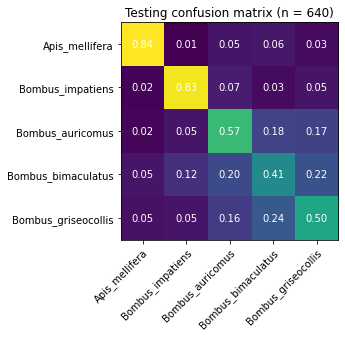

Apis_mellifera: 84.3750
Bombus_impatiens: 82.8125
Bombus_auricomus: 57.0312
Bombus_bimaculatus: 40.6250
Bombus_griseocollis: 50.0000
Best val_acc: 97.6562
-> Starting trial run-1
{'channels': 128, 'dropout': 0.2, 'optimizer': 'sgd'}
Device: cuda:0
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)
  Epoch: 0 [6/32/39195 (0%)]	Loss: 1.616895	Acc: 18.750000%
  Epoch: 0 [1302/6432/39195 (16%)]	Loss: 1.609573	Acc: 20.242537%
  Epoch: 0 [2660/12832/39195 (33%)]	Loss: 1.608422	Acc: 20

Epoch: 10	Loss: 0.943546	Acc: 60.780712
 Validation correct: 712.0 / 1280
Validation: acc: 55.625000%	loss: 0.033049
 Testing correct: 356.0 / 640
Testing: acc: 55.625000%	loss: 0.033278
Best: 9 @ 55.859375% -> epoch target 14
  Epoch: 11 [20/32/39195 (0%)]	Loss: 0.979768	Acc: 62.500000%
  Epoch: 11 [4040/6432/39195 (16%)]	Loss: 0.717174	Acc: 62.810945%
  Epoch: 11 [8128/12832/39195 (33%)]	Loss: 0.852987	Acc: 63.341646%
  Epoch: 11 [12242/19232/39195 (49%)]	Loss: 0.814595	Acc: 63.654326%
  Epoch: 11 [16301/25632/39195 (65%)]	Loss: 0.793655	Acc: 63.596286%
  Epoch: 11 [20349/32032/39195 (82%)]	Loss: 0.728902	Acc: 63.527098%
  Epoch: 11 [24461/38432/39195 (98%)]	Loss: 0.524693	Acc: 63.647481%
Epoch: 11	Loss: 0.880595	Acc: 63.650976
 Validation correct: 744.0 / 1280
Validation: acc: 58.125000%	loss: 0.031488
 Testing correct: 368.0 / 640
Testing: acc: 57.500000%	loss: 0.032045
Best: 11 @ 58.125000% -> epoch target 16
  Epoch: 12 [18/32/39195 (0%)]	Loss: 0.925461	Acc: 56.250000%
  Epoch: 1

  Epoch: 22 [23226/25632/39195 (65%)]	Loss: 0.193085	Acc: 90.613296%
  Epoch: 22 [28970/32032/39195 (82%)]	Loss: 0.137265	Acc: 90.440809%
  Epoch: 22 [34710/38432/39195 (98%)]	Loss: 0.476560	Acc: 90.315362%
Epoch: 22	Loss: 0.198826	Acc: 90.345707
 Validation correct: 1158.0 / 1280
Validation: acc: 90.468750%	loss: 0.006437
 Testing correct: 377.0 / 640
Testing: acc: 58.906250%	loss: 0.063357
Best: 22 @ 90.468750% -> epoch target 27
  Epoch: 23 [31/32/39195 (0%)]	Loss: 0.092729	Acc: 96.875000%
  Epoch: 23 [5873/6432/39195 (16%)]	Loss: 0.113871	Acc: 91.309080%
  Epoch: 23 [11691/12832/39195 (33%)]	Loss: 0.152556	Acc: 91.108167%
  Epoch: 23 [17535/19232/39195 (49%)]	Loss: 0.046611	Acc: 91.176165%
  Epoch: 23 [23396/25632/39195 (65%)]	Loss: 0.022679	Acc: 91.276529%
  Epoch: 23 [29184/32032/39195 (82%)]	Loss: 0.212817	Acc: 91.108891%
  Epoch: 23 [34995/38432/39195 (98%)]	Loss: 0.108855	Acc: 91.056932%
Epoch: 23	Loss: 0.181579	Acc: 91.009057
 Validation correct: 1161.0 / 1280
Validation: acc

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os, datetime, math

from torch.utils.tensorboard import SummaryWriter 
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp 
length = 256
skip_all = False

classes = ['Apis_mellifera','Bombus_impatiens','Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']
#classes = ['Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']

ABS_PATH_TRAIN = '/m2docs/res/data/train'
ABS_PATH_VALID = '/m2docs/res/data/valid'
ABS_PATH_TEST = '/m2docs/res/data/test'
ABS_PATH_TRAIN_RAW = '/m2docs/res/data_raw/train'
ABS_PATH_VALID_RAW = '/m2docs/res/data_raw/valid'
ABS_PATH_TEST_RAW = '/m2docs/res/data_raw/test'

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load(dir_name, batch_size, shuffle = False):
    return(
        #create a data loader
        torch.utils.data.DataLoader(
            datasets.ImageFolder(root = dir_name, transform = transforms.ToTensor()),
            batch_size = batch_size,
            num_workers = 2,
            shuffle = shuffle
        )
    )

class Net(nn.Module):
    def __init__(self, hparams):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p = hparams[HP_DROPOUT])
        
        self.conv1 = nn.Conv2d(3, int(hparams[HP_NUM_UNITS]/8), 5)
        self.conv2 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/8), int(hparams[HP_NUM_UNITS]/4), 5)
        self.conv3 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/4), int(hparams[HP_NUM_UNITS]/2), 5)
        self.conv4 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/2), hparams[HP_NUM_UNITS], 5)
        
        self.fc1 = nn.Linear(hparams[HP_NUM_UNITS]*28*28, length)
        self.fc2 = nn.Linear(length, int(length/2))
        #self.fc3 = nn.Linear(int(length/2), int(length/4))
        self.fc3 = nn.Linear(int(length/2), 5)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = self.dropout(F.relu(self.pool(self.conv2(x))))
        x = self.dropout(F.relu(self.pool(self.conv3(x))))
        x = (F.relu(self.pool(self.conv4(x))))
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        return x

def validate(network,device,load_valid,optimizer,criterion = nn.CrossEntropyLoss()):
    network.train().to(device)
    correct = 0
    valid_loss = 0
    for index, data in enumerate(load_valid, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        valid_loss += loss.item()

        # gather accuracy stats:
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()
    print(" Validation correct: {} / {}".format(correct,len(load_valid.dataset)))  
    accuracy = 100 * correct / len(load_valid.dataset)
    valid_loss = valid_loss / len(load_valid.dataset)
    return accuracy, valid_loss

def test(network,device,load_test,criterion = nn.CrossEntropyLoss()):
    network.eval().to(device)
    correct = 0
    valid_loss = 0
    with torch.no_grad():
        for index, data in enumerate(load_test, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = network(inputs)
            valid_loss += criterion(outputs, labels).item()

            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
    print(" Testing correct: {} / {}".format(correct,len(load_test.dataset)))        
    accuracy = 100 * correct / len(load_test.dataset)
    valid_loss = valid_loss / len(load_test.dataset)
    return accuracy , valid_loss

def train(max_epochs, min_epochs, epoch_stretch, batch_size, train_path, valid_path, test_path, labels, hparams, writer):
    epochs = max_epochs
    class_names = labels
    num_classes = len(class_names)
    train_batch = batch_size
    test_batch = 128
    SAVE_PATH = '/m2docs/res/trained_models/model'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    net = Net(hparams).to(device)
    print(net)
    
    tag = datetime.datetime.now().strftime(".%Y%m%d-%H%M%S")

    criterion = nn.CrossEntropyLoss()
    
    # Choose optimizer: (from ['adam','sgd','adagrad'])
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    if (hparams[HP_OPTIMIZER] == 'adam'):
        optimizer = optim.Adam(net.parameters(), lr = .001)
    elif (hparams[HP_OPTIMIZER] == 'sgd'):
        optimizer = optim.SGD(net.parameters(), lr = .001, momentum=0.9)
    elif (hparams[HP_OPTIMIZER] == 'adagrad'):
        optimizer = optim.Adagrad(net.parameters(), lr = .001,)
    else:
        # default
        optimizer = optim.Adam(net.parameters(), lr = 0.001)

    torch.manual_seed(417)
    
    load_train = load(train_path, batch_size, shuffle=True)
    load_valid = load(valid_path, batch_size, shuffle=True)
    load_test  = load(test_path, batch_size, shuffle=True)

    validation_accuracies = []
    best_epoch = 0
    epoch = 0
    killed = False
    while (epoch <= best_epoch + epoch_stretch or epoch < min_epochs) and epoch < max_epochs and not killed:
        net.train()
        run_loss = 0.0
        sum_loss = 0.0
        count = 0
        correct = 0.0
        categorical_correct = [0.0 for i in range(num_classes)]
        for index, data in enumerate(load_train, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
            for i in range(num_classes):
                categorical_correct[i] += ((predicted==i) == (labels==i)).float().sum().item()
                #print(classes[i],categorical_correct[i]/((index+1)*batch_size))
            
            # print statistics
            run_loss += loss.item()
            sum_loss += loss.item()
            count += 1 
            if index % 200 == 0:    # print every 200 mini-batches
                print('  Epoch: {} [{}/{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                    epoch, int(correct), (index + 1) * batch_size, len(load_train.dataset),
                    100. * index / len(load_train), loss.item(), 100. * correct / ((index+1) * batch_size)))
                run_loss = 0.0
        accuracy = 100. * correct / len(load_train.dataset)
        print('Epoch: {}\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, sum_loss/count, accuracy))
        writer.add_scalar("Loss/train", sum_loss/count, epoch)
        writer.add_scalar("Acc/train", accuracy, epoch)
        
        modules_list = iter(net.named_modules())
        next(modules_list)
        for module in modules_list:
            try:
                writer.add_histogram("Model/"+module[0]+".weights", module[1].weight, epoch)
                writer.add_histogram("Model/"+module[0]+".bias", module[1].bias, epoch)
            except:
                pass
        # Categorical accuracy:
        for i in range(num_classes):
            writer.add_scalar("Acc/" + classes[i],categorical_correct[i]/len(load_train.dataset), epoch)
        torch.save(net.state_dict(), SAVE_PATH + tag + "-progress")
        
        # get validation accuracy: 
        valid_acc, valid_loss = validate(net, device, load_valid, optimizer, criterion)
        writer.add_scalar("Loss/valid", valid_loss, epoch)
        writer.add_scalar("Acc/valid", valid_acc, epoch)
        print('Validation: acc: {:.6f}%\tloss: {:.6f}'.format(
                valid_acc, valid_loss))
        validation_accuracies.append(valid_acc)
        best_epoch = validation_accuracies.index(max(validation_accuracies))
        
        # get test accuracy: 
        test_acc, test_loss = test(net, device, load_test, criterion)
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("Acc/test", test_acc, epoch)
        print('Testing: acc: {:.6f}%\tloss: {:.6f}'.format(
                test_acc, test_loss))
        
        # this is the best epoch so far, save these weights:
        if (best_epoch == epoch):
            torch.save(net.state_dict(), SAVE_PATH + tag + "-best")
        if (epoch >= 2):
            if (validation_accuracies[epoch] == 100/num_classes):
                killed = True
                print("[!] This run has failed, accuracies are bad. Aborting.")
        
        print('Best: {} @ {:.6f}% -> epoch target {}'.format(best_epoch,validation_accuracies[best_epoch],max([best_epoch+epoch_stretch,min_epochs])))
        epoch += 1
        
    print('Done training.')
    torch.save(net.state_dict(), SAVE_PATH + tag + "-final")
    
    ## TODO: test here

    prediction_list = torch.zeros(0,dtype=torch.long).to(device)
    label_list = torch.zeros(0,dtype=torch.long).to(device)
    
    ## Testing
    net.eval().to(device)
    correct = 0
    valid_loss = 0
    with torch.no_grad():
        for index, data in enumerate(load_test, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            valid_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            prediction_list = torch.cat([prediction_list, predicted.view(-1)])  
            label_list = torch.cat([label_list, labels.view(-1)])
            #print("Predictions, ground:")
            #print(prediction_list)
            #print(label_list)
            correct += (predicted == labels).float().sum().item()
    print(" Testing correct: {} / {}".format(correct,len(load_test.dataset)))        
    t_acc = 100 * correct / len(load_test.dataset)
    t_loss = valid_loss / len(load_test.dataset)

    
    matrix = confusion_matrix(label_list.cpu().numpy(), prediction_list.cpu().numpy())
    print(matrix)
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, "{:4.2f}".format(matrix[i, j]/sum(matrix[i])),
                           ha="center", va="center", color="w")

    ax.set_title("Testing confusion matrix (n = {})".format(len(load_test.dataset)))

    plt.show()
    writer.add_figure('Testing/conf',fig)
    
    class_accuracy=100*matrix.diagonal() / matrix.sum(1)
    #print(classes)
    #print(class_accuracy)
    for i in range(len(classes)):
        print("{}: {:.4f}".format(classes[i],class_accuracy[i]))
    print("Best val_acc: {:6.4f}".format(max(validation_accuracies)))
    return max(validation_accuracies)

# magic here.
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        run_writer = SummaryWriter(log_dir = run_dir)            
        if (hparams[HP_YOLOCROPPED] == True):
            train_path = ABS_PATH_TRAIN_RAW
            valid_path = ABS_PATH_VALID_RAW
            test_path = ABS_PATH_TEST_RAW
        else:
            train_path = ABS_PATH_TRAIN
            valid_path = ABS_PATH_VALID
            test_path = ABS_PATH_TEST
        
        accuracy = train(max_epochs = 100, min_epochs = 10, epoch_stretch = 5, batch_size = 32, train_path, valid_path, test_path, labels = classes, hparams = hparams, writer = run_writer)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

if (skip_all is False): 
    HP_NUM_UNITS = hp.HParam('channels', hp.Discrete([128, 256]))
    HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
    #HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd','adagrad']))
    HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd']))
    HP_YOLOCROPPED = hp.HParam('processed (yolo)', hp.Discrete([True, False]))
    METRIC_ACCURACY = 'accuracy'
    
    hpdirname = 'runs/' + (datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ':hparam_tuning')
    with tf.summary.create_file_writer(hpdirname).as_default():
        hp.hparams_config(
            hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
            metrics=[hp.Metric(METRIC_ACCURACY, display_name='best accuracy (validation)')]
        )
    
    session_num = 0
    for num_units in HP_NUM_UNITS.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for optimizer in HP_OPTIMIZER.domain.values:
                for yolo in HP_YOLOCROPPED.domain.values:
                    hparams = {
                        HP_NUM_UNITS: num_units,
                        HP_DROPOUT: float("%0.2f"%float(dropout_rate)),
                        HP_OPTIMIZER: optimizer,
                        HP_YOLOCROPPED: yolo,
                    }
                    torch.cuda.empty_cache()
                    run_name = "run-%d" % session_num
                    print("-> Starting trial %s" % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run(os.path.join(hpdirname, '_' + str(session_num)), hparams)
                    session_num += 1

# 2 stage classifier

1. Train to detect *Apis Mellifera* vs. *Bombus Auricomus* vs. a merged set of the other classes.
2. Train a second model to tell apart the other three classes.'
3. Note that both of these datasets will by default be unbalanced unless something is changed above.
4. When running detections, if the first model's confidence is below a threshold, apply the second model to see if there is an improved prediction.

`todo: balance datasets`

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os, datetime, math

from torch.utils.tensorboard import SummaryWriter 
length = 512
var_droupout = 0.2
skip_all = True
tag1 = ':' + str(length) + '_STAGE-1_' + str(var_droupout)
tag2 = ':' + str(length) + '_STAGE-2_' + str(var_droupout)
writer1 = SummaryWriter(log_dir = os.path.join('runs/',(datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + tag1)))
writer2 = SummaryWriter(log_dir = os.path.join('runs/',(datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + tag2)))
print("tensorboard writing"+tag1)
print("tensorboard writing"+tag2)

classes1 = ['Apis_mellifera','Bombus_impatiens','Merged']
classes2 = ['Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']

ABS_PATH_TRAIN1 = '/m2docs/res/data1/train'
ABS_PATH_VALID1 = '/m2docs/res/data1/valid'
ABS_PATH_TEST1 = '/m2docs/res/data1/test'
ABS_PATH_TRAIN2 = '/m2docs/res/data2/train'
ABS_PATH_VALID2 = '/m2docs/res/data2/valid'
ABS_PATH_TEST2 = '/m2docs/res/data2/test'

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load(dir_name, batch_size, shuffle = False):
    return(
        #create a data loader
        torch.utils.data.DataLoader(
            datasets.ImageFolder(root = dir_name, transform = transforms.ToTensor()),
            batch_size = batch_size,
            num_workers = 2,
            shuffle = shuffle
        )
    )

# Layer/network 1:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p = var_droupout)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        
        self.fc1 = nn.Linear(128*28*28, length)
        self.fc2 = nn.Linear(length, int(length/2))
        #self.fc3 = nn.Linear(int(length/2), int(length/4))
        self.fc3 = nn.Linear(int(length/2), 5)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = self.dropout(F.relu(self.pool(self.conv2(x))))
        x = self.dropout(F.relu(self.pool(self.conv3(x))))
        x = (F.relu(self.pool(self.conv4(x))))
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        return x
    
# Layer/network 2:    
class Net2(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p = var_droupout)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        
        self.fc1 = nn.Linear(128*28*28, length)
        self.fc2 = nn.Linear(length, int(length/2))
        #self.fc3 = nn.Linear(int(length/2), int(length/4))
        self.fc3 = nn.Linear(int(length/2), 5)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = self.dropout(F.relu(self.pool(self.conv2(x))))
        x = self.dropout(F.relu(self.pool(self.conv3(x))))
        x = (F.relu(self.pool(self.conv4(x))))
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        return x

def validate(network,device,load_valid,criterion = nn.CrossEntropyLoss()):
    network.eval().to(device)
    correct = 0
    valid_loss = 0
    with torch.no_grad():
        for index, data in enumerate(load_valid, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = network(inputs)
            valid_loss += criterion(outputs, labels).item()

            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
    accuracy = 100 * correct / len(load_valid.dataset)
    valid_loss = valid_loss / len(load_valid.dataset)
    return accuracy , valid_loss

def train(max_epochs = 50, min_epochs = 5, epoch_stretch = 5, train_path = ABS_PATH_TRAIN, valid_path = ABS_PATH_VALID, test_path = ABS_PATH_TEST, labels = classes, batch_size = 24):
    epochs = max_epochs
    class_names = labels
    num_classes = len(class_names)
    train_batch = batch_size
    test_batch = 128
    SAVE_PATH = '/m2docs/res/models'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    net = Net().to(device)
    print(net)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr = 0.001)

    torch.manual_seed(417)
    
    load_train = load(train_path, batch_size, shuffle=True)
    load_valid = load(valid_path, batch_size, shuffle=True)
    load_test  = load(test_path, batch_size, shuffle=True)

    validation_accuracies = []
    best_epoch = 0
    epoch = 0
    while (epoch <= best_epoch + epoch_stretch or epoch < min_epochs) and epoch < max_epochs:
        net.train()
        run_loss = 0.0
        sum_loss = 0.0
        count = 0
        correct = 0.0
        categorical_correct = [0.0 for i in range(num_classes)]
        for index, data in enumerate(load_train, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
            for i in range(num_classes):
                categorical_correct[i] += ((predicted==i) == (labels==i)).float().sum().item()
                #print(classes[i],categorical_correct[i]/((index+1)*batch_size))
            
            # print statistics
            run_loss += loss.item()
            sum_loss += loss.item()
            count += 1 
            if index % 200 == 0:    # print every 200 mini-batches
                print('  Epoch: {} [{}/{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                    epoch, int(correct), (index + 1) * batch_size, len(load_train.dataset),
                    100. * index / len(load_train), loss.item(), 100. * correct / ((index+1) * batch_size)))
                run_loss = 0.0
        accuracy = 100. * correct / len(load_train.dataset)
        print('Epoch: {}\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, sum_loss/count, accuracy))
        writer.add_scalar("Loss/train", sum_loss/count, epoch)
        writer.add_scalar("Acc/train", accuracy, epoch)
        
        modules_list = iter(net.named_modules())
        next(modules_list)
        for module in modules_list:
            try:
                writer.add_histogram("Model/"+module[0]+".weights", module[1].weight, epoch)
                writer.add_histogram("Model/"+module[0]+".bias", module[1].bias, epoch)
            except:
                pass
        # Categorical accuracy:
        for i in range(num_classes):
            writer.add_scalar("Acc/" + classes[i],categorical_correct[i]/len(load_train.dataset), epoch)
        torch.save(net.state_dict(), SAVE_PATH+"_progress")
        
        # get validation accuracy: 
        valid_acc, valid_loss = validate(net, device, load_valid, criterion)
        writer.add_scalar("Loss/valid", valid_loss, epoch)
        writer.add_scalar("Acc/valid", valid_acc, epoch)
        print('Validation: acc: {:.6f}%\tloss: {:.6f}'.format(
                valid_acc, valid_loss))
        validation_accuracies.append(valid_acc)
        best_epoch = validation_accuracies.index(max(validation_accuracies))
        print('Best: {} @ {:.6f}% -> epoch target {}'.format(best_epoch,validation_accuracies[best_epoch],max([best_epoch+epoch_stretch,min_epochs])))
        epoch += 1
        
    print('Done training.')
    torch.save(net.state_dict(), SAVE_PATH)

    prediction_list = torch.zeros(0,dtype=torch.long).to(device)
    label_list = torch.zeros(0,dtype=torch.long).to(device)
              
    with torch.no_grad():
        for data in load_test:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
              
            prediction_list = torch.cat([prediction_list, predicted.view(-1)])  
            label_list = torch.cat([label_list, labels.view(-1)])
    
    matrix = confusion_matrix(label_list.cpu().numpy(), prediction_list.cpu().numpy())
    print(matrix)
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, matrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Testing confusion matrix")

    plt.show()
    writer.add_figure('Testing/conf',fig)
    
    class_accuracy=100*matrix.diagonal() / matrix.sum(1)
    print(classes)
    print(class_accuracy)

if (skip_all is False):
    # setup: create 2-stage directories:
    # data1: first stage: mellifera, impatiens, 3-merged
    %mkdir data1
    %rm -r data1/*
    %mkdir data1/train
    %cp -r data/train/Apis_mellifera data1/train/Apis_mellifera
    %cp -r data/train/Bombus_auricomus data1/train/Bombus_auricomus
    %cp -r data/train/Bombus_bimaculatus data1/train/Merged
    %cp data/train/Bombus_griseocollis/* data1/train/Merged
    %cp data/train/Bombus_impatiens/* data1/train/Merged
    %mkdir data1/valid
    %cp -r data/valid/Apis_mellifera data1/valid/Apis_mellifera
    %cp -r data/valid/Bombus_auricomus data1/valid/Bombus_auricomus
    %cp -r data/valid/Bombus_bimaculatus data1/valid/Merged
    %cp data/valid/Bombus_griseocollis/* data1/valid/Merged
    %cp data/valid/Bombus_impatiens/* data1/valid/Merged
    %mkdir data1/test
    %cp -r data/test/Apis_mellifera data1/test/Apis_mellifera
    %cp -r data/test/Bombus_auricomus data1/test/Bombus_auricomus
    %cp -r data/test/Bombus_bimaculatus data1/test/Merged
    %cp data/test/Bombus_griseocollis/* data1/test/Merged
    %cp data/test/Bombus_impatiens/* data1/test/Merged

    # data2: auricomus vs bimaculatus vs griseocollis
    %mkdir data2
    %rm -r data2/*
    %mkdir data2/train
    %cp -r data/train/Bombus_bimaculatus data2/train/Bombus_bimaculatus
    %cp -r data/train/Bombus_griseocollis data2/train/Bombus_griseocollis
    %cp -r data/train/Bombus_impatiens data2/train/Bombus_impatiens
    %mkdir data2/valid
    %cp -r data/valid/Bombus_bimaculatus data2/valid/Bombus_bimaculatus
    %cp -r data/valid/Bombus_griseocollis data2/valid/Bombus_griseocollis
    %cp -r data/valid/Bombus_impatiens data2/valid/Bombus_impatiens
    %mkdir data2/test
    %cp -r data/test/Bombus_bimaculatus data2/test/Bombus_bimaculatus
    %cp -r data/test/Bombus_griseocollis data2/test/Bombus_griseocollis
    %cp -r data/test/Bombus_impatiens data2/test/Bombus_impatiens
    
    # train
    train(max_epochs = 160, min_epochs = 70, epoch_stretch = 15, train_path = ABS_PATH_TRAIN, valid_path = ABS_PATH_VALID, test_path = ABS_PATH_TEST, labels = classes, batch_size = 32)